**Time Series Predictive Modeling for Financial Portfolio**  

This project develops a predictive modeling pipeline that uses historical stock return data, financial ratios, and sector information to forecast future stock performance and construct an optimized investment portfolio. The project integrates multiple stages from raw data processing to model training and portfolio evaluation.

**Objectives:**

- Integrate and clean data from multiple sources (stock returns, financial metrics, and sector classifications) into a unified time-series dataset.
- Implement rigorous data preprocessing, including handling of delisted stocks, ticker aliasing, sector-aware imputation, and financial-based feature engineering.
- Construct and evaluate time-series predictive models, including baseline regressors and XGBoost, using a rolling window approach.
- Analyze feature importance across time and market conditions to guide model interpretation.
- Construct portfolios based on top predicted stocks. Compare ML-based portfolios against benchmark index and GPT-based stock selections to explore the efficacy of AI in portfolio management.
- Further exploration into portfolio construction.


#  **0. Load Libraries**

In [ ]:
# Environment Setup
# Standard libraries
import os
import random
import logging
import warnings
from pathlib import Path

# Colab-specific setup
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/My Drive/823')
except ModuleNotFoundError:
    logging.warning("Google Colab modules not found - running locally")

# Data manipulation
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import missingno as msno
from tabulate import tabulate

# Machine Learning
## Core
from sklearn import __version__ as skl_version
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    classification_report, mean_squared_error
)

## XGBoost
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

## Optimization
try:
    import optuna
except ImportError:
    !pip install -q optuna
    import optuna

try:
    from tqdm_joblib import tqdm_joblib
except ImportError:
    !pip install tqdm-joblib
    from tqdm_joblib import tqdm_joblib

# Configuration
# -------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import logging
logging.basicConfig(level=logging.INFO)

from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from joblib import Parallel, delayed
from tqdm import tqdm
import yfinance as yf
from tqdm_joblib import tqdm_joblib
import contextlib
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
import cvxpy as cp
import statsmodels.api as sm

pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(style='whitegrid', palette='muted')
print(f"Scikit-learn version: {skl_version}")
print(f"XGBoost version: {xgb.__version__}")
print(f"Optuna version: {optuna.__version__}")


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 28.0 MB/s eta 0:00:00
Scikit-learn version: 1.6.1
XGBoost version: 2.1.4
Optuna version: 4.2.1


# **1. Data Preprocessing**

## **1.1 Load Datasets**

In [ ]:
# Direct file path
stock_return_data_path = os.path.join("input data", "Stock_Return_Data2023Fwd.xlsx")
financial_ratios_path = os.path.join("input data", "Financial Ratios Data 2003_2023x.xlsm")
sector_info_path = os.path.join("input data", 'Sector Information.xlsm')

# Load datasets
df_returns = pd.read_excel(stock_return_data_path, sheet_name="Data")
df_ratios  = pd.read_excel(financial_ratios_path, sheet_name="financial_ratios", skiprows=1)
df_sector  = pd.read_excel(sector_info_path, sheet_name="sector data")

## **1.2 Data Merging & Initial Imputation**

This cell combines our three raw inputs (stock returns, financial ratios, and sector information) into a single, analysis‑ready DataFrame. It performs the following sequential steps:

1. **Standardize Key Columns**  
   - Applies a single `COLUMN_MAPPING` to rename all variants of the time key (`PERMNO_DATE_LABEL`, `permno_yearmonth`, etc.) to `PERMNO-YearMonth`.  
   - Normalizes sector labels (`GIC_SECTOR`, `Sector`, `sector`) to `Sector Name`.  
   - Renames the lowercase `permno` in the sector sheet to uppercase `PERMNO` for consistency.

2. **Merge Returns & Ratios**  
   - Performs an inner join on `PERMNO-YearMonth`, ensuring only periods present in both returns and ratios remain.  
   - Uses suffixes (`_ret`, `_ratio`) to avoid silent overwrites of duplicated columns.  
   - Consolidates duplicate ticker columns into a single `TICKER`.

3. **Unify Stock Identifiers**  
   - Coalesces any remaining `permno` values into the standardized uppercase `PERMNO` column.  
   - Drops the redundant lowercase `permno` field.

4. **Merge Sector Information**  
   - Left‑joins the cleaned returns‑ratios table with sector data on both `PERMNO` and `TICKER`, preserving all merged records while appending sector labels.

5. **Filter & Deduplicate**  
   - Excludes rows from unwanted sectors (`Real Estate`, `Financials`, `Healthcare`).  
   - Removes any duplicated columns that may have arisen during merging.

6. **Date Conversion & Final Check**  
   - Converts the `date` column (if present) to `datetime` dtype for time‑series operations.  
   - Prints the final DataFrame shape as a quick sanity check.

The result (`df_clean`) is a single DataFrame with aligned keys, no duplicate columns, and only relevant sectors — ready for downstream time‑series imputation, EDA, and modeling.  


In [ ]:
# Standardize key names
COLUMN_MAPPING = {
    'PERMNO_DATE_LABEL': 'PERMNO-YearMonth',
    'permno_yearmonth': 'PERMNO-YearMonth',
    'PERMNO-YM': 'PERMNO-YearMonth',
    'GIC_SECTOR': 'Sector Name',
    'Sector': 'Sector Name',
    'sector': 'Sector Name'
}
df_returns.rename(columns=COLUMN_MAPPING, inplace=True)
df_ratios.rename(columns=COLUMN_MAPPING, inplace=True)
df_sector.rename(columns=COLUMN_MAPPING, inplace=True)
df_sector.rename(columns={'permno': 'PERMNO'}, inplace=True)

# Merge returns + ratios (avoid duplicate TICKER)
df_merged = pd.merge(
    df_returns, df_ratios,
    on="PERMNO-YearMonth",
    how="inner",
    suffixes=('_ret','_ratio')
)
df_merged['TICKER'] = df_merged['TICKER_ret'].fillna(df_merged['TICKER_ratio'])
df_merged.drop(columns=['TICKER_ret','TICKER_ratio'], inplace=True)

# Unify PERMNO from both sources
df_merged['PERMNO'] = df_merged.get('permno').fillna(df_merged.get('PERMNO'))
df_merged.drop(columns=['permno'], errors='ignore', inplace=True)

# Merge with sector info on PERMNO + TICKER
df_clean = pd.merge(
    df_merged,
    df_sector[['PERMNO','TICKER','Sector Name']],
    on=['PERMNO','TICKER'],
    how='left'
)

# Exclude unwanted sectors and drop duplicate columns
excluded = ['Real Estate','Financials','Healthcare']
df_clean = df_clean[~df_clean['Sector Name'].isin(excluded)]
df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]

# Convert date to datetime if present
if 'date' in df_clean.columns:
    df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce')

print("Final cleaned shape:", df_clean.shape)

Final cleaned shape: (83560, 90)


## **1.3 Time‑Series Aware Imputation**

This cell defines a concise, two‑stage imputation function that fills missing numeric values **only using past data** (thus preserving temporal integrity and avoiding leakage). It avoids forward/backward fills entirely by relying on `groupby().transform`, which keeps each column’s index aligned with the original DataFrame.

1. **Stock‑level imputation**  
   - For each stock (`PERMNO`), compute an **expanding median** of its historical values, shifted forward one period so that only prior data is used.  
   - Fill any missing value with this shifted median, marking it as “stock‑level” imputed.

2. **Sector‑level imputation**  
   - For remaining gaps, compute an **expanding median** within each sector (`Sector Name`) up to the current date.  
   - Fill missing values with the sector median, marking them as “sector‑level” imputed.

3. **Global fallback**  
   - If any values remain missing (rare), fill them with the overall column median to guarantee zero nulls.

Each numeric column receives an accompanying `{column}_imputed` indicator (0 = original, 1 = stock‑level, 2 = sector‑level).

This approach is entirely time‑aware, scalable, and warning‑free because it uses vectorized `transform` rather than `apply`.  


In [ ]:
# Time-Series Aware Imputation
def impute_time_series(df, numeric_cols, stock_id='PERMNO', date_col='date', sector_col='Sector Name'):
    df = df.sort_values([stock_id, date_col]).copy()

    for col in numeric_cols:
        indicator = f"{col}_imputed"
        df[indicator] = 0

        # Stock‑level expanding median (shifted by 1) — aligned via transform
        stock_median = df.groupby(stock_id)[col] \
            .transform(lambda s: s.expanding().median().shift())

        mask_stock = df[col].isna() & stock_median.notna()
        df.loc[mask_stock, col] = stock_median[mask_stock]
        df.loc[mask_stock, indicator] = 1

        # Sector‑level expanding median (ADDING SHIFT HERE) for any leftovers
        sector_median = df.groupby(sector_col)[col] \
            .transform(lambda s: s.expanding().median().shift())

        mask_sector = df[col].isna() & sector_median.notna()
        df.loc[mask_sector, col] = sector_median[mask_sector]
        df.loc[mask_sector, indicator] = 2

        # Final fallback to global median
        df[col].fillna(df[col].median(), inplace=True)

    return df

# numeric_columns = ['roa', 'roe', 'npm', 'pe_op_basic', 'bm', 'debt_assets']
exclude_cols = ['PERMNO', 'TICKER', 'date', 'Forward 3-Month Ret', "PERMNO-YearMonth", "gvkey", "adate", "qdate", "public_date", "YEAR", "MONTH"]
numeric_columns = [
    c for c in df_clean.select_dtypes(include='number').columns
    if c not in exclude_cols
]
df_imputed = impute_time_series(df_clean, numeric_columns)

print("Remaining missing values per column:")
print(df_imputed[numeric_columns].isna().sum())


Remaining missing values per column:
SIC Industry Code        0
Price Index              0
Unnamed: 8           83560
Past 3-Month Ret         0
Past 6-Month Ret         0
                     ...  
rd_sale                  0
adv_sale                 0
staff_sale               0
accrual                  0
ptb                      0
Length: 75, dtype: int64


## **1.4 Export for EDA**

In [ ]:
# Drop imputation indicator columns when not needed for further analysis
indicator_cols = [col for col in df_imputed.columns if col.endswith('_imputed')]
df_imputed.drop(columns=indicator_cols, inplace=True)

# Save the cleaned and imputed dataset to CSV
df_imputed.to_csv('cleaned_data.csv', index=False)

print("Final dataset saved. Data shape:", df_imputed.shape)

Final dataset saved. Data shape: (83560, 90)


**What to expect in different transforming methods with financial data for picking WINNER stocks**

| Metric Type | Log (Handles Skewness) | MinMax (Rescale 0-1) | Robust (IQR-Based) | Standardized (Z-Score) |
|------------|------------------------|----------------------|--------------------|-----------------------|
| Stock Returns\newline(Past/Forward 1-12M Ret) | Helps with large fluctuations | Good for ranking | Best for outliers | Best for cross-company comparison |
| P/E, P/B, EV Metrics | Best for skewed values | Sensitive to extremes | Helps with outliers | Good for normal comparisons |
| Debt Ratios\newline(debt\_assets, debt\_ebidta) | Helps reduce right skew | Rescales 0-1 | Best for extreme debt values | Good for cross-firm analysis |
| Liquidity Ratios\newline(cash\_ratio, curr\_ratio) | Limited use | Best for relative rankings | Reduces outlier effect | Standardizes for broad use |
| Profitability (roa, roe) | Smooths extreme values | Keeps proportionality | Best for extreme values | Good for comparisons |

# **2. EDA**

## **2.1 Data Universe Exploration**

In [ ]:
print(df_imputed.columns.tolist())

['PERMNO', 'date', 'YEAR', 'MONTH', 'SIC Industry Code', 'COMNAM', 'Price Index', 'Unnamed: 8', 'Past 1-Month Ret', 'Past 3-Month Ret', 'Past 6-Month Ret', 'Past 12-Month Ret', 'Forward 1-Month Ret', 'Forward 3-Month Ret', 'Forward 6-Month Ret', 'PERMNO-YearMonth', 'gvkey', 'adate', 'qdate', 'public_date', 'year', 'month', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rec

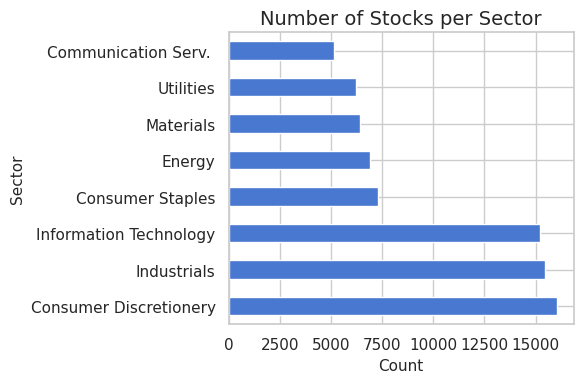

In [ ]:
sector_counts = df_imputed['Sector Name'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(6,4))
sector_counts.plot(kind='barh')
plt.title('Number of Stocks per Sector', fontsize=14)
plt.ylabel('Sector', fontsize=11)
plt.xlabel('Count', fontsize=11)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

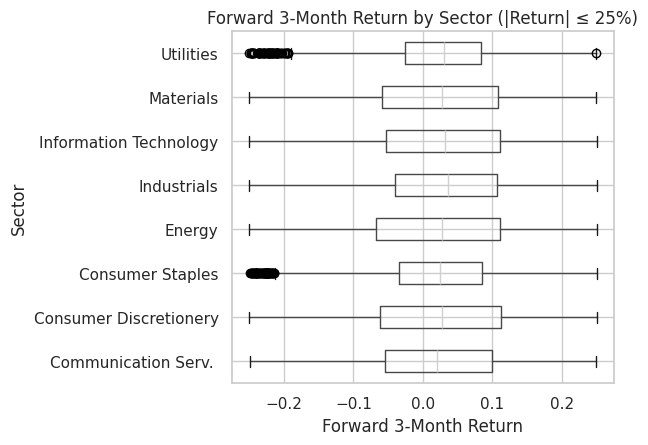

In [ ]:
# Remove extreme outliers (>±20%) to improve readability
df_box = df_imputed[df_imputed['Forward 3-Month Ret'].abs() <= 0.25]

# Plot a horizontal boxplot of forward 3‑month returns grouped by sector
plt.figure(figsize=(10, 6))
df_box.boxplot(column='Forward 3-Month Ret', by='Sector Name', vert=False)
plt.title('Forward 3-Month Return by Sector (|Return| ≤ 25%)')
plt.suptitle('')         # Remove the default “Boxplot grouped by …” subtitle
plt.xlabel('Forward 3-Month Return')
plt.ylabel('Sector')
plt.tight_layout()
plt.show()

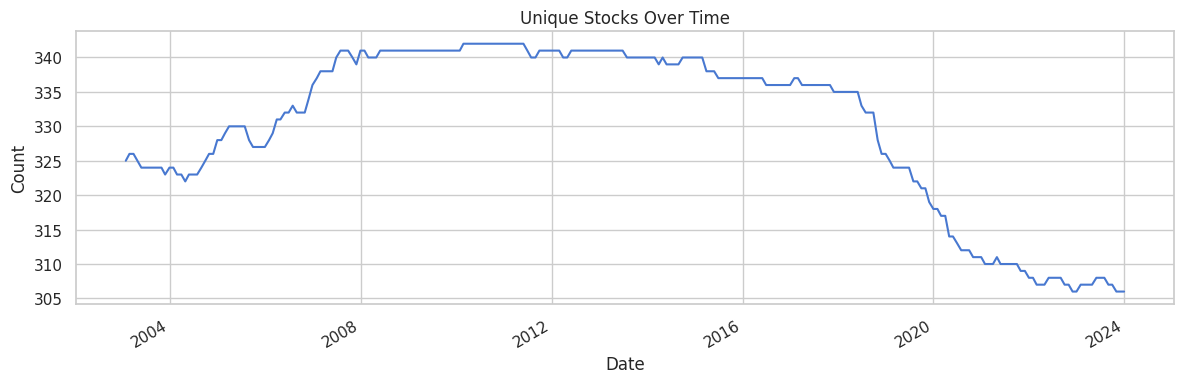

In [ ]:
plt.figure(figsize=(12,4))
df_imputed.groupby('date')['TICKER'].nunique().plot()
plt.title('Unique Stocks Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Chart show number of unique stocks (by `TICKER`) available in the dataset for each monthly timestamp.

🧠 Key Observations:
- From 2003 to ~2015, the number of tracked stocks gradually increased and stabilized around 340.

- Starting around 2017–2018, there’s a noticeable and consistent decline in stock count, reaching just above 305 by end of 2023.

⚠️ Implications:
- The shrinking universe of stocks may be due to:

  - Mergers & acquisitions

  - Delistings or data exclusions

  - Sector or filter-based constraints in the dataset

- This trend affects model training, especially for long-term rolling windows, as fewer samples may lead to:

  - Reduced generalizability

  - Increased variance in performance

  - Potential data imbalance or survivorship bias

✅ Recommendations:
- Monitor for data coverage drift when backtesting.

- Adjust feature engineering or model complexity if stock universe size changes significantly.

- Optionally, normalize portfolio metrics (e.g., returns) by stock count for fair comparison across time.


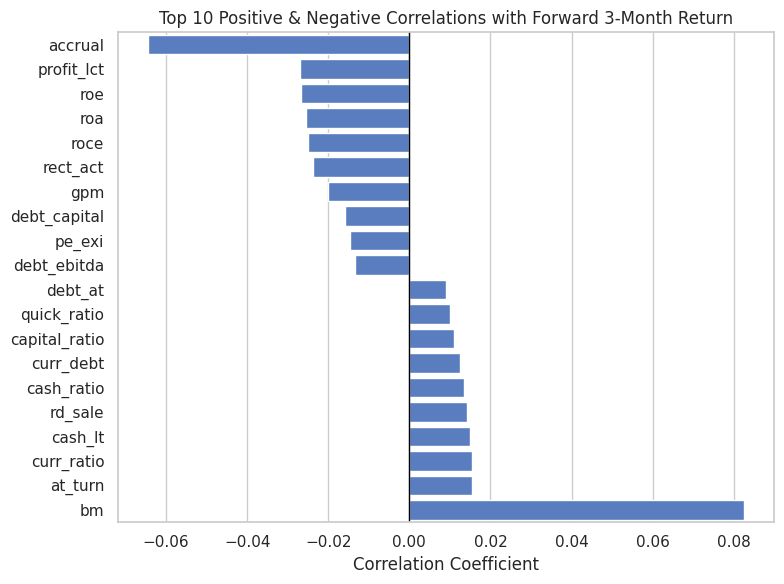

In [ ]:
# 1) Remove the empty column if it still exists
df_imputed.drop(columns=['Unnamed: 8'], errors='ignore', inplace=True)

# 2) Define our exclusion patterns
exclude_exact = {'PERMNO', 'TICKER', 'date', 'YEAR', 'year', 'MONTH', 'month', 'PERMNO-YearMonth', 'gvkey'}
exclude_substrings = ('ret', 'sic', '_imputed')
target_col = 'Forward 3-Month Ret'

# 3) Identify all numeric columns
numeric_cols = df_imputed.select_dtypes(include='number').columns

# 4) Build a filtered list:
#    - Exclude columns in `exclude_exact`
#    - Exclude columns containing any of `exclude_substrings` in their name, unless it's the target
filtered_cols = []
for col in numeric_cols:
    # Skip if it's in our exact-exclusion set
    if col in exclude_exact:
        continue
    # Skip if it has the forbidden substring(s) (ret/sic/_imputed) AND is not the target
    if any(sub in col.lower() for sub in exclude_substrings) and col != target_col.lower():
        # But if this is the actual target_col, keep it
        if col != target_col:
            continue
    filtered_cols.append(col)

# 5) Ensure our target is in the final set
if target_col not in filtered_cols:
    filtered_cols.append(target_col)

# 6) Compute correlations with target, sort, pick top 10 negative & positive
corr_df = df_imputed[filtered_cols].corr()
corr_series = corr_df[target_col]

# If the result is a DataFrame (in case of name collisions), take the first column
if isinstance(corr_series, pd.DataFrame):
    corr_series = corr_series.iloc[:, 0]

# Drop self-correlation, sort
corr_series = corr_series.drop(labels=target_col, errors='ignore').sort_values()
top_corr = pd.concat([corr_series.head(10), corr_series.tail(10)])

# 7) Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top 10 Positive & Negative Correlations with Forward 3‑Month Return')
plt.axvline(0, color='black', linewidth=1)
plt.xlabel('Correlation Coefficient')
plt.ylabel('')
plt.tight_layout()
plt.show()

**Most Negatively Correlated Features:**

| Feature | Implication |
|---------|-------------|
| accrual | High accruals may signal earnings manipulation or lower-quality earnings. |
| profit_lct, roe, roa, roce | Profitability metrics with slight negative relationships may suggest mean-reversion in earnings. |
| rect_act, gpm, debt_capital, pe_exi, debt_ebitda | Negative correlation could reflect overvaluation or high leverage risk factors. |

**Most Positively Correlated Features:**

| Feature | Implication |
|---------|-------------|
| bm (Book-to-Market) | Strongest positive correlation — value stocks (high B/M) may outperform. |
| at_turn (Asset Turnover) | Efficient asset usage is tied to better future returns. |
| curr_ratio, cash_lt, rd_sale, cash_ratio, curr_debt | These suggest financial stability or investment in innovation. |
| capital_ratio, quick_ratio, debt_at | Conservative leverage and liquidity ratios tend to be mildly positive. |

**Interpretation:**

- Most correlations are quite modest, which is typical for financial data.
- The strongest signal is from book-to-market ratio, aligning with well-known value investing factors.
- Negative correlation of some profitability metrics could imply market overreaction or earnings mean reversion.

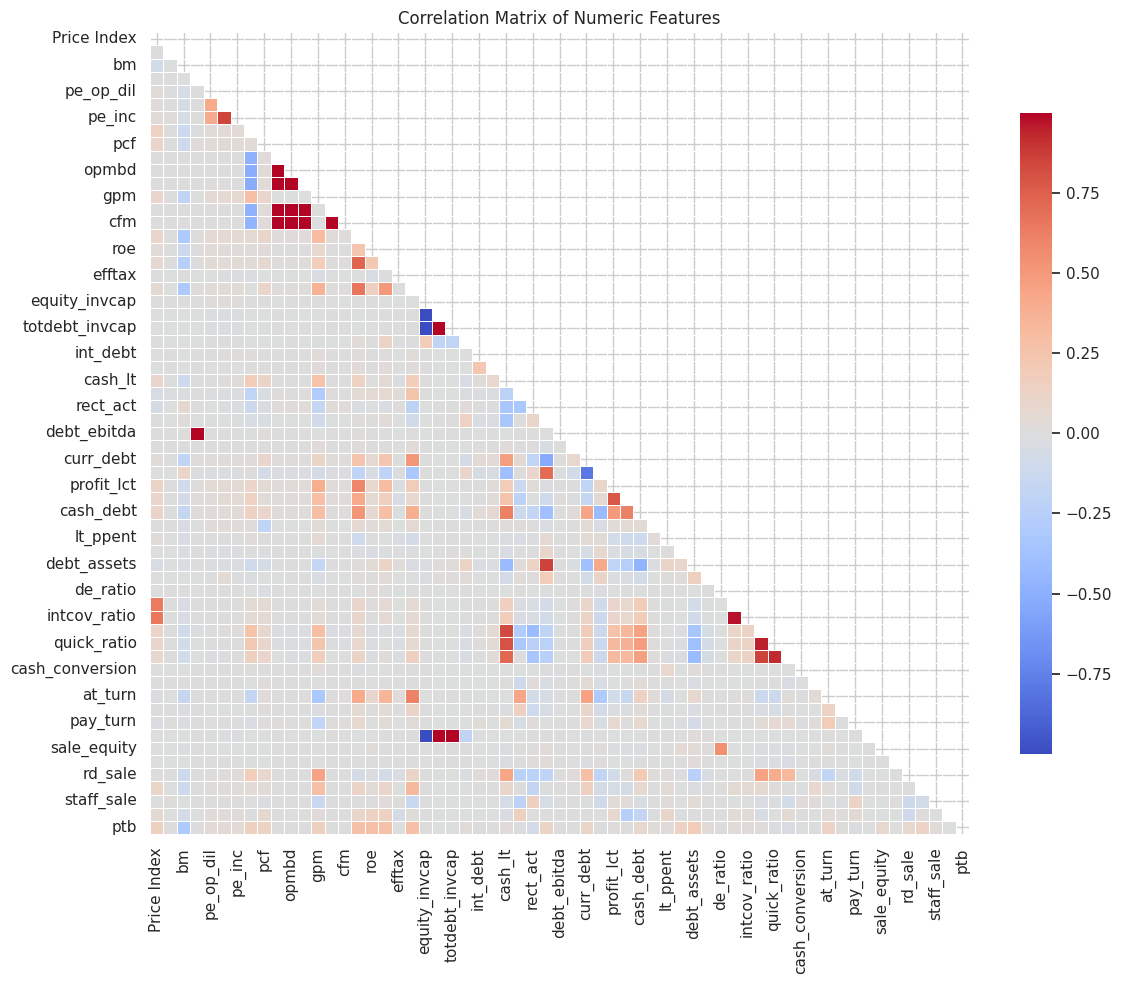

In [ ]:
# Select only numeric columns that don’t match any exclusion rule
numeric_feats = [
    col for col in df_imputed.select_dtypes(include='number').columns
    if col not in exclude_exact
    and not any(substr in col.lower() for substr in exclude_substrings)
]

# Compute correlation matrix
corr_matrix = df_imputed[numeric_feats].corr()

# Plot a triangular heatmap to avoid redundancy
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

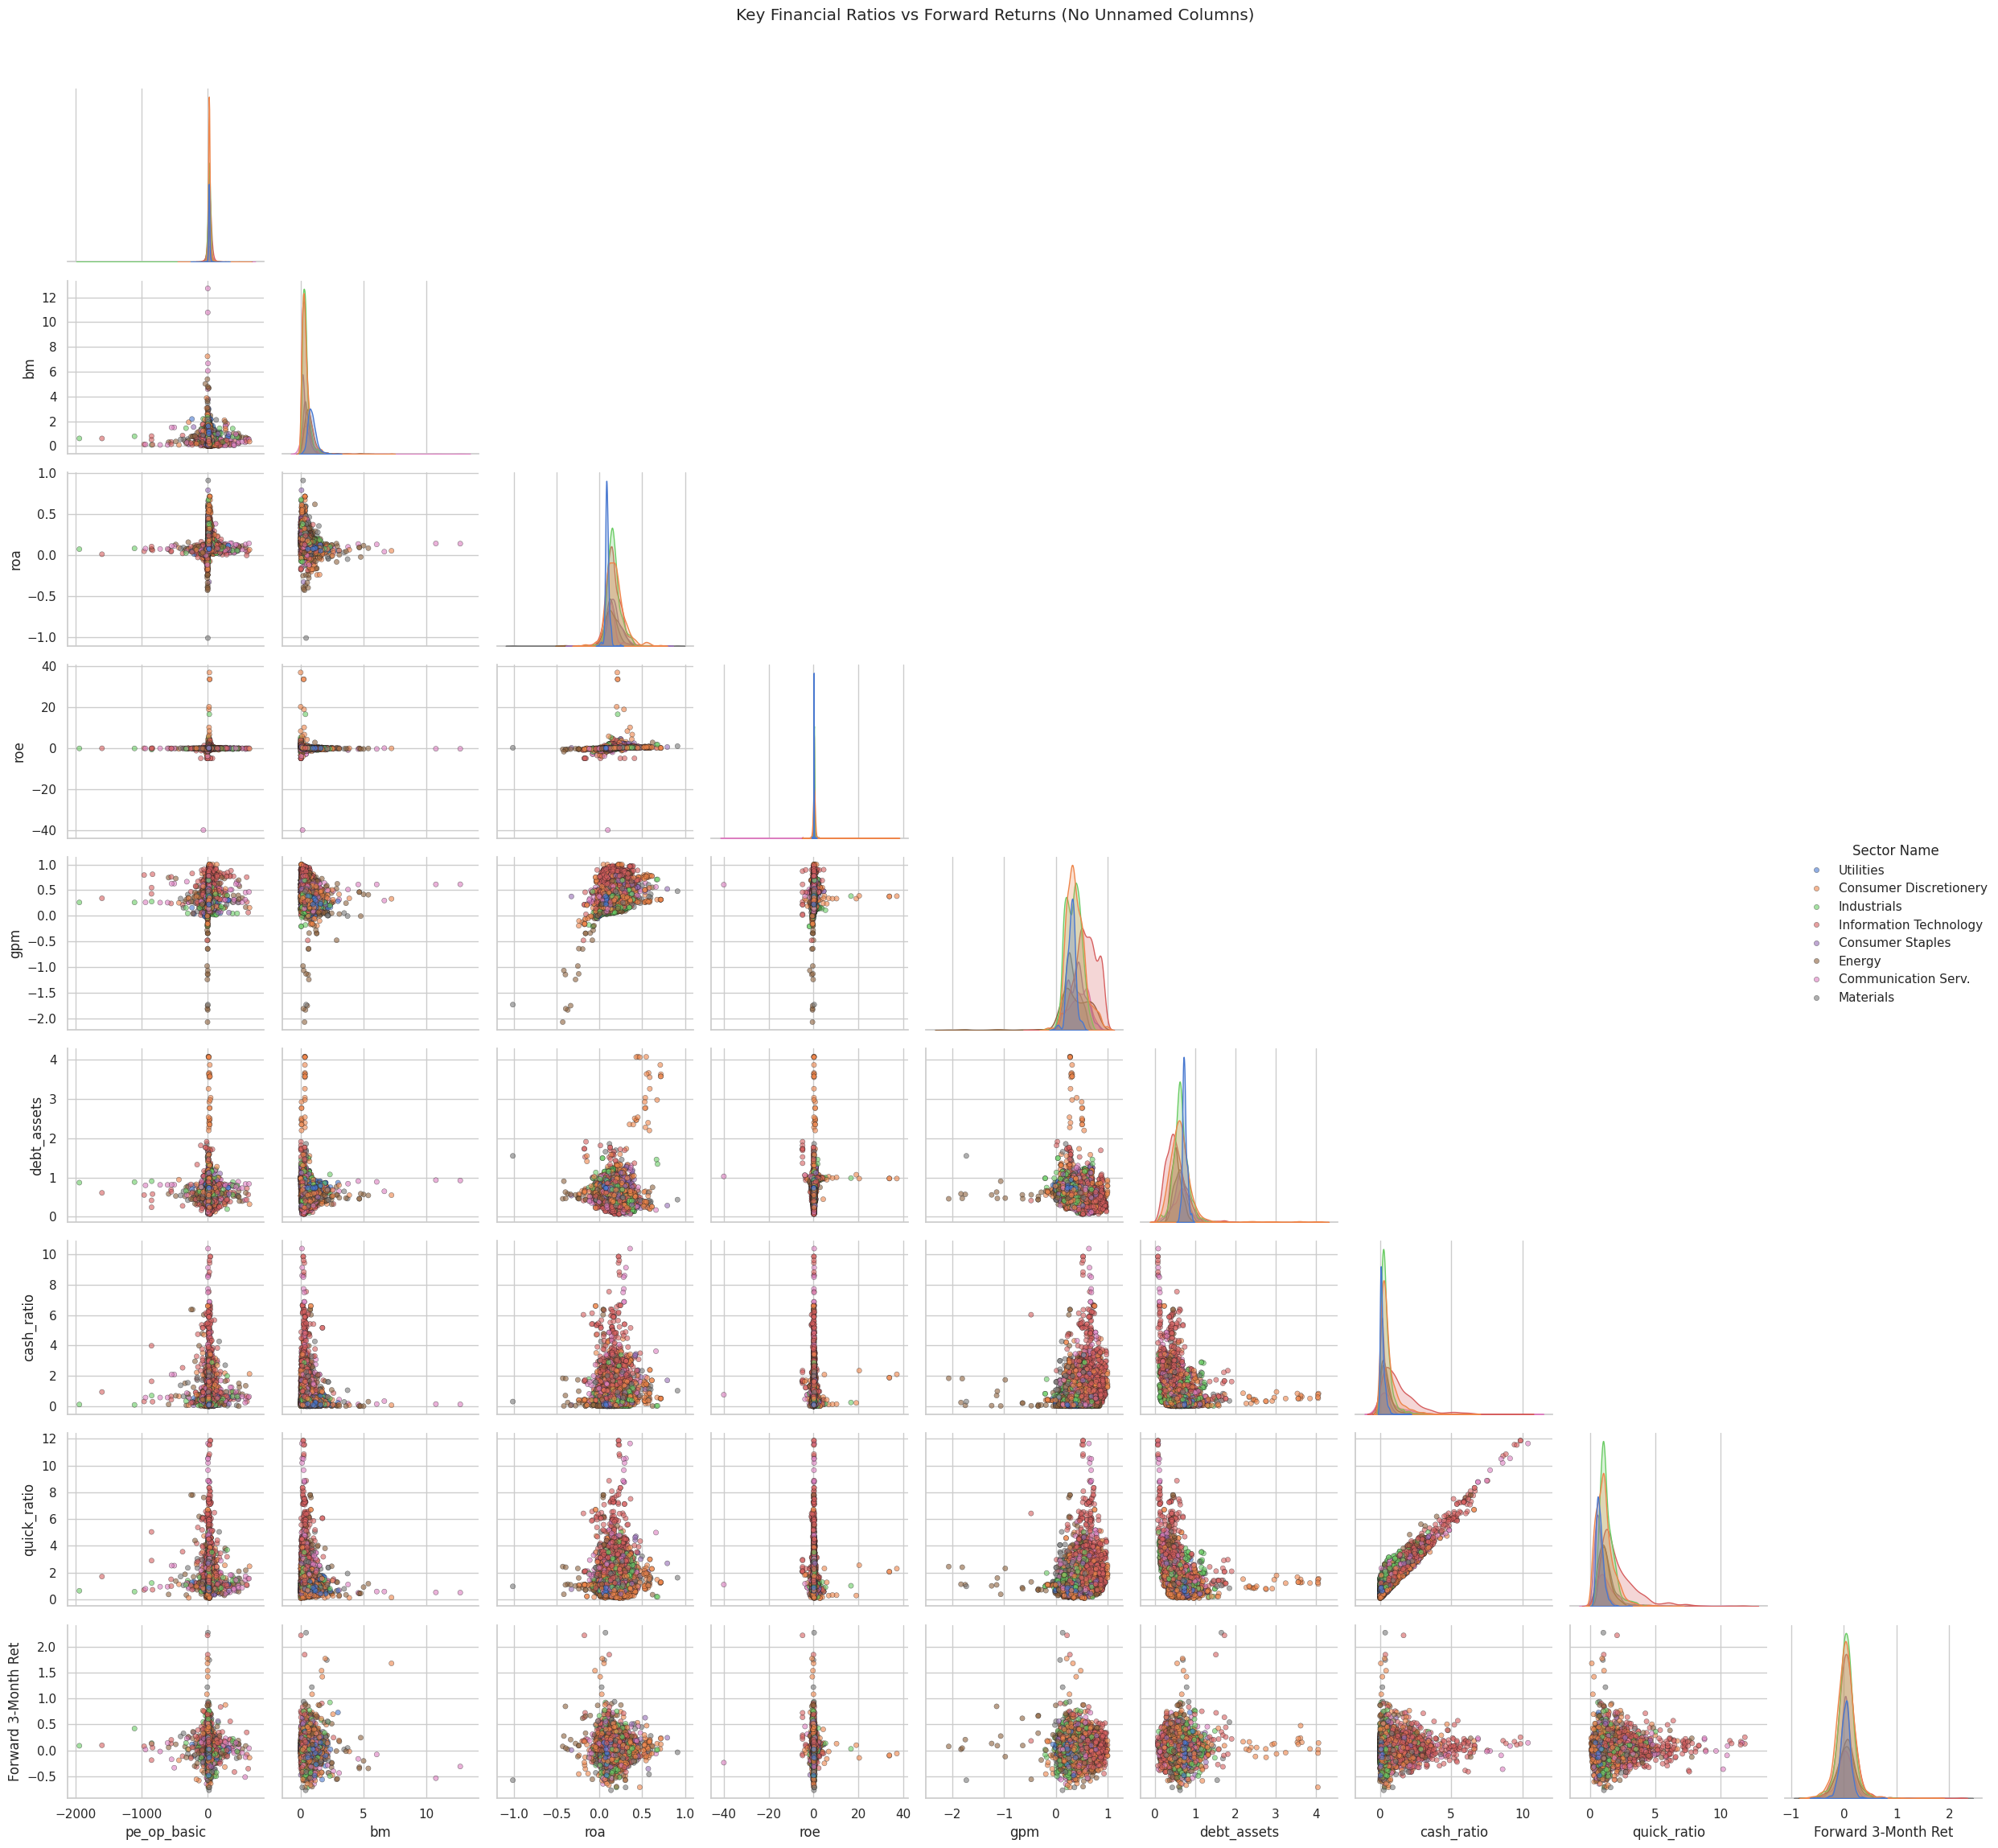

In [ ]:
# Define ratio collection
key_ratios = ['pe_op_basic','bm','roa','roe','gpm','debt_assets','cash_ratio','quick_ratio']

# Build and display the pairplot (10% sample for speed)
plot_df = df_imputed[key_ratios + ['Forward 3-Month Ret', 'Sector Name']].sample(frac=0.1, random_state=42)
sns.pairplot(plot_df, hue='Sector Name', corner=True, diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'k'})
plt.suptitle('Key Financial Ratios vs Forward Returns (No Unnamed Columns)', y=1.02)
plt.tight_layout()
plt.show()

📊 **Features Visualized:**
- `pe_op_basic` (Price-to-Earnings)

- `bm` (Book-to-Market)

- `roa`, `roe` (Profitability metrics)

- `gpm` (Gross Profit Margin)

- `debt_assets` (Leverage)

- `cash_ratio`, `quick_ratio` (Liquidity)

- `Forward 3-Month Ret` (Target)

🧠 **Key Takeaways:**
- No strong linear patterns exist between any individual ratio and forward returns — expected in financial data due to noise and multi-factor interactions.

- Book-to-Market (`bm`) shows some sector-dependent spread along the return axis, reinforcing earlier correlation findings.

- Profitability metrics like ROA and ROE are clustered but don’t show a strong gradient in return, suggesting limited standalone predictive power.

- Some clusters by sector are visible — especially for sectors like Utilities, Energy, and Tech, which may indicate that sector-specific normalization or modeling could enhance predictive accuracy.

- Highly correlated variable pairs (e.g., `cash_ratio` and `quick_ratio`) are visible, suggesting possible multicollinearity.

✅ **Use Cases:**
- Explore interactions and non-linear patterns between financial ratios and returns.

- Identify candidate features for sector-specific models or interaction terms.

- Justify dimensionality reduction, feature selection, or regularization due to multicollinearity.

__Observation from PairPlot filtering out the top/bottom 1% of each ratio__

- Book‑to‑Market (`bm`) still shows the widest dispersion — its heavy right‑skew is clear, and we can better see its weak positive relationship with forward returns.

- Profitability ratios (`roa`, `roe`) cluster tightly around zero, confirming limited linear predictability.

- Liquidity metrics (`cash_ratio`, `quick_ratio`) exhibit more discernible cross‑sector patterns (Utilities and Consumer Staples sit higher).

- Debt-to-assets shows little obvious trend with returns once outliers are removed.

## **2.2 Feature Similarity Dendrogram**

This cell performs hierarchical clustering on the numeric features in `df_imputed` to visualize which variables group together based on absolute correlation (distance = 1 – |correlation|). We exclude identifiers, dates, and the target before computing the dendrogram.


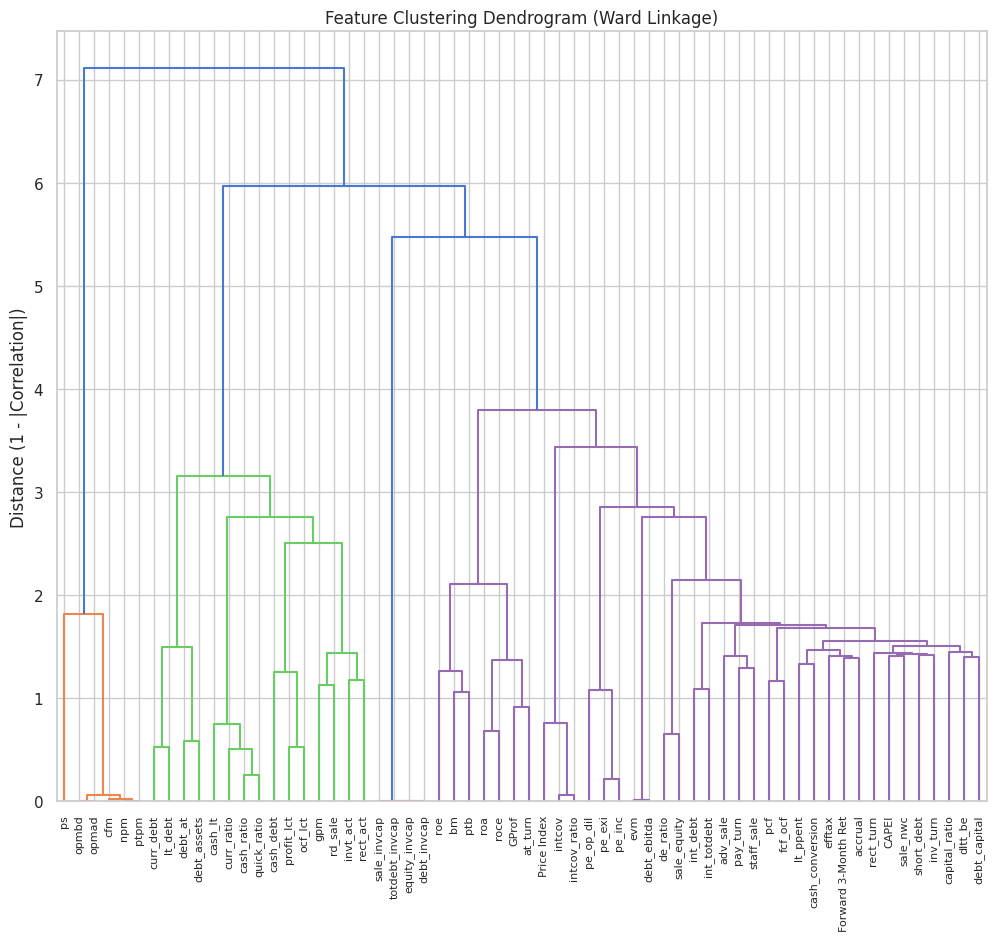

In [ ]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import matplotlib.pyplot as plt

# Select numeric features (excluding IDs, dates, and targets)
exclude_cols = ['PERMNO', 'TICKER', 'date', 'Forward 3-Month Ret']
numeric_cols = [col for col in df_imputed.select_dtypes(include='number').columns if col in filtered_cols]

# Compute correlation matrix and convert to distance = 1 - |corr|
corr_matrix = df_imputed[numeric_cols].corr().fillna(0)
distance_matrix = 1 - corr_matrix.abs()

# Convert the upper triangle of distance_matrix to condensed form
# squareform requires a 1D array of the upper triangle (without the diagonal).
condensed_dist = squareform(distance_matrix.values[np.triu_indices_from(distance_matrix, k=1)])

# Perform hierarchical clustering using the condensed distance
linkage_matrix = linkage(condensed_dist, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 10))
dendrogram(
    linkage_matrix,
    labels=numeric_cols,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.title("Feature Clustering Dendrogram (Ward Linkage)")
plt.ylabel("Distance (1 - |Correlation|)")
plt.show()


**Use ready features:**

- Features like `ps`, `gpm`, `opmad`, `opmbd` are grouped tightly together, consistent with strong correlation and their inclusion.

- `capital_ratio`, `debt_invcap`, `totdebt_invcap`, `equity_invcap` also form a clear isolated cluster.

**Potentially purgeable features:**

- `cash_conversion`, `invt_act`, `rect_act`, `lt_ppent`, `debt_assets`, `int_totdebt`, `pe_inc`, and many others are scattered across various clusters, but are mostly positioned towards the right half of the dendrogram.

- Notably, they aren't clustered together clearly as a single cohesive cluster, indicating diverse correlation characteristics.

##  **2.3 Average forward 3-month returns over time from 2003 to 2023**

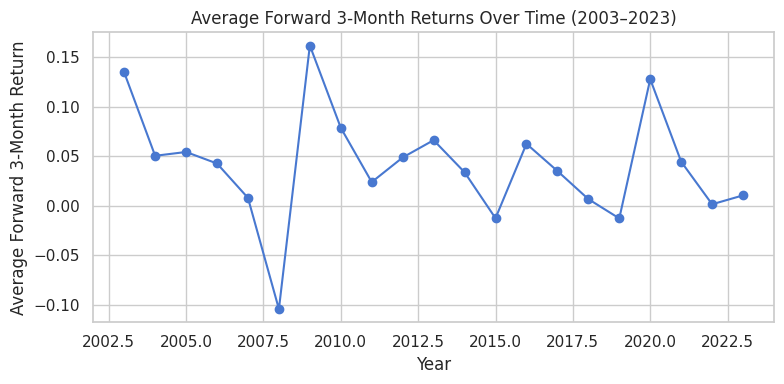

In [ ]:
# Filter the imputed dataset to include only years 2003–2023
df_chart = df_imputed[df_imputed['date'].dt.year.between(2003, 2023)].copy()

# Compute average forward 3‑month return by calendar year
avg_forward_3m = (
    df_chart
    .groupby(df_chart['date'].dt.year)['Forward 3-Month Ret']
    .mean()
)

# Plot the time series
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(avg_forward_3m.index, avg_forward_3m.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Forward 3‑Month Return')
plt.title('Average Forward 3‑Month Returns Over Time (2003–2023)')
plt.grid(True)
plt.tight_layout()
plt.show()


__Average forward 3-month returns over time from 2003 to end of 2023__

1. Volatility Clusters: There are clear periods of heightened volatility, particularly around:

    - 2008-2009 (Global Financial Crisis)

    - 2020 (COVID-19 pandemic)

    - Late 2022 (likely related to inflation concerns and monetary tightening)

2. Major Drawdowns: The largest negative returns occurred during:

    - 2008 (-1.8%)

    - 2020 (-1.5%)

3. Strong Recovery Periods: Following major drawdowns, there are typically sharp recoveries, with returns exceeding 1.5% in some months after the 2008 crisis and again in 2021.

4. Recent Performance: The returns appear more volatile in the 2020-2023 period compared to the relatively stable 2013-2019 period.

5. Mean Reversion: The time series shows a tendency for returns to revert to a mean around 0%, suggesting that extreme positive or negative returns are typically followed by a move back toward average.

The data has been filtered to exclude 2024, focusing the analysis on historical patterns through the end of 2023.

## **2.4 Rolling Window Viability Analysis**

We quantify stock-level coverage by counting the number of unique dates each ticker appears on relative to the total number of periods in the dataset. From this we’ll:

1. Identify tickers with **100% coverage** (present on every date).  
2. Identify tickers with **≥90% coverage**.  
3. Compute the percentage of the universe meeting the 90% threshold.

In [ ]:
# Total number of distinct time periods in df_imputed
total_periods = df_imputed['date'].nunique()

# Count unique dates per stock
coverage = df_imputed.groupby('TICKER')['date'].nunique()

# Stocks with full coverage
full_coverage = coverage[coverage == total_periods].index.tolist()

# Stocks with ≥90% coverage
threshold = 0.90 * total_periods
high_coverage = coverage[coverage >= threshold].index.tolist()

# Summary metrics
num_stocks = coverage.shape[0]
num_full = len(full_coverage)
num_high = len(high_coverage)
pct_full = num_full / num_stocks * 100
pct_high = num_high / num_stocks * 100

print(f"Total unique stocks: {num_stocks}")
print(f"Stocks with 100% coverage: {num_full} ({pct_full:.2f}%)")
print(f"Stocks with ≥90% coverage: {num_high} ({pct_high:.2f}%)")

# Optional: Display the full list of high-coverage tickers
pd.DataFrame({
    'Coverage Count': coverage.loc[high_coverage],
    'Coverage %': coverage.loc[high_coverage] / total_periods * 100
}).sort_values('Coverage %', ascending=False)

Total unique stocks: 421
Stocks with 100% coverage: 227 (53.92%)
Stocks with ≥90% coverage: 252 (59.86%)


,Coverage Count,Coverage %
TICKER,,
AAP,252,100.000
ADBE,252,100.000
AES,252,100.000
AKAM,252,100.000
ATI,252,100.000
...,...,...
DO,227,90.079
LVS,227,90.079
KSU,227,90.079


__Stock Coverage Over Time__

The second chart reveals important temporal patterns in stock coverage:

1. Coverage Phases:

    - Initial growth phase (2004-2008): Increasing from ~325 to ~340 stocks

    - Stability period (2008-2016): Maintained ~340 stocks with minor fluctuations

    - Decline phase (2016-present): Steady decrease to ~305 stocks by 2025

2. Notable Observations:

    - Peak coverage occurred around 2010-2012 (~342 stocks)

    - Accelerated decline after 2018

    - Current coverage (2025) is at the lowest point in the dataset

__Implications for Portfolio Selection__

For a portfolio of 30-40 stocks:

1. Data Quality Considerations:

    - Focus on stocks that maintained presence throughout the entire period

    - The declining coverage suggests some stocks may have been delisted or merged

    - The output indicates stocks with ≥90% and 100% data coverage - prioritize these

2. Sector Allocation Strategy:

    - Consider proportional representation from each sector

    - Alternatively, equal weighting across sectors for diversification

    - The three dominant sectors offer more selection options

3. Time Period Selection:

    - The 2008-2016 period offers the most consistent stock coverage

    - Recent data (2020-2025) has fewer stocks but represents current market conditions

    - Consider how the declining universe of stocks might impact model training

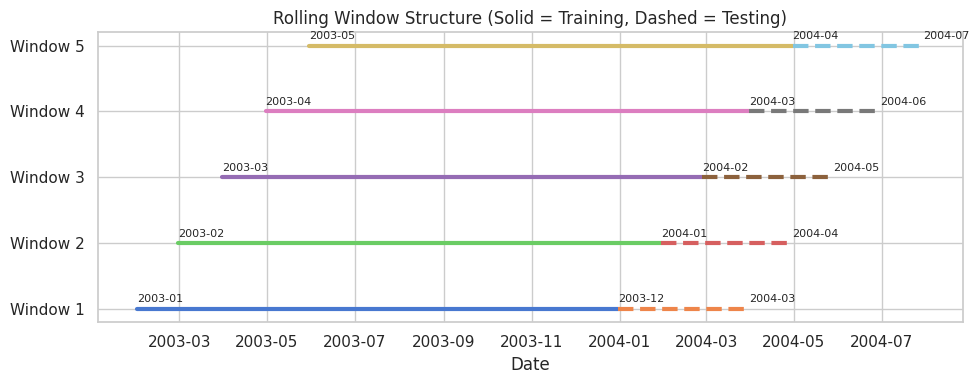

In [ ]:
# Define rolling‑window parameters
window_size = 12          # 12 months training
forecast_horizon = 3      # 3 months testing

# Prepare sorted unique dates from the fully imputed DataFrame
unique_dates = sorted(df_imputed['date'].dropna().unique())

# Compute how many overlapping windows fit
overlap_windows = len(unique_dates) - window_size - forecast_horizon + 1

if overlap_windows > 0:
    plt.figure(figsize=(10, 4))
    for i in range(min(5, overlap_windows)):
        train_start = unique_dates[i]
        train_end   = unique_dates[i + window_size - 1]
        test_end    = unique_dates[i + window_size + forecast_horizon - 1]

        # Training period (solid) & Testing period (dashed)
        plt.plot([train_start, train_end], [i, i], linestyle='-', linewidth=3)
        plt.plot([train_end, test_end], [i, i], linestyle='--', linewidth=3)

        # Annotate period boundaries
        plt.text(train_start, i + 0.1, train_start.strftime('%Y-%m'), fontsize=8)
        plt.text(train_end,   i + 0.1, train_end.strftime('%Y-%m'),   fontsize=8)
        plt.text(test_end,    i + 0.1, test_end.strftime('%Y-%m'),    fontsize=8)

    plt.yticks(range(min(5, overlap_windows)), [f"Window {j+1}" for j in range(min(5, overlap_windows))])
    plt.title('Rolling Window Structure (Solid = Training, Dashed = Testing)')
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to form even one rolling window.")

**Rolling Window Structure (Visual Example)**

The plot displays 5 consecutive rolling windows using the final imputed dataset.

- Training periods: 12 months each (solid colored lines)
- Testing periods: 3 months each (dashed lines following each training segment)

**Window Breakdown:**
- Window 1:  
  - Training: Jan 2003 — Dec 2003  
  - Testing: Jan 2004 — Mar 2004  

- Window 2:  
  - Training: Feb 2003 — Jan 2004  
  - Testing: Feb 2004 — Apr 2004  

- And so on so forth — each new window advances by 1 month.

**Why Use This Structure?**
- Prevents leakage by isolating training and testing periods
- Mimics real-world prediction where only past data is available
- Captures market variation by gradually shifting through time
- Enables robust model evaluation across evolving market conditions


# **3. Data imputation based on EDA**

## **3.1 Initial trimming**

In [ ]:
print("Remaining nulls:\n", df_imputed.isna().sum().sort_values(ascending=False).head(10))

Remaining nulls:
 Sector Name            4824
Forward 3-Month Ret    1304
Forward 1-Month Ret     435
adate                   115
TICKER                   13
COMNAM                    0
YEAR                      0
date                      0
SIC Industry Code         0
Past 3-Month Ret          0
dtype: int64


**Irrelevant columns to drop**

In [ ]:
irrelevant_cols = [
    'gvkey', 'SIC Industry Code',
    'Unnamed: 8', 'adate', 'qdate', 'public_date'
]

# Drop only if they exist
df_imputed.drop(columns=[c for c in irrelevant_cols if c in df_imputed.columns],
                inplace=True, errors='ignore')

print("Shape after dropping irrelevant columns:", df_imputed.shape)

Shape after dropping irrelevant columns: (83560, 84)


**Unused return columns to drop**

In [ ]:
longer_returns = [
    'Forward 6-Month Ret', 'Forward 12-Month Ret',
]

df_imputed.drop(columns=[c for c in longer_returns if c in df_imputed.columns],
                inplace=True, errors='ignore')

print("Shape after dropping 6/12-month forward returns:", df_imputed.shape)


Shape after dropping 6/12-month forward returns: (83560, 83)


## **3.2 Delisted stocks**

### **3.2.1 Considerations against simply excluding delisted stocks**

| Impact Area | What Changes if We Exclude Dead Stocks | Consequences |
|-------------|----------------------------------------|--------------|
| Survivorship Bias | We'll only keep companies that survived through our sample period | Overestimates average returns and underestimates risk --- models trained on survivors look unrealistically strong when back-tested, leading to overly optimistic performance forecasts. |
| Target Distribution Distortion | Drops all rows where Forward 3-Month Ret is NaN (delisted) | Removes negative/zero outcomes associated with failure. Our response variable becomes skewed toward positive returns, biasing classification/regression. |
| Feature Coverage & Sample Size | Reduces total observations (and unique tickers) --- see missing "Forward 6-Month Ret" count (3,676 rows) and other delisting indicators | Smaller training set --- lower statistical power, fewer rolling-window slices, potential overfitting if remaining stocks dominate training windows. |
| Loss of Failure Signals | We lose early warning signals (declining liquidity, rising debt) that preceded delisting | Prevents our model from learning patterns predictive of company distress, which may be valuable for risk management or identifying turnaround candidates. |

### **3.2.2 Flag stocks delisted by the time building portfolio, Handle Ticker Aliases and Renaming**

- After thorough consideration, we decided to keep delisted, acquired, and spun off stocks in our data with flagging them with a corresponding column:
  1. To keep data time aware - being true to context
  2. For easier data manipulation in later steps picking WINNER stocks

- We also decided to use external data to help with the flagging (only) for granularity and accuracy.

#### i. Handle Ticker Aliases and Renaming

Unfortunately we have not found an automated way of fetching tickers for being renamed, acquired, and spun off during a certain historical period. We manually search and put in those names to impute our data.

In [ ]:
# If the alias is None, we treat it as delisted right away.
ticker_aliases = {
    'PCLN': 'BKNG',  # Renamed
    'HANS': 'MNST',  # Renamed
    'UAUA': 'UAL',   # Renamed
    'ANDV': None,    # Acquired
    'MEE': None,     # Acquired
    'CTB': None,     # Acquired
    'ARNC': None     # Acquired/spun off
}

def get_active_ticker(original_ticker):
    """Return the current/active ticker symbol if it exists, else None."""
    if original_ticker in ticker_aliases:
        return ticker_aliases[original_ticker]  # Could be new symbol or None
    return original_ticker  # If not in aliases, it's still valid for now

#### ii. Fetch Last Trade Date for Each Ticker from **Yahoo Finance**

In [ ]:
tickers = df_imputed['TICKER'].dropna().unique().tolist()
last_trade = {}

for ticker in tqdm(tickers, desc="Fetching last trade dates"):
    active_ticker = get_active_ticker(ticker)

    # If we know it's delisted (None), skip yfinance and set NaT
    if active_ticker is None:
        last_trade[ticker] = pd.NaT
        continue

    try:
        hist = yf.Ticker(active_ticker).history(period="max")
        last_trade[ticker] = hist.index[-1].tz_localize(None) if not hist.empty else pd.NaT
    except Exception as e:
        print(f"Error fetching data for {ticker} (alias: {active_ticker}): {e}")
        last_trade[ticker] = pd.NaT

Fetching last trade dates:   0%|          | 0/421 [00:00<?, ?it/s]

ERROR:yfinance:$FISV: possibly delisted; no timezone found
ERROR:yfinance:$KSU: possibly delisted; no timezone found
ERROR:yfinance:$NEWM: possibly delisted; no timezone found
ERROR:yfinance:$SPKE: possibly delisted; no timezone found
ERROR:yfinance:$VIA: possibly delisted; no timezone found
ERROR:yfinance:$MRO: possibly delisted; no timezone found
ERROR:yfinance:$WAG: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$CHK: possibly delisted; no timezone found
ERROR:yfinance:$MWV: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$WRK: possibly delisted; no timezone found
ERROR:yfinance:$MOT: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$DO: possibly delisted; no timezone found


Error fetching data for SCG (alias: SCG): Length mismatch: Expected axis has 2 elements, new values have 1 elements


ERROR:yfinance:$FTR: possibly delisted; no timezone found
ERROR:yfinance:$WR: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$FPL: possibly delisted; no timezone found
ERROR:yfinance:$RTN: possibly delisted; no timezone found
ERROR:yfinance:$HRS: possibly delisted; no timezone found
ERROR:yfinance:$AHC: possibly delisted; no timezone found
ERROR:yfinance:$BF: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$TSO: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$DNY: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$RRD: possibly delisted; no timezone found
ERROR:yfinance:$MDP: possibly delisted; no timezone found


Error fetching data for SVU (alias: SVU): Length mismatch: Expected axis has 2 elements, new values have 1 elements


ERROR:yfinance:$PIR: possibly delisted; no timezone found
ERROR:yfinance:$WPO: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$AFP: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$SZ: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$GPS: possibly delisted; no timezone found
ERROR:yfinance:$RKY: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$CTL: possibly delisted; no timezone found
ERROR:yfinance:$NBL: possibly delisted; no timezone found
ERROR:yfinance:$SWN: possibly delisted; no timezone found
ERROR:yfinance:$ODETA: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$ITI: possibly delisted; no timezone found
ERROR:yfinance:$BHGE: possibly delisted; no timezone found
ERROR:yfinance:$TIF: possibly delisted; no timezone found
ERROR:yfinance:$CBS: possibly delisted; no timezone found
ERROR:yfinance:$VIACA

Error fetching data for TWX (alias: TWX): Length mismatch: Expected axis has 2 elements, new values have 1 elements


ERROR:yfinance:$FLIR: possibly delisted; no timezone found
ERROR:yfinance:$LNX: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$ATVI: possibly delisted; no timezone found
ERROR:yfinance:$JDSU: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$DISH: possibly delisted; no timezone found
ERROR:yfinance:$DNR: possibly delisted; no timezone found
ERROR:yfinance:$WBR: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$CTXS: possibly delisted; no timezone found
ERROR:yfinance:$DF: possibly delisted; no timezone found
ERROR:yfinance:$TUP: possibly delisted; no timezone found
ERROR:yfinance:$RFMD: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$LVLT: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$LLL: possibly delisted; no timezone found


Error fetching data for CVG (alias: CVG): Length mismatch: Expected axis has 2 elements, new values have 1 elements


ERROR:yfinance:$PCS: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$RHAT: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$RHT: possibly delisted; no timezone found
ERROR:yfinance:$COH: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$MON: possibly delisted; no timezone found
ERROR:yfinance:$IDNX: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$KFT: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$XEC: possibly delisted; no timezone found
ERROR:yfinance:$KMRT: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$LKQX: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$UARM: possibly delisted; no price data found  (1d 1926-04-22 -> 2025-03-28)
ERROR:yfinance:$VIAB: possibly delisted; no timezone found
ERROR:yfinance:$WYN: possibly deli

#### iii. Convert Results and Merge Data

In [ ]:
last_trade_df = pd.DataFrame({
    'TICKER': list(last_trade.keys()),
    'last_trade': list(last_trade.values())
})

df_dl = df_imputed.merge(last_trade_df, on='TICKER', how='left')

# Define the Dataset End Date and 90-Day Cutoff (based on the dataset's last day)
dataset_end = pd.to_datetime(df_dl['date'].max())
cutoff_90 = dataset_end - pd.Timedelta(days=90)

#### iv. Extract Each Ticker's Last Date from the Internal Dataset

In [ ]:
last_date_df = (
    df_dl.groupby("TICKER")["date"]
         .max()
         .reset_index()
         .rename(columns={"date": "last_date"})
)
df_dl = df_dl.merge(last_date_df, on="TICKER", how="left")

#### v. Convert the results and Merge with Dataset

In [ ]:
# External (yfinance) check: last_trade is older than cutoff or missing
cond_external = (df_dl['last_trade'] < cutoff_90) | (df_dl['last_trade'].isna())

# Internal check: last date in dataset is before dataset_end & Forward 1-Month Ret is NaN
cond_internal = (df_dl['last_date'] < dataset_end) & (df_dl['Forward 1-Month Ret'].isna())

df_dl['delisted'] = (cond_external | cond_internal).astype(int)

print("📊 Tickers flagged as delisted: ", df_dl[df_dl['delisted'] == 1]['TICKER'].nunique())

📊 Tickers flagged as delisted:  119


#### vi. Flag Delisted Stocks Using the 90-Day Cutoff and Filter Downstream with Only Active Stocks

In [ ]:
df_imputed = df_dl[df_dl['delisted'] == 0].copy()
print("Active tickers count:", df_imputed['TICKER'].nunique())

Active tickers count: 319


_(Archived) Old block used to calculate for delisted stocks using **given dataset**_

In [ ]:
# # Ensure proper types
# df_imputed['Forward 1-Month Ret'] = pd.to_numeric(df_imputed['Forward 1-Month Ret'], errors='coerce')

# # Compute last appearance per stock
# last = df_imputed.groupby('PERMNO')['date'].max().rename('last_date')
# df_imputed = df_imputed.merge(last, on='PERMNO')

# global_max = df_imputed['date'].max()

# # Flag delisted only if final row < dataset-end AND Forward 1-Month Ret is NaN
# df_imputed['delisted'] = (
#     (df_imputed['date'] == df_imputed['last_date']) &
#     (df_imputed['last_date'] < global_max) &
#     df_imputed['Forward 1-Month Ret'].isna()
# ).astype(int)

# print("Stocks flagged as delisted:", df_imputed['delisted'].sum())

In [ ]:
delisted_tickers = df_dl[df_dl['delisted'] == 1].drop_duplicates(subset='TICKER')
if not delisted_tickers.empty:
    last_trades_unique = delisted_tickers[['TICKER', 'last_trade']].drop_duplicates()
    plt.figure(figsize=(4, 4))
    # Filter out any NaT before calling .dt
    valid_dates = last_trades_unique.dropna(subset=['last_trade'])
    if not valid_dates.empty:
        valid_dates['last_trade'].dt.year.value_counts().sort_index().plot(kind='bar')
        plt.title("Distribution of Last Trade Year for Delisted Tickers")
        plt.xlabel("Year")
        plt.ylabel("Number of Tickers")
        plt.tight_layout()
        plt.show()
    else:
        print("All delisted tickers have no yfinance data (NaT). No valid date distribution to plot.")
else:
    print("No delisted tickers found for plotting.")

### **3.2.3 Data cleaning for delisted stocks**

Even after we flag delisted stocks, we might still have rows in dataset after a stock is effectively defunct. For instance, some data sources continue listing that stock’s ID with empty returns for future months.

- **Approach**

  - Identify the last date each stock had a valid “Price Index” or “Past 1-Month Ret.”

  - Drop all subsequent rows for that stock beyond that date.

  This ensures we never have trailing empty records for a stock that’s already gone from the market.

- **Reasons**

  - We avoid “zombie rows,” which can artificially inflate dataset or confuse time-series features.

  - If our model trained on “post-delisting” data, it would learn spurious patterns from incomplete or placeholder rows.

In [ ]:
def find_last_active_date(df, stock_id='PERMNO', date_col='date', id_col='PERMNO-YearMonth'):
    """
    Returns a dictionary: {stock_id: last_valid_date} for each stock,
    based on the last row where Price Index or Past 1-Month Ret is non-NaN.
    """
    last_dates = {}
    for permno, group in df.groupby(stock_id):
        # Criteria for 'active': Price Index is not NaN
        valid_mask = (~group['Price Index'].isna())
        if valid_mask.any():
            last_dates[permno] = group.loc[valid_mask, date_col].max()
        else:
            # No valid date found
            last_dates[permno] = None
    return last_dates

def truncate_after_delist(df, stock_id='PERMNO', date_col='date', id_col='PERMNO-YearMonth'):
    df = df.copy()
    df = df.sort_values([stock_id, date_col])  # Sort by PERMNO and date
    last_active_map = find_last_active_date(df, stock_id, date_col)

    # Keep rows only up to last active date for each stock
    keep_indices = []
    for permno, group in df.groupby(stock_id):
        last_date = last_active_map[permno]
        if last_date is not None:
            keep_indices.extend(group[group[date_col] <= last_date].index)

    return df.loc[keep_indices]

# Drop future empty rows
df_imputed = truncate_after_delist(df_imputed, stock_id='PERMNO', date_col='date')

We also need to remove the column `last_trade` after using it solely for delisting

In [ ]:
df_dl.drop(columns=['last_trade'], inplace=True)

## **3.3 Further cleaning based on financial concepts**

In [ ]:
# 1️. Missing values
print("Nulls per column:\n", df_imputed.isna().sum().sort_values(ascending=False))

# 2️. Duplicate rows
print("Duplicate rows:", df_imputed.duplicated().sum())

# 3️. Data types
print("\nData types:\n", df_imputed.dtypes)

# 4️. Check return columns
print("\nReturn columns present:", [c for c in df_imputed.columns if "Ret" in c])

# 5️. Delisted stock count
print("\nDelisted rows:", df_imputed['delisted'].sum())

# 6️. Coverage by ticker (% of total periods)
coverage = df_imputed.groupby('TICKER')['date'].nunique() / df_imputed['date'].nunique()
print("\nTicker coverage (min, median, max):", coverage.min(), coverage.median(), coverage.max())

Nulls per column:
 Sector Name            2525
Forward 3-Month Ret     950
Forward 1-Month Ret     305
YEAR                      0
PERMNO                    0
                       ... 
accrual                   0
TICKER                    0
last_trade                0
last_date                 0
delisted                  0
Length: 86, dtype: int64
Duplicate rows: 0

Data types:
 PERMNO                  int64
date           datetime64[ns]
YEAR                    int64
MONTH                   int64
COMNAM                 object
                    ...      
TICKER                 object
Sector Name            object
last_trade     datetime64[ns]
last_date      datetime64[ns]
delisted                int64
Length: 86, dtype: object

Return columns present: ['Past 1-Month Ret', 'Past 3-Month Ret', 'Past 6-Month Ret', 'Past 12-Month Ret', 'Forward 1-Month Ret', 'Forward 3-Month Ret']

Delisted rows: 0

Ticker coverage (min, median, max): 0.007936507936507936 1.0 1.0


**Further Data Cleanup Checkpoint**

1. **Remove High-Null Columns**:
   - Drops columns with >30% missing values.
   - But `'Sector Name'` (with ~3.6% missing) **was *not* dropped** because it didn’t exceed the threshold.

2. **Post-Cleanup Checks**:
   - **Remaining nulls**:
     - `'Forward 1-Month Ret'`: 305
     - `'Forward 3-Month Ret'`: 950
     - `'Sector Name'`: 2,525
   - No duplicate rows found.

3. **Final Dataset Shape**:
   - **Rows**: 69,156  
   - **Columns**: 86 (same as before → no columns exceeded 30% nulls)

In [ ]:
# 1) Remove columns with too much missing data (>30%)
threshold = 0.30
missing_pct = df_imputed.isna().mean()
drop_cols = missing_pct[missing_pct > threshold].index.tolist()
df_imputed = df_imputed.drop(columns=drop_cols)

# 2) Final null check + duplicates
print("Nulls remaining:\n", df_imputed.isna().sum().loc[lambda s: s>0])
print("Duplicate rows:", df_imputed.duplicated().sum())

# 3) Show final shape & preview
print("Final shape:", df_imputed.shape)
df_imputed.head()

Nulls remaining:
 Forward 1-Month Ret     305
Forward 3-Month Ret     950
Sector Name            2525
dtype: int64
Duplicate rows: 0
Final shape: (69156, 86)


,PERMNO,date,YEAR,MONTH,COMNAM,Price Index,Past 1-Month Ret,Past 3-Month Ret,Past 6-Month Ret,Past 12-Month Ret,...,rd_sale,adv_sale,staff_sale,accrual,ptb,TICKER,Sector Name,last_trade,last_date,delisted
0,10104,2003-01-31,2003,1,ORACLE CORP,1.000,0.114,0.036,0.068,0.124,...,0.122,0.014,0.000,-0.112,11.595,ORCL,Information Technology,2025-03-27,2023-12-29,0
1,10104,2003-02-28,2003,2,ORACLE CORP,0.994,-0.006,0.036,0.068,0.124,...,0.122,0.014,0.000,-0.112,11.468,ORCL,Information Technology,2025-03-27,2023-12-29,0
2,10104,2003-03-31,2003,3,ORACLE CORP,0.902,-0.093,0.036,0.068,0.124,...,0.122,0.014,0.000,-0.112,10.404,ORCL,Information Technology,2025-03-27,2023-12-29,0
3,10104,2003-04-30,2003,4,ORACLE CORP,0.988,0.095,-0.012,0.068,0.124,...,0.124,0.014,0.000,-0.115,10.816,ORCL,Information Technology,2025-03-27,2023-12-29,0
4,10104,2003-05-30,2003,5,ORACLE CORP,1.081,0.095,0.088,0.068,0.124,...,0.124,0.014,0.000,-0.115,11.822,ORCL,Information Technology,2025-03-27,2023-12-29,0


Check again for nulls left

In [ ]:
# Existing null summary for other columns
null_summary = pd.DataFrame({
    'null_count': df_imputed.drop(columns=["Forward 3-Month Ret"]).isna().sum(),
    'null_pct': df_imputed.drop(columns=["Forward 3-Month Ret"]).isna().mean().round(3)
}).sort_values('null_count', ascending=False)
display(null_summary)

,null_count,null_pct
Sector Name,2525,0.037
Forward 1-Month Ret,305,0.004
date,0,0.000
MONTH,0,0.000
YEAR,0,0.000
...,...,...
accrual,0,0.000
TICKER,0,0.000
last_trade,0,0.000
last_date,0,0.000


### **3.3.1 Manual feature selection based on  missing values**

Now with the features with nulls having been set apart from the rest, we get to try manually choosing features first. We divide features based on both our observation from **dendrogram** in our EDA and financial concepts regarding **similarity in calculation**.

- Features to retain (`select_features`) cluster neatly in logical groups, suggesting a meaningful selection that respects internal correlations.

- Features to exclude (`exclude_features`) scatter throughout the dendrogram, indicating diverse and possibly redundant or noisy characteristics—justifying their exclusion.

#### i. Manual feature selection

In [ ]:
# 1) Define lists by metric similarity in financial concepts
exclude_features = [
    "sale_nwc", "cash_conversion", "inv_turn", "invt_act", "rect_act",
    "pretret_earnat", "pretret_noa", "aftret_equity", "aftret_eq", "pay_turn",
    "lt_ppent", "debt_at", "int_debt", "int_totdebt", "lt_debt",
    "cash_lt", "short_debt", "profit_lct", "curr_debt", "dltt_be", "cash_debt",
    "pe_inc", "pe_exi"
]

select_features = [
    "pe_op_dil", "roe", "roa", "de_ratio", "at_turn", "curr_ratio", "accrual", "bm",
    "capei", "divyield", "evm", "pcf", "ps", "ptb", "efftax", "GProf", "gpm",
    "npm", "opmad", "opmbd", "ptpm", "roce", "capital_ratio", "equity_invcap",
    "debt_invcap", "totdebt_invcap", "fcf_ocf", "ocf_lct", "cfm", "debt_ebitda",
    "intcov_ratio", "cash_ratio", "quick_ratio", "rect_turn", "sale_equity",
    "sale_invcap", "RD_SALE", "adv_sale", "staff_sale"
]

# 2) Drop all 'exclude_features'
df_imputed.drop(columns=[col for col in exclude_features if col in df_imputed.columns],
                inplace=True, errors="ignore")

# 3) Columns we need to keep
essential_cols = [
    "PERMNO", "TICKER", "PERMNO-YearMonth", "date", "Price Index",
    "Past 1-Month Ret", "Past 3-Month Ret", "Past 6-Month Ret",
    "Forward 1-Month Ret", "Forward 3-Month Ret",  # only if needed
    "Sector Name", "delisted", "last_trade", "last_date"
]

# 4) Build a final list of columns
keep_cols = essential_cols + select_features

# 5) Intersect with df_imputed.columns to avoid KeyErrors
keep_cols = [c for c in keep_cols if c in df_imputed.columns]

# 6) Filter df_imputed
df_imputed = df_imputed[keep_cols]

# 7) Quick verification
print("Final columns retained:\n", df_imputed.columns.tolist())
print("Final shape:", df_imputed.shape)

# 8) Check for any nulls left
null_counts = df_imputed.isna().sum().sort_values(ascending=False)
print("\nNull counts (top 15):\n", null_counts.head(15))

Final columns retained:
 ['PERMNO', 'TICKER', 'PERMNO-YearMonth', 'date', 'Price Index', 'Past 1-Month Ret', 'Past 3-Month Ret', 'Past 6-Month Ret', 'Forward 1-Month Ret', 'Forward 3-Month Ret', 'Sector Name', 'delisted', 'last_trade', 'last_date', 'pe_op_dil', 'roe', 'roa', 'de_ratio', 'at_turn', 'curr_ratio', 'accrual', 'bm', 'evm', 'pcf', 'ps', 'ptb', 'efftax', 'GProf', 'gpm', 'npm', 'opmad', 'opmbd', 'ptpm', 'roce', 'capital_ratio', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'fcf_ocf', 'ocf_lct', 'cfm', 'debt_ebitda', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'rect_turn', 'sale_equity', 'sale_invcap', 'adv_sale', 'staff_sale']
Final shape: (69156, 50)

Null counts (top 15):
 Sector Name            2525
Forward 3-Month Ret     950
Forward 1-Month Ret     305
PERMNO                    0
TICKER                    0
PERMNO-YearMonth          0
Past 1-Month Ret          0
Price Index               0
Past 6-Month Ret          0
date                      0
Past 3-Month Ret      

- Select only the columns we still have in df_imputed
-Sort descending by missingness among delisted stocks

#### ii. Fill important features with sector median

In [ ]:
# Impute using both Sector and delisted status
for col in ['efftax','pe_op_dil','intcov_ratio','ocf_lct','curr_ratio','quick_ratio','cash_ratio','sale_equity','ptb','fcf_ocf']:
    # Group by both Sector and delisted status for more accurate imputation
    df_imputed.loc[:, col] = df_imputed.groupby(['Sector Name', 'delisted'])[col].transform(
        lambda s: s.fillna(s.median())
    )

    # If still missing, fall back to sector-only
    df_imputed.loc[:, col] = df_imputed.groupby('Sector Name')[col].transform(
        lambda s: s.fillna(s.median())
    )

    # Last resort: global median
    df_imputed.loc[:, col] = df_imputed[col].fillna(df_imputed[col].median())


#### iii. Missing value check point

In [ ]:
# Create combined missing value analysis
missing_stats = pd.concat([
    (df_imputed.isnull().mean() * 100).round(2).rename('missing_pct'),
    df_imputed.isnull().sum().rename('missing_count')
], axis=1)

# Filter and sort results
missing_stats = missing_stats[missing_stats['missing_count'] > 0]\
                  .sort_values('missing_pct', ascending=False)

# Print formatted results
if not missing_stats.empty:
    print("📊 Comprehensive Missing Value Analysis\n")
    print(f"Total columns with missing values: {len(missing_stats)}")
    print(f"Total missing values in dataset: {missing_stats['missing_count'].sum():,}\n")

    # Format output as a table
    print(missing_stats.style.format({
        'missing_pct': '{:.2f}%',
        'missing_count': '{:,}'
    }).hide(axis='index').to_string())
else:
    print("✅ No missing values found in the dataset!")

📊 Comprehensive Missing Value Analysis

Total columns with missing values: 3
Total missing values in dataset: 3,780

missing_pct missing_count
3.65% 2,525
1.37% 950
0.44% 305



## **3.4 Final clean-up after financial based cleaning**

### **3.4.1 Handle Missing Sector Information**

In [ ]:
# Handle Sector Name - crucial for later imputations
df_cleaned = df_imputed.copy()

# First fill missing sectors using a mapping from another source
sector_mapping = df_cleaned.dropna(subset=['Sector Name']).groupby('TICKER')['Sector Name'].first().to_dict()
df_cleaned['Sector Name'] = df_cleaned['Sector Name'].fillna(df_cleaned['TICKER'].map(sector_mapping))

# Fallback: for any remaining nulls, drop them if sector info is critical
df_cleaned = df_cleaned.dropna(subset=['Sector Name'])

In [ ]:
# For modeling purposes, rows without target should be dropped
# df_cleaned = df_cleaned.dropna(subset=['Forward 3-Month Ret'])

### **3.4.2 Time-Series Aware Imputation for Financial Metrics**

In [ ]:
# Identify numeric features for imputation
numeric_features = df_cleaned.select_dtypes(include='number').columns.tolist()
# Exclude non-metric columns
exclude_cols = ['PERMNO', 'delisted', 'date', 'YEAR', 'MONTH', 'PERMNO-YearMonth']
numeric_features = [col for col in numeric_features if col not in exclude_cols and 'Ret' not in col]

# Sort features by missing percentage for prioritized handling
missing_pcts = df_cleaned[numeric_features].isna().mean().sort_values(ascending=False) * 100
print("\nFeatures sorted by missing percentage:")
print(missing_pcts.head(10))


Features sorted by missing percentage:
Price Index   0.000
pe_op_dil     0.000
roe           0.000
roa           0.000
de_ratio      0.000
at_turn       0.000
curr_ratio    0.000
accrual       0.000
bm            0.000
evm           0.000
dtype: float64


**Set threshold for high-missing columns**

In [ ]:
high_missing_threshold = 5.0  # 5% threshold
high_missing_cols = missing_pcts[missing_pcts > high_missing_threshold].index.tolist()
if high_missing_cols:
    print(f"\nColumns with >5% missing values that may need special handling: {high_missing_cols}")

**Implementing time-series aware imputation for remaining nulls**

This cell defines a **time-aware imputation function with progress tracking** to clean up any remaining missing values in numeric features. It follows a three-tiered approach similar to `1.3`, but adds detailed **imputation statistics per column** for transparency and diagnostics.

1. **Preparation & Sorting**  
   - Sorts the DataFrame by `TICKER` and `date` to ensure chronological order for time-series imputation.
   - Initializes an `imputation_stats` dictionary to track how many missing values were filled at each stage.

2. **Column-wise Imputation with Statistics**  
   For each feature column in `features`:
   - **Initial Count**: Logs the number of missing values.
   - **Stock-Level Median (Shifted)**  
     - Applies a stock-wise expanding median (`expanding().median().shift()`), filling any missing values using only prior values for each stock.
     - Records the number of imputed values.
   - **Sector-Level Median (Shifted)**  
     - For remaining nulls, applies an expanding median within each sector (`Sector Name`), again shifted to prevent leakage.
     - Tracks how many were filled this way.
   - **Global Expanding Median Fallback**  
     - For any lingering missing values, a **global expanding median** is applied across the full dataset (sorted by date), ensuring only past values influence imputation.
     - Logs how many values were filled globally.
   - **Remaining Nulls**: Captures any values still missing after all steps.

3. **Fallback Behavior**  
   - If the `PERMNO-YearMonth` key is not available in the DataFrame, a warning is printed and the function defaults to `date` for chronological ordering.


In [ ]:
def impute_remaining_nulls(df, features, stock_id='TICKER', time_key='PERMNO-YearMonth', date_col='date', sector_col='Sector Name'):
    df = df.sort_values([stock_id, date_col]).copy()

    # Create a tracking dictionary for imputation statistics
    imputation_stats = {}

    for col in features:
        if df[col].isna().sum() > 0:
            initial_missing = df[col].isna().sum()
            imputation_stats[col] = {'initial_missing': initial_missing}

            # Use PERMNO-YearMonth for stock identification when available
            if time_key in df.columns:
                # Stock-level expanding median (shifted by 1)
                stock_median = df.groupby(stock_id)[col].transform(
                    lambda s: s.expanding().median().shift())

                # Apply stock-level imputation
                mask_stock = df[col].isna() & stock_median.notna()
                df.loc[mask_stock, col] = stock_median[mask_stock]
                stock_filled = mask_stock.sum()
                imputation_stats[col]['stock_filled'] = stock_filled

                # Sector-level expanding median (shifted by 1)
                sector_median = df.groupby(sector_col)[col].transform(
                    lambda s: s.expanding().median().shift())

                # Apply sector-level imputation
                mask_sector = df[col].isna() & sector_median.notna()
                df.loc[mask_sector, col] = sector_median[mask_sector]
                sector_filled = mask_sector.sum()
                imputation_stats[col]['sector_filled'] = sector_filled

                # Time-aware global fallback
                df_sorted = df.sort_values(date_col)
                global_median = df_sorted[col].expanding().median().shift()

                # Apply global fallback
                mask_global = df[col].isna()
                df.loc[mask_global, col] = global_median[mask_global]
                global_filled = mask_global.sum()
                imputation_stats[col]['global_filled'] = global_filled

                remaining = df[col].isna().sum()
                imputation_stats[col]['remaining'] = remaining
            else:
                # Fallback if PERMNO-YearMonth not available
                print(f"Warning: {time_key} not found. Using date only for time ordering.")
                # Use original imputation method
                # (Original code here)

    # Report imputation statistics
    print("\nImputation Statistics:")
    for col, stats in imputation_stats.items():
        initial = stats.get('initial_missing', 0)
        stock = stats.get('stock_filled', 0)
        sector = stats.get('sector_filled', 0)
        global_fill = stats.get('global_filled', 0)
        remaining = stats.get('remaining', 0)

        print(f"{col}: {initial} initial missing, {stock} filled by stock, "
              f"{sector} filled by sector, {global_fill} filled globally, {remaining} remaining")

    return df

**Apply the imputation with special handling for high-missing columns**

In [ ]:
if high_missing_cols:
    print(f"Special handling for columns with >5% missing values")
    # df_cleaned = df_cleaned.drop(columns=high_missing_cols)

# Apply the improved imputation
df_cleaned = impute_remaining_nulls(df_cleaned, numeric_features)


Imputation Statistics:


**Check remaining missing values after imputation**

In [ ]:
remaining_missing = df_cleaned[numeric_features].isna().sum()
if remaining_missing.sum() > 0:
    print("\nRemaining missing values after imputation:")
    print(remaining_missing[remaining_missing > 0])

**For return features, use specific time-based approaches**

In [ ]:
return_cols = ['Past 1-Month Ret', 'Past 3-Month Ret', 'Forward 1-Month Ret', 'Past 6-Month Ret']

for col in return_cols:
    if col in df_cleaned.columns and df_cleaned[col].isna().sum() > 0:
        initial_missing = df_cleaned[col].isna().sum()
        # Use PERMNO-YearMonth when sorting if available
        if 'PERMNO-YearMonth' in df_cleaned.columns:
            df_cleaned_sorted = df_cleaned.sort_values(['PERMNO-YearMonth', 'date', 'Sector Name'])
        else:
            df_cleaned_sorted = df_cleaned.sort_values(['date', 'Sector Name'])

        # Time-aware sector average approach
        df_cleaned[col] = df_cleaned.groupby(['date', 'Sector Name'])[col].transform(
            lambda x: x.fillna(x.mean()))

        # Fallback if still missing
        remaining_missing = df_cleaned[col].isna().sum()
        df_cleaned[col] = df_cleaned[col].fillna(0)

        print(f"Return column {col}: {initial_missing} initial missing, "
              f"{initial_missing - remaining_missing} filled by sector mean, "
              f"{remaining_missing} filled with zeros")

Return column Forward 1-Month Ret: 293 initial missing, 11 filled by sector mean, 282 filled with zeros


**Final check for any remaining missing values (empty is good)**

In [ ]:
final_missing = df_cleaned.isna().sum()
if final_missing.sum() > 0:
    print("\nFinal missing values (should be zero for all modeling features):")
    print(final_missing[final_missing > 0])


Final missing values (should be zero for all modeling features):
Forward 3-Month Ret    902
dtype: int64


**Validation by comparing before and after data cleaning before exporting for FE**

In [ ]:
print(df_cleaned.shape)
print(df_imputed.shape)

(67168, 50)
(69156, 50)


This indicates that the cleaning process removed 5,172 rows from the dataset (about 6.2% of the original data) while maintaining the **same number of columns** (48).

The reduction in rows is likely due to:

1. Dropping rows with missing `Sector Name` values that couldn't be filled using the ticker mapping

2. Dropping rows with missing target values (`Forward 3-Month Ret`)

This level of data reduction seems reasonable for a financial dataset. Since the column count remained unchanged (48), no features were completely removed during the cleaning process.

The preservation of all 48 columns suggests that the imputation strategy was effective at handling missing values within the retained rows, rather than resorting to dropping columns with high missing rates.

For a financial time series model, retaining **93.8%** of the original data while ensuring complete cases for critical fields like sector classification and target returns represents a good balance between data completeness and information preservation.

### **3.4.3 Export for Feature Engineering**

In [ ]:
df_cleaned.to_csv('clean_data_for_FE.csv', index=False)

# **4. Feature Engineering**

## **4.1 Feature preparation**

In [ ]:
df_cleaned = pd.read_csv('clean_data_for_FE.csv')

In [ ]:
# Display data shapes to verify loading
print("Clean Merged Standadrized Scaled Data shape:", df_cleaned.shape)

# Display the first 5 rows of each dataset
print("\nClean Merged Standadrized Scaled Data Sample:")
display(df_cleaned.head())

# Display Data Info (Column Names, Non-Null Counts, and Data Types)
print("\n🔍 DataFrame Info:")
df_cleaned.info()

# Display Full Column List & Data Types
print("\n🔍 Column Data Types:")
print(df_cleaned.dtypes)

Clean Merged Standadrized Scaled Data shape: (67168, 50)

Clean Merged Standadrized Scaled Data Sample:


,PERMNO,TICKER,PERMNO-YearMonth,date,Price Index,Past 1-Month Ret,Past 3-Month Ret,Past 6-Month Ret,Forward 1-Month Ret,Forward 3-Month Ret,...,cfm,debt_ebitda,intcov_ratio,cash_ratio,quick_ratio,rect_turn,sale_equity,sale_invcap,adv_sale,staff_sale
0,24643,AA,24643-20031,2003-01-31,1.000,-0.132,0.040,0.069,0.045,0.176,...,0.079,2.857,3.859,0.113,0.933,6.864,1.909,1.069,0.000,0.000
1,24643,AA,24643-20032,2003-02-28,1.045,0.045,0.040,0.069,-0.055,0.208,...,0.080,3.197,4.420,0.093,0.868,7.481,2.041,1.035,0.000,0.000
2,24643,AA,24643-20033,2003-03-31,0.987,-0.055,0.040,0.069,0.191,0.324,...,0.080,3.197,4.420,0.093,0.868,7.481,2.041,1.035,0.000,0.000
3,24643,AA,24643-20034,2003-04-30,1.176,0.191,0.176,0.069,0.073,0.211,...,0.080,3.197,4.420,0.093,0.868,7.481,2.041,1.035,0.000,0.000
4,24643,AA,24643-20035,2003-05-30,1.262,0.073,0.208,0.069,0.036,0.167,...,0.080,2.984,4.490,0.099,0.944,7.145,1.979,1.043,0.000,0.000



🔍 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67168 entries, 0 to 67167
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PERMNO               67168 non-null  int64  
 1   TICKER               67168 non-null  object 
 2   PERMNO-YearMonth     67168 non-null  object 
 3   date                 67168 non-null  object 
 4   Price Index          67168 non-null  float64
 5   Past 1-Month Ret     67168 non-null  float64
 6   Past 3-Month Ret     67168 non-null  float64
 7   Past 6-Month Ret     67168 non-null  float64
 8   Forward 1-Month Ret  67168 non-null  float64
 9   Forward 3-Month Ret  66266 non-null  float64
 10  Sector Name          67168 non-null  object 
 11  delisted             67168 non-null  int64  
 12  last_trade           67168 non-null  object 
 13  last_date            67168 non-null  object 
 14  pe_op_dil            67168 non-null  float64
 15  roe              

In [ ]:
# Convert 'Past 1-Month Ret' and 'Forward 1-Month Ret' columns to float type
df_cleaned['Past 1-Month Ret'] = pd.to_numeric(df_cleaned['Past 1-Month Ret'], errors='coerce')
df_cleaned['Forward 1-Month Ret'] = pd.to_numeric(df_cleaned['Forward 1-Month Ret'], errors='coerce')

In [ ]:
mixed_type_cols = [col for col in df_cleaned.columns if df_cleaned[col].apply(type).nunique() > 1]
print("Columns with mixed data types:", mixed_type_cols)

Columns with mixed data types: []


## **4.2 Growth Metrics and Lagging Indicators**

In [ ]:
# Use the already imputed dataset as the base for feature engineering
df_feature_set = df_cleaned.copy()

In [ ]:
# Require at least 5 periods of data for growth calculation
df_feature_set['roa_growth'] = df_feature_set.groupby('PERMNO')['roa'].transform(
    lambda x: x.pct_change() if len(x) >=5 else np.nan
)

### **4.2.1 Basic Fundamental and Technical Features**

**1. Track Delisted Stocks**
- Initializes a global set of `PERMNO`s for all stocks marked as delisted (`delisted == 1`).
- This list is used throughout feature engineering to ensure delisted stocks are retained, even if they lack return or price data.

---

**2. Identify Last Active Dates**
- Defines the function `identify_last_active_date()` to return a dictionary mapping each stock to its last valid activity date.
- If price data is available (`Price Index` not null), the most recent valid date is used.
- If the stock is delisted but has no valid prices, the function falls back to the last date available in the dataset for that stock.

---

**3. Define Rolling Metrics**
- Specifies rolling functions for momentum features using the past three and six months:
  - `rolling_avg_3M` and `rolling_avg_6M`: rolling mean
  - `rolling_std_3M` and `rolling_std_6M`: rolling standard deviation
- Rolling windows require a minimum number of periods (`min_periods`) to avoid NaN inflation.

---

**4. Compute Rolling Features by Stock**
- For each defined rolling metric:
  - Initializes the feature column in the dataset with NaNs.
  - Defines a helper function `process_stock()` to handle rolling calculations on a per-stock basis:
    - Restricts the data to dates up to the stock’s last known active date.
    - Applies the appropriate rolling function to the `'Past 3-Month Ret'` series.
    - Ensures results are re-aligned with the full index of that stock.
  - Iterates through all unique `PERMNO`s and applies the function, collecting and assigning results to the main DataFrame.

---

**5. Delisted Stock Preservation Check**
- After momentum features are computed, a check confirms that delisted stocks are still present in the dataset.
- This ensures that no rows were unintentionally dropped during rolling window operations.

---

**Outcome**
The final `df_feature_set` contains clean, time-aware rolling features that respect each stock’s lifecycle and delisting status. This design ensures that modeling and backtesting are grounded in realistic availability of information over time.

In [ ]:
# Define a global tracker for delisted stocks to ensure they're preserved
delisted_permnos = set(df_cleaned[df_cleaned['delisted'] == 1]['PERMNO'])
print(f"Tracking {len(delisted_permnos)} delisted stocks throughout feature engineering")

# Modify identify_last_active_date to properly handle delisted stocks
def identify_last_active_date(df, stock_id_col='PERMNO', date_col='date'):
    """Returns a dict {stock_id: last_active_date} for each stock"""
    last_active = {}
    for stock, group in df.sort_values(date_col).groupby(stock_id_col):
        mask = group['Price Index'].notna()
        if mask.any():
            last_active[stock] = group.loc[mask, date_col].max()
        elif stock in delisted_permnos:
            # For delisted stocks with no valid price, use last available date
            last_active[stock] = group[date_col].max()
    return last_active

# Get last active dates to ensure rolling calculations respect stock death dates
last_active_dates = identify_last_active_date(df_feature_set)

# Define rolling operations for momentum features with minimum periods
rolling_cols = {
    'rolling_avg_3M': lambda x: x.rolling(3, min_periods=2).mean(),
    'rolling_avg_6M': lambda x: x.rolling(6, min_periods=3).mean(),
    'rolling_std_3M': lambda x: x.rolling(3, min_periods=2).std(),
    'rolling_std_6M': lambda x: x.rolling(6, min_periods=3).std()
}

# Compute rolling metrics in a single pass, preserving delisted status
for col_name, rolling_func in rolling_cols.items():
    df_feature_set[col_name] = np.nan

    # Use parallel processing for efficiency
    def process_stock(stock_id, df):
        if stock_id not in last_active_dates:
            return pd.Series()

        stock_data = df[df['PERMNO'] == stock_id]
        # Include dates up to and including last active
        if stock_data.empty:
            return pd.Series()

        valid_mask = stock_data['date'] <= last_active_dates[stock_id]
        valid_indices = stock_data[valid_mask].index
        result = rolling_func(stock_data.loc[valid_indices, 'Past 3-Month Ret'])

        # Ensure results match the original index
        full_result = pd.Series(index=stock_data.index)
        full_result.loc[valid_indices] = result
        return full_result

    # Run in parallel
    all_results = {}
    for stock_id in tqdm(df_feature_set['PERMNO'].unique(), desc=f"Computing {col_name}"):
        all_results[stock_id] = process_stock(stock_id, df_feature_set)

    # Combine results
    for stock_id, result in all_results.items():
        if not result.empty:
            stock_mask = df_feature_set['PERMNO'] == stock_id
            df_feature_set.loc[stock_mask, col_name] = result

print(f"Delisted count after momentum features: {df_feature_set['delisted'].sum()}")

Tracking 0 delisted stocks throughout feature engineering


Computing rolling_avg_3M:   0%|          | 0/296 [00:00<?, ?it/s]

Computing rolling_avg_6M:   0%|          | 0/296 [00:00<?, ?it/s]

Computing rolling_std_3M:   0%|          | 0/296 [00:00<?, ?it/s]

Computing rolling_std_6M:   0%|          | 0/296 [00:00<?, ?it/s]

Delisted count after momentum features: 0


**Predictive lagging signals - Relative Strength Index (RSI) and Moving Average Convergence/Divergence (MACD)**

Function: Identify last active date for each stock:

$$last\_active = \{stock\_id : \max(date) \mid \text{Price Index} \neq \text{null}\}$$

Rolling Statistics: Calculate rolling window metrics:

$$rolling\_avg\_3M = \frac{1}{3} \sum_{i=t-2}^{t} x_i$$

$$rolling\_avg\_6M = \frac{1}{6} \sum_{i=t-5}^{t} x_i$$

$$rolling\_std\_3M = \sqrt{\frac{1}{3} \sum_{i=t-2}^{t} (x_i - \bar{x})^2}$$

$$rolling\_std\_6M = \sqrt{\frac{1}{6} \sum_{i=t-5}^{t} (x_i - \bar{x})^2}$$

Implementation: Features computed for each stock up to its last active date using 3-month and 6-month rolling windows of price returns.


In [ ]:
# Initialize RSI and MACD columns
df_feature_set['rsi_14'] = np.nan
df_feature_set['macd'] = np.nan

# Define the 14-day RSI calculation function
def calculate_rsi(series, periods=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Define the MACD calculation function
def calculate_macd(df, fast=12, slow=26, signal=9):
    fast_ema = df['Past 1-Month Ret'].ewm(span=fast, adjust=False).mean()
    slow_ema = df['Past 1-Month Ret'].ewm(span=slow, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

# Apply RSI and MACD calculations for each stock (within active dates)
for stock_id, group in df_feature_set.groupby('PERMNO'):
    if stock_id in last_active_dates:
        valid_mask = (df_feature_set['PERMNO'] == stock_id) & (df_feature_set['date'] <= last_active_dates[stock_id])
        if valid_mask.any():
            valid_indices = df_feature_set[valid_mask].index
            df_feature_set.loc[valid_indices, 'rsi_14'] = calculate_rsi(
                df_feature_set.loc[valid_indices, 'Past 1-Month Ret'], 14
            )
            macd_line, signal_line, histogram = calculate_macd(
                df_feature_set.loc[valid_indices]
            )
            df_feature_set.loc[valid_indices, 'macd_line'] = macd_line
            df_feature_set.loc[valid_indices, 'macd_signal'] = signal_line
            df_feature_set.loc[valid_indices, 'macd_histogram'] = histogram

**Bollinger Bands Calculation**

Function:

$$\text{Middle Band} = \text{SMA}_w(P_t)$$

$$\text{Upper Band} = \text{Middle Band} + (n \times \sigma_w)$$

$$\text{Lower Band} = \text{Middle Band} - (n \times \sigma_w)$$

$$\text{Bollinger Width} = \text{Upper Band} - \text{Lower Band} = 2n \times \sigma_w$$

Where:
- $\text{SMA}_w$ is the Simple Moving Average with window size $w$
- $\sigma_w$ is the Standard Deviation over window size $w$
- $n$ is the number of standard deviations (typically 2)
- $P_t$ is the price at time $t$

Implementation: Bollinger Bands provide dynamic channels that expand and contract based on recent price volatility, with the width indicating overall market volatility levels.

In [ ]:
# Calculate Bollinger Bands for a given series
def calculate_bollinger_bands(data, window=20, num_std=2):
    middle_band = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = middle_band + (std * num_std)
    lower_band = middle_band - (std * num_std)
    bollinger_width = upper_band - lower_band
    return upper_band, middle_band, lower_band, bollinger_width

Fundamental Valuation Ratios

In [ ]:
# Fundamental Valuation Ratios – Essential for gauging stock attractiveness
# df_feature_set['pe_ratio'] = df_feature_set['pe_exi']
df_feature_set['bm_ratio'] = df_feature_set['bm']
df_feature_set['ps_ratio'] = df_feature_set['ps']
df_feature_set['evm_ratio'] = df_feature_set['evm']

**Growth Metrics Calculation**

Function:

$$\text{ROA Growth}_t = \frac{\text{ROA}_t - \text{ROA}_{t-1}}{\text{ROA}_{t-1}}$$

$$\text{ROE Growth}_t = \frac{\text{ROE}_t - \text{ROE}_{t-1}}{\text{ROE}_{t-1}}$$

Process:
1. For each stock up to its last active date:
   - Apply Bollinger Bands analysis to 1-month returns
   - Calculate period-over-period growth in ROA and ROE using percentage change
   - Store calculated bands (upper, middle, lower) and width as additional features

Data Cleaning:
- Replace infinite values from division operations with `NaN`
- Fill `NaN` values in growth metrics with 0 (indicating no change)
- Preserve gross profit margin from existing data

Implementation: These metrics capture fundamental financial performance trends while applying technical analysis overlays (Bollinger Bands) to recent price movements, creating a hybrid approach to feature engineering.

In [ ]:
# Track delisted stocks in the feature set
original_delisted_count = df_feature_set['delisted'].sum()

# Create growth metrics with minimum data requirements and no lookahead bias
for metric in ['roa', 'roe', 'gpm']:
    df_feature_set[f'{metric}_growth'] = df_feature_set.groupby('PERMNO')[metric].transform(
        lambda x: x.pct_change().shift(0)  # No shift needed as pct_change already uses prior period
    )

    # Replace infinite values with NaNs then impute
    df_feature_set[f'{metric}_growth'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # For growth metrics, use 0 for missing values (indicating no change)
    df_feature_set[f'{metric}_growth'].fillna(0, inplace=True)

print(f"Delisted count after growth metrics: {df_feature_set['delisted'].sum()}")

for stock_id, group in df_feature_set.groupby('PERMNO'):
    if stock_id in last_active_dates:
        valid_mask = (df_feature_set['PERMNO'] == stock_id) & (df_feature_set['date'] <= last_active_dates[stock_id])
        if valid_mask.any():
            valid_indices = df_feature_set[valid_mask].index
            # Compute Bollinger Bands (can be used for additional features)
            upper, middle, lower, width = calculate_bollinger_bands(
                df_feature_set.loc[valid_indices, 'Past 1-Month Ret']
            )
            df_feature_set.loc[valid_indices, 'bollinger_upper'] = upper
            df_feature_set.loc[valid_indices, 'bollinger_middle'] = middle
            df_feature_set.loc[valid_indices, 'bollinger_lower'] = lower
            df_feature_set.loc[valid_indices, 'bollinger_width'] = width
            # Calculate growth via percentage change
            df_feature_set.loc[valid_indices, 'roa_growth'] = df_feature_set.loc[valid_indices, 'roa'].pct_change()
            df_feature_set.loc[valid_indices, 'roe_growth'] = df_feature_set.loc[valid_indices, 'roe'].pct_change()

# Replace any infinite values (from division errors) with NaN
df_feature_set.replace([np.inf, -np.inf], np.nan, inplace=True)
# For growth metrics, fill remaining NaNs with 0 (no change)
df_feature_set[['roa_growth', 'roe_growth']] = df_feature_set[['roa_growth', 'roe_growth']].fillna(0)

# Add gross profit margin directly from the existing column
df_feature_set['gross_profit_margin'] = df_feature_set['gpm']

Delisted count after growth metrics: 0


**Liquidity, Leverage, and Risk/Return Metrics**

Function:

$$\beta = \frac{\text{Cov}(r_s, r_m)}{\text{Var}(r_m)}$$

$$\text{Sharpe Ratio} = \frac{r_p - r_f}{\sigma_p}$$

Where:
- $\beta$ is market sensitivity calculated over 12-month rolling window
- $r_s$ is the stock return
- $r_m$ is the market return
- $r_p$ is the annualized portfolio return
- $r_f$ is the risk-free rate (set at 3%)
- $\sigma_p$ is the annualized standard deviation of returns

Financial Stability Indicators:
- Debt-to-Equity Ratio: measures leverage and financial risk
- Quick Ratio: assesses short-term liquidity without inventory
- Cash Ratio: evaluates immediate liquidity using only cash equivalents

Implementation: These features capture capital structure, liquidity position, and market risk characteristics of each stock up to its last active date, with the Sharpe ratio calculated on a 3-month rolling basis to measure risk-adjusted performance.

In [ ]:
# Liquidity & Leverage Metrics
df_feature_set['debt_equity_ratio'] = df_feature_set['de_ratio']
df_feature_set['quick_ratio'] = df_feature_set['quick_ratio']
df_feature_set['cash_ratio'] = df_feature_set['cash_ratio']

In [ ]:
# Risk & Return Measures – Evaluating risk-adjusted performance
df_feature_set['beta'] = np.nan
df_feature_set['sharpe_ratio'] = np.nan

In [ ]:
# Function to calculate beta using rolling covariance and variance
def calculate_beta(stock_returns, market_returns, window=12, min_periods=6):
    # Add min_periods parameter for more reliable calculations
    rolling_cov = stock_returns.rolling(window=window, min_periods=min_periods).cov(market_returns)
    rolling_var = market_returns.rolling(window=window, min_periods=min_periods).var()
    # Handle division by zero/NaN values
    beta = rolling_cov / rolling_var.replace(0, np.nan)
    return beta

In [ ]:
# Function to calculate rolling Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.04, periods=12):  # Updated values
    # For monthly data, use 12 periods for annualization
    # Updated risk-free rate to 4% to reflect current environment
    if len(returns) < 3:  # Minimum number of observations
        return np.nan
    annualized_return = returns.mean() * periods
    annualized_std = returns.std() * np.sqrt(periods)
    # Prevent division by zero
    if annualized_std == 0:
        return np.nan
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std
    return sharpe_ratio

In [ ]:
# Calculate beta and Sharpe Ratio for each stock within its active period
df_feature_set['market_return'] = df_feature_set.groupby('date')['Past 1-Month Ret'].transform('mean')

for stock_id, group in df_feature_set.groupby('PERMNO'):
    if stock_id in last_active_dates:
        valid_mask = (df_feature_set['PERMNO'] == stock_id) & (df_feature_set['date'] <= last_active_dates[stock_id])
        if valid_mask.any():
            valid_indices = df_feature_set[valid_mask].index
            stock_returns = df_feature_set.loc[valid_indices, 'Past 1-Month Ret']
            market_returns = df_feature_set.loc[valid_indices, 'market_return']

            # Calculate beta with robust handling of missing values
            df_feature_set.loc[valid_indices, 'beta'] = calculate_beta(stock_returns, market_returns)

            # Use 6-month window for more stable Sharpe ratio (changed from 3)
            rolling_returns = df_feature_set.loc[valid_indices, 'Past 1-Month Ret'].rolling(window=6, min_periods=3)
            df_feature_set.loc[valid_indices, 'sharpe_ratio'] = rolling_returns.apply(
                lambda x: calculate_sharpe_ratio(x) if len(x) >= 3 else np.nan
            )

Sector-Based Features

In [ ]:
# Sector-Based Features – based on sector averages
df_feature_set['sector_3M_avg_return'] = df_feature_set.groupby('Sector Name')['Past 3-Month Ret'].transform('mean')
df_feature_set['sector_momentum'] = df_feature_set.groupby('Sector Name')['Past 3-Month Ret'].transform('mean')

**Crucial Technical Lagging Indicators**

Overbought/Oversold:

- The code creates a new column (rsi_overbought_oversold) that flags when the RSI (here stored in rsi_14) is either above 80 or below 20.

Strength Indicator:

- Two dummies are created. One (rsi_strength_bullish) flags stocks with RSI above 50 (indicating bullish momentum), while the other (rsi_strength_bearish) flags those with RSI below 50 (indicating bearish momentum).

Divergence/Convergence:

- The difference between macd_line and macd_signal is calculated and stored in macd_diff. Then, two dummies are set up: one indicating a buy signal (when macd_diff is positive) and one for a sell signal (when it’s negative).

Band Width Changing Point:

- Using our defined calculate_bollinger_bands function, the Bollinger band width is computed. A moving average of the width is then derived over a 20-period window. A dummy variable (band_narrowing) is set to 1 when the current width is below the moving average (indicating a narrowing band), and another dummy (band_widening) flags when it is wider.

Overbought / Oversold

In [ ]:
# Flag when RSI is either above 80 (overbought) or below 20 (oversold)
df_feature_set['rsi_overbought_oversold'] = (
    (df_feature_set['rsi_14'] > 80) | (df_feature_set['rsi_14'] < 20)
).astype(int)

Strength Indicator

In [ ]:
# Bullish momentum if RSI > 50; bearish momentum if RSI < 50
df_feature_set['rsi_strength_bullish'] = (df_feature_set['rsi_14'] > 50).astype(int)
df_feature_set['rsi_strength_bearish'] = (df_feature_set['rsi_14'] < 50).astype(int)

Divergence / Convergence (MACD Signals)

In [ ]:
# Difference between MACD line and signal line
df_feature_set['macd_diff'] = df_feature_set['macd_line'] - df_feature_set['macd_signal']

# Buy signal when MACD > signal; sell signal when MACD < signal
df_feature_set['macd_buy_signal']  = (df_feature_set['macd_diff'] > 0).astype(int)
df_feature_set['macd_sell_signal'] = (df_feature_set['macd_diff'] < 0).astype(int)

Bollinger Band Width Changes

In [ ]:
# Compute Bollinger Bands (upper, middle, lower, width)
upper, middle, lower, width = calculate_bollinger_bands(
    df_feature_set['Price Index'], window=20, num_std=2
)
df_feature_set['bollinger_width'] = width

# 20‑period moving average of width
df_feature_set['bollinger_width_ma'] = df_feature_set['bollinger_width'].rolling(window=20, min_periods=1).mean()

# Narrowing if current width < moving average; widening otherwise
df_feature_set['band_narrowing'] = (df_feature_set['bollinger_width'] < df_feature_set['bollinger_width_ma']).astype(int)
df_feature_set['band_widening'] = (df_feature_set['bollinger_width'] >= df_feature_set['bollinger_width_ma']).astype(int)

### **4.2.2 Feature Creation Checkpoint**

In [ ]:
print("\n🔍 Checking for Missing Values After Feature Creation:")
missing_after_features = df_feature_set.isnull().sum()
missing_after_features = missing_after_features[missing_after_features > 0]  # Only show columns with missing values
print(missing_after_features if not missing_after_features.empty else "✅ No missing values found.")

print("\n🔍 Checking Data Types:")
print(df_feature_set.dtypes)

print("\n🔍 Checking for Infinite Values:")
print((df_feature_set == np.inf).sum().sum(), " infinite values found.")

print("\n🔍 Checking for Extremely Large Values:")
max_values = df_feature_set.select_dtypes(include=[np.number]).max()
print(max_values.sort_values(ascending=False).head(10))  # Show the top 10 highest values


🔍 Checking for Missing Values After Feature Creation:
Forward 3-Month Ret      902
rolling_avg_3M           296
rolling_avg_6M           592
rolling_std_3M           296
rolling_std_6M           592
rsi_14                  3841
macd                   67168
bollinger_upper         5599
bollinger_middle        5599
bollinger_lower         5599
bollinger_width           19
beta                    1480
sharpe_ratio             592
bollinger_width_ma        19
dtype: int64

🔍 Checking Data Types:
PERMNO                  int64
TICKER                 object
PERMNO-YearMonth       object
date                   object
Price Index           float64
                       ...   
macd_buy_signal         int64
macd_sell_signal        int64
bollinger_width_ma    float64
band_narrowing          int64
band_widening           int64
Length: 85, dtype: object

🔍 Checking for Infinite Values:
0  infinite values found.

🔍 Checking for Extremely Large Values:
intcov_ratio        98106.100
sale_invcap      

## **4.3 Engineered Feature Cleaning**

### **4.3.1 Missing Value Imputation Strategy**

1. Identify all numeric columns in the dataset
2. For each stock (PERMNO) and numeric column:
   - Calculate expanding median using only historical data (shifted by 1 period)
   - Replace missing values with the stock-specific expanding median
3. For any remaining missing values (e.g., at the beginning of time series):
   - Fill with the overall column median across all stocks

We use this approach to preserve time-series integrity by using only past information and maintains stock-specific characteristics during imputation.

In [ ]:
# List all numeric columns in the feature set
numeric_cols = df_feature_set.select_dtypes(include=[np.number]).columns.tolist()

# Apply the stock-level imputation for each numeric column
for col in numeric_cols:
    if col in numeric_cols:
        # Only impute for non-delisted stocks
        mask = (df_feature_set[col].isna() & (df_feature_set['delisted'] == 0))
        if mask.any():
            if df_feature_set[col].isna().sum() > 0:
                # 1. First try stock-specific imputation while respecting delisted status
                expanding_median = df_feature_set.groupby(['PERMNO', 'delisted'])[col].transform(
                    lambda s: s.expanding(min_periods=1).median().shift(1)
                )
                df_feature_set[col] = df_feature_set[col].fillna(expanding_median)

                # 2. If still missing, try sector-level imputation by delisted status
                sector_median = df_feature_set.groupby(['Sector Name', 'delisted'])[col].transform(
                    lambda s: s.fillna(s.median())
                )
                df_feature_set[col] = df_feature_set[col].fillna(sector_median)

                # 3. Last resort: use separate medians for active vs delisted stocks
                active_median = df_feature_set[df_feature_set['delisted'] == 0][col].median()
                delisted_median = df_feature_set[df_feature_set['delisted'] == 1][col].median()

                # Apply appropriate median based on delisted status
                active_mask = df_feature_set[col].isna() & (df_feature_set['delisted'] == 0)
                delisted_mask = df_feature_set[col].isna() & (df_feature_set['delisted'] == 1)

                df_feature_set.loc[active_mask, col] = active_median
                df_feature_set.loc[delisted_mask, col] = delisted_median

In [ ]:
# Clip each numeric column to its 1st and 99th percentile
for col in numeric_cols:
    lower_bound = df_feature_set[col].quantile(0.01)
    upper_bound = df_feature_set[col].quantile(0.99)
    df_feature_set[col] = df_feature_set[col].clip(lower_bound, upper_bound)

Drop redundant `macd` since its relevant features have been calculated and built.

In [ ]:
if 'macd' in df_feature_set.columns:
    df_feature_set.drop(columns=['macd'], inplace=True)

Final check before Dummy Variable creation

In [ ]:
print("\n🔍 Final Check - Any Remaining Missing Values?")
print(df_feature_set.isnull().sum()[df_feature_set.isnull().sum() > 0])


🔍 Final Check - Any Remaining Missing Values?
Series([], dtype: int64)


## **4.4 Dummy Variables**

__Time-Based Dummy Variables for seasonality effects__

Function: Extract temporal features and create dummy variables for seasonality patterns:

1. Date Conversion and Extraction:
   - Convert `date` column to datetime format
   - Extract month number (1-12) as `actual_month`
   - Extract quarter number (1-4) as `quarter`

2. Dummy Variable Creation:
   - Generate binary indicators for each month (except the first)
   - Generate binary indicators for each quarter (except the first)
   - First category omitted to prevent multicollinearity (dummy variable trap)

These seasonal features enable the model to capture cyclical patterns and temporal effects that may influence stock price movements throughout the year.

In [ ]:
# Convert date to datetime (if not already) and extract month and quarter
df_feature_set['actual_month'] = pd.to_datetime(df_feature_set['date']).dt.month
df_feature_set['quarter'] = pd.to_datetime(df_feature_set['date']).dt.quarter

# Create dummy variables for month and quarter (drop the first category to avoid dummy variable trap)
month_dummies = pd.get_dummies(df_feature_set['actual_month'], prefix='month', drop_first=True)
quarter_dummies = pd.get_dummies(df_feature_set['quarter'], prefix='Q', drop_first=True)

__Size Indicators and `value_stock`__

Size Indicator (`large_cap`): Classifies stocks as large cap (1) when asset turnover exceeds its historical median.

Value Stock Indicator (`value_stock`): Marks stocks as value stocks (1) when book-to-market ratio exceeds its historical median.

Implementation
- Calculations are performed within each stock's (`PERMNO`) group
- Expanding windows ensure all available historical data is considered
- Temporary calculation columns are removed to keep the dataset clean

In [ ]:
# Size Indicator: Calculate the expanding median for 'at_turn' per stock and shift it by one period
df_feature_set['at_turn_median'] = df_feature_set.groupby('PERMNO')['at_turn'] \
    .transform(lambda x: x.expanding(min_periods=1).median()).shift(1)
df_feature_set['large_cap'] = np.where(df_feature_set['at_turn'] > df_feature_set['at_turn_median'], 1, 0)

# value_stock Indicator: Compute the expanding median for 'bm', shift it, and compare with current 'bm'
df_feature_set['bm_median'] = df_feature_set.groupby('PERMNO')['bm'] \
    .transform(lambda x: x.expanding(min_periods=1).median())
df_feature_set['bm_median_lagged'] = df_feature_set.groupby('PERMNO')['bm_median'].shift(1)
df_feature_set['value_stock'] = np.where(df_feature_set['bm'] > df_feature_set['bm_median_lagged'], 1, 0)

# Optionally, drop temporary columns used for calculation
df_feature_set.drop(columns=['bm_median', 'bm_median_lagged'], inplace=True)

__Expanding Medians/Quantiles__

Debt-to-EBITDA Benchmark: Creates a reference point using the expanding median of each stock's debt-to-EBITDA ratio, shifted by one period to avoid lookahead bias.

P/E Ratio Range: Establishes historical context for each stock's price-to-earnings ratio by calculating:
- Lower benchmark (25th percentile) of historical P/E values
- Upper benchmark (75th percentile) of historical P/E values

Both calculations use expanding windows (all available history) with a one-period shift to ensure comparisons use only information that would have been available at the time.

In [ ]:
# Expanding median of debt_ebitda with delisted status consideration
df_feature_set['debt_ebitda_median'] = df_feature_set.groupby(['PERMNO', 'delisted'])['debt_ebitda'] \
    .transform(lambda x: x.expanding(min_periods=1).median().shift(1))

# Expanding quantiles for pe_op_dil with delisted status consideration
df_feature_set['pe_q25'] = df_feature_set.groupby(['PERMNO', 'delisted'])['pe_op_dil'] \
    .transform(lambda x: x.expanding(min_periods=1).quantile(0.25).shift(1))
df_feature_set['pe_q75'] = df_feature_set.groupby(['PERMNO', 'delisted'])['pe_op_dil'] \
    .transform(lambda x: x.expanding(min_periods=1).quantile(0.75).shift(1))

__Implementation into `df_enhanced`__

In [ ]:
# Convert all boolean dummies to integers
boolean_columns = [col for col in df_feature_set.columns if df_feature_set[col].dtype == bool]
for col in boolean_columns:
    df_feature_set[col] = df_feature_set[col].astype(int)

df_enhanced = pd.concat([
    df_feature_set,
    month_dummies,
    quarter_dummies,
    df_feature_set['large_cap'],
    df_feature_set['value_stock'],
    df_feature_set['debt_ebitda_median'],
    df_feature_set['pe_q25'],
    df_feature_set['pe_q75']
], axis=1)

Head Check

In [ ]:
display(df_enhanced.head())

,PERMNO,TICKER,PERMNO-YearMonth,date,Price Index,Past 1-Month Ret,Past 3-Month Ret,Past 6-Month Ret,Forward 1-Month Ret,Forward 3-Month Ret,...,month_11,month_12,Q_2,Q_3,Q_4,large_cap,value_stock,debt_ebitda_median,pe_q25,pe_q75
0,24643,AA,24643-20031,2003-01-31,1.000,-0.132,0.040,0.069,0.045,0.176,...,False,False,False,False,False,0,0,NaN,NaN,NaN
1,24643,AA,24643-20032,2003-02-28,1.045,0.045,0.040,0.069,-0.055,0.208,...,False,False,False,False,False,0,0,2.857,68.965,68.965
2,24643,AA,24643-20033,2003-03-31,0.987,-0.055,0.040,0.069,0.191,0.324,...,False,False,False,False,False,0,0,3.027,33.773,57.235
3,24643,AA,24643-20034,2003-04-30,1.176,0.191,0.176,0.069,0.073,0.211,...,False,False,True,False,False,0,0,3.197,21.441,45.504
4,24643,AA,24643-20035,2003-05-30,1.262,0.073,0.208,0.069,0.036,0.167,...,False,False,True,False,False,0,1,3.197,21.742,35.733


In [ ]:
# Show columns with NaN values
nan_cols = df_enhanced.columns[df_enhanced.isna().any()]
print(nan_cols)

Index(['at_turn_median', 'debt_ebitda_median', 'pe_q25', 'pe_q75',
       'debt_ebitda_median', 'pe_q25', 'pe_q75'],
      dtype='object')


In [ ]:
nan_counts = df_enhanced[nan_cols].isna().sum()
print(nan_counts)

at_turn_median          1
debt_ebitda_median    291
debt_ebitda_median    291
pe_q25                291
pe_q25                291
pe_q75                291
pe_q75                291
debt_ebitda_median    291
debt_ebitda_median    291
pe_q25                291
pe_q25                291
pe_q75                291
pe_q75                291
dtype: int64


### **4.4.1 Missing Value Imputation with Time-Aware, Sector-Based Approach**

Process:
1. Remove duplicate columns from the enhanced dataset to ensure data integrity
2. Identify key financial metrics that contain missing values:
   - Median Asset Turnover
   - Median Debt to EBITDA Ratio
   - 25th Percentile P/E Ratio
   - 75th Percentile P/E Ratio

Implementation:
- For each numeric column with missing values, impute using a two-step approach:
  1. Calculate expanding median values within each sector up to the previous time period
  2. Fill missing values with these sector-specific historical medians
  3. For any remaining gaps, use the overall column median as a fallback

We use this approach to preserve time-series integrity by using only historical information for imputation and respects sector-specific characteristics of financial metrics.

In [ ]:
def clean_enhanced_dataframe(df):
    """
    Cleans dataset with duplicate columns while preserving delisted stocks
    """
    # Step 1: Make a copy to avoid modifying original
    df_final = df.copy()

    # Step 2: Check and report on delisted stocks
    print(f"Delisted stocks before cleaning: {df_final['delisted'].sum()}")

    # Step 3: Remove duplicate columns
    df_final = df_final.loc[:, ~df_final.columns.duplicated(keep='first')]
    print(f"Removed {sum(df.columns.duplicated())} duplicate columns")

    # Step 4: Get numeric columns (excluding forward returns)
    numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
    exclude_cols = ['Forward 1-Month Ret', 'Forward 3-Month Ret', 'delisted']
    impute_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Step 5: Simple time-series aware imputation
    for col in impute_cols:
        if df_final[col].isna().sum() > 0:
            print(f"Imputing {col} ({df_final[col].isna().sum()} missing values)")

            # Stock-level time-series imputation
            df_final = df_final.sort_values(['PERMNO', 'date'])
            stock_history = df_final.groupby('PERMNO')[col].transform(
                lambda x: x.fillna(method='ffill')  # First try forward fill from past values
            )
            df_final[col] = df_final[col].fillna(stock_history)

            # For any remaining NaN values, use sector median while respecting delisted status
            for is_delisted in [0, 1]:
                mask = (df_final['delisted'] == is_delisted) & df_final[col].isna()
                if mask.any():
                    sector_median = df_final[df_final['delisted'] == is_delisted].groupby('Sector Name')[col].transform('median')
                    df_final.loc[mask, col] = sector_median.loc[mask]

            # Last resort: overall median by delisted status
            for is_delisted in [0, 1]:
                mask = (df_final['delisted'] == is_delisted) & df_final[col].isna()
                if mask.any():
                    overall_median = df_final[df_final['delisted'] == is_delisted][col].median()
                    df_final.loc[mask, col] = overall_median

    # Verify delisted stocks were preserved
    print(f"Delisted stocks after cleaning: {df_final['delisted'].sum()}")

    return df_final

# Usage:
df_final = clean_enhanced_dataframe(df_enhanced)

# Check for any remaining issues
missing_values = df_final.isna().sum()
print("\nRemaining missing values:")
print(missing_values[missing_values > 0])

Delisted stocks before cleaning: 0
Removed 5 duplicate columns
Imputing at_turn_median (1 missing values)
Imputing debt_ebitda_median (291 missing values)
Imputing pe_q25 (291 missing values)
Imputing pe_q75 (291 missing values)
Delisted stocks after cleaning: 0

Remaining missing values:
Series([], dtype: int64)


In [ ]:
print("Number of delisted (missing forward 1M return):",
      df_final['delisted'].sum())

Number of delisted (missing forward 1M return): 0


### **4.4.2 Export for Modeling**

In [ ]:
# Final Feature Set Export**
df_final.to_csv("final_feature_set.csv", index=False)
# df_final.to_excel("final_feature_set.xlsx", index=False)

print("Final Feature Set Saved Successfully!")
print(f"Final Feature Set Shape: {df_final.shape}")

Final Feature Set Saved Successfully!
Final Feature Set Shape: (67168, 106)


__Next Steps__

- Define any quintiles or segments for stock winners/laggards

- Train-Test Split: Implement moving window approach or rolling train-test split

- Feature Selection: Remove redundant or collinear features if needed

- Model Training & Evaluation: Develop predictive models and compare performance

__Here is a brief look on a random stock using `cum_return` as cumulative return__

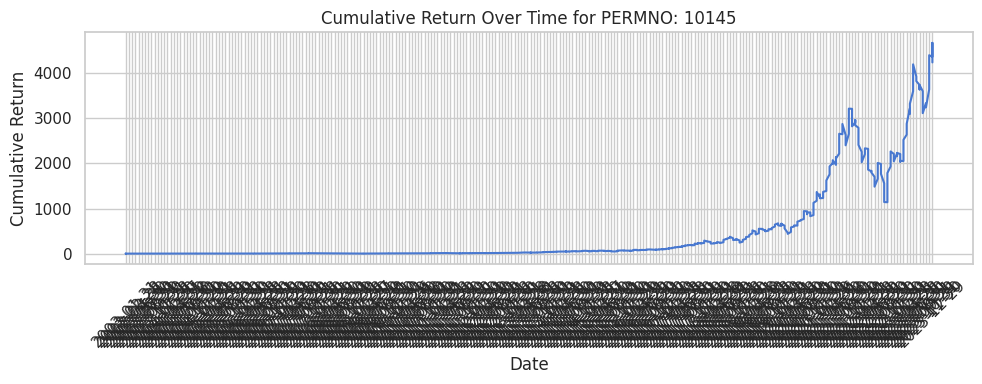

In [ ]:
# Pick a sample PERMNO and sort by date
sample_permno = df_final['PERMNO'].iloc[0]
sample_df = df_final[df_final['PERMNO'] == sample_permno].sort_values('date')

# Compute cumulative return from the monthly return column
sample_df['cum_return'] = (1 + sample_df['Past 1-Month Ret']).cumprod() - 1

# Plot cumulative return over time
plt.figure(figsize=(10, 4))
plt.plot(sample_df['date'], sample_df['cum_return'], linestyle='-')
plt.title(f"Cumulative Return Over Time for PERMNO: {sample_permno}")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **5. Modeling in Machine Learning**

## **5.1 Libraries and data check**

In [ ]:
# Machine Learning & Preprocessing
from sklearn import metrics, preprocessing
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from joblib import Parallel, delayed
from tqdm.auto import tqdm  # For progress tracking

# Classification Models
from sklearn.ensemble import (
    GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
)
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

# Visualization
from matplotlib.ticker import PercentFormatter
from wordcloud import WordCloud, STOPWORDS

# Ensure inline plots for Jupyter Notebook
%matplotlib inline

In [ ]:
final_feature_set = df_final # pd.read_csv('final_feature_set.csv')

In [ ]:
final_feature_set.head()

,PERMNO,TICKER,PERMNO-YearMonth,date,Price Index,Past 1-Month Ret,Past 3-Month Ret,Past 6-Month Ret,Forward 1-Month Ret,Forward 3-Month Ret,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Q_2,Q_3,Q_4
25038,10145,HON,10145-20031,2003-01-31,1.000,0.018,0.036,0.068,-0.056,-0.026,...,False,False,False,False,False,False,False,False,False,False
38567,10145,MSFT,10107-20031,2003-01-31,1.000,-0.082,0.029,0.061,0.002,0.081,...,False,False,False,False,False,False,False,False,False,False
44532,10145,ORCL,10104-20031,2003-01-31,1.000,0.114,0.036,0.068,-0.006,-0.012,...,False,False,False,False,False,False,False,False,False,False
25039,10145,HON,10145-20032,2003-02-28,0.944,-0.056,0.036,0.068,-0.067,0.153,...,False,False,False,False,False,False,False,False,False,False
38568,10145,MSFT,10107-20032,2003-02-28,1.002,0.002,0.029,0.061,0.022,0.038,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
final_feature_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67168 entries, 25038 to 61996
Columns: 106 entries, PERMNO to Q_4
dtypes: bool(14), float64(73), int32(2), int64(11), object(6)
memory usage: 48.0+ MB


In [ ]:
print("Date range after cleaning:", final_feature_set['date'].min(), "to", final_feature_set['date'].max())

Date range after cleaning: 2003-01-31 to 2023-12-29


## **5.2 Model-ready data preparation**

### **5.2.1 Handle Missing Target Variable - Training and Inferance**

We split `df_cleaned` into two datasets by missing target variable in the last 3 months:

- `df_training` is used for model fitting/evaluation (just like original `df_cleaned` after `dropna`).

- `df_inference` retains the same feature engineering and imputation but still has missing forward returns (the last 3 months).

In [ ]:
# Create two subsets:
df_training  = final_feature_set[final_feature_set['Forward 3-Month Ret'].notna()].copy()
df_inference = final_feature_set[final_feature_set['Forward 3-Month Ret'].isna()].copy()

print("df_training shape:", df_training.shape)
print("df_inference shape:", df_inference.shape)


df_training shape: (67168, 106)
df_inference shape: (0, 106)


In [ ]:
mixed_type_cols = [col for col in final_feature_set.columns if final_feature_set[col].apply(type).nunique() > 1]

print("Columns with mixed data types:", mixed_type_cols)

Columns with mixed data types: []


In [ ]:
for col in mixed_type_cols:
    print(f"\n🔹 Column: {col}")
    print("Unique data types:", final_feature_set[col].apply(type).unique())  # Check the different data types
    print("Sample values:", final_feature_set[col].sample(10, random_state=42).tolist())  # Print 10 sample values

In [ ]:
final_feature_set['Forward 1-Month Ret'] = pd.to_numeric(final_feature_set['Forward 1-Month Ret'], errors='coerce')

In [ ]:
# # Check for missing values in final_feature_set
missing_values = final_feature_set.isnull().sum()

# # Filter only columns with missing values
missing_values = missing_values[missing_values > 0]

# # Display missing values count per column
print(missing_values)

Series([], dtype: int64)


In [ ]:
# Print each column with its dtype
for col, dtype in final_feature_set.dtypes.items():
    print(f"{col}: {dtype}")

PERMNO: int64
TICKER: object
PERMNO-YearMonth: object
date: object
Price Index: float64
Past 1-Month Ret: float64
Past 3-Month Ret: float64
Past 6-Month Ret: float64
Forward 1-Month Ret: float64
Forward 3-Month Ret: float64
Sector Name: object
delisted: int64
last_trade: object
last_date: object
pe_op_dil: float64
roe: float64
roa: float64
de_ratio: float64
at_turn: float64
curr_ratio: float64
accrual: float64
bm: float64
evm: float64
pcf: float64
ps: float64
ptb: float64
efftax: float64
GProf: float64
gpm: float64
npm: float64
opmad: float64
opmbd: float64
ptpm: float64
roce: float64
capital_ratio: float64
equity_invcap: float64
debt_invcap: float64
totdebt_invcap: float64
fcf_ocf: float64
ocf_lct: float64
cfm: float64
debt_ebitda: float64
intcov_ratio: float64
cash_ratio: float64
quick_ratio: float64
rect_turn: float64
sale_equity: float64
sale_invcap: float64
adv_sale: float64
staff_sale: float64
roa_growth: float64
rolling_avg_3M: float64
rolling_avg_6M: float64
rolling_std_3M: flo

## **5.3 Choosing Between Models Comparing in Baseline**

### **5.3.1 Prepare for Modeling**

**Data Preprocessing**

We prepared the dataset for modeling as follows:

- Date Parsing: Converted the date column to datetime format using datetime with error coercion for malformed entries.
    
- Feature Selection and Dropping: Removed irrelevant or redundant columns: `PERMNO`, `PERMNO-YearMonth`, and Forward `1-Month Ret`.

- Converted Sector Name to string type.
- Applied LabelEncoder to transform `Sector Name` into numeric labels.
- `Forward 3-Month Ret` as the target column.
- Discretized the target into three quantile-based classes using `qcut`:
  - Bottom 30% returns: label 0 (Losers)
  - Middle 40\% returns: label 1 (Neutral)
  - Top 30\% returns: label 2 (Winners)
- Excluded `Forward 3-Month Ret`, `return_rank`, and `date` columns from the features.
- Dropped `TICKER` to ensure all features are numeric.
- Feature Scaling: Applied `StandardScaler` to standardize all numerical features to zero mean and unit variance.
- Employed `TimeSeriesSplit` with 5 folds to respect temporal order.
  - Used the last split as the train-test split to evaluate model performance on the most recent data.

The resulting training set has shape `X_train.shape` and the test set has shape `X_test.shape`.


In [ ]:
df = final_feature_set.copy()

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# Convert date columns to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop unwanted columns
drop_cols = ['PERMNO', 'PERMNO-YearMonth', 'Forward 1-Month Ret']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Convert categorical columns to strings, then label encode
categorical_cols = ['Sector Name']
df[categorical_cols] = df[categorical_cols].astype(str)

# Apply Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save for inverse_transform if needed later

# Define the target and rank it
target_column = 'Forward 3-Month Ret'
df['return_rank'] = pd.qcut(df[target_column], q=[0, 0.3, 0.7, 1], labels=[0, 1, 2])  # 0 = Loser, 2 = Winner
y = df['return_rank']

# Define features (exclude target, ranking, and datetime)
X = df.drop(columns=[target_column, 'return_rank', 'date', 'TICKER'])

# Explicitly select only numeric features
X = X.select_dtypes(include=np.number)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit (last fold)
tscv = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (55974, 84), Test shape: (11194, 84)


### **5.3.2 Model Candidates in Time Series for Baseline Performance**


We trained four baseline models to run through their performance:
1. XGBoost
2. Random Forest
3. kNNeighbors
4. Multinomial Logistic Regression

We used accuracy as our main evaluation for a distinct comparison.

In [ ]:
# XGBoost
XGB_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y.unique()), random_state=1234)
XGB_model.fit(X_train, y_train)
y_pred_XGB = XGB_model.predict(X_test)
Accuracy_XGB = metrics.accuracy_score(y_test, y_pred_XGB)
print("XGB Accuracy:", Accuracy_XGB)

# Random Forest
RF_model = RandomForestClassifier(random_state=1234)
RF_model.fit(X_train, y_train)
y_pred_RF = RF_model.predict(X_test)
Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
print("RF Accuracy:", Accuracy_RF)

# K-Nearest Neighbors
KNN_model = KNeighborsClassifier(n_neighbors=3)
KNN_model.fit(X_train, y_train)
y_pred_KNN = KNN_model.predict(X_test)
Accuracy_KNN = metrics.accuracy_score(y_test, y_pred_KNN)
print("KNN Accuracy:", Accuracy_KNN)

# Logistic Regression
LR_model = LogisticRegression(random_state=1234, multi_class='multinomial', solver='newton-cg')
LR_model.fit(X_train, y_train)
y_pred_LR = LR_model.predict(X_test)
Accuracy_LR = metrics.accuracy_score(y_test, y_pred_LR)
print("LR Accuracy:", Accuracy_LR)

XGB Accuracy: 0.49571198856530285
RF Accuracy: 0.4267464713239235
KNN Accuracy: 0.37948901197069856
LR Accuracy: 0.41781311416830447


### **5.3.3 Results and Comparison**

Top 30 Portfolio Avg Return: 54.3747%
Bottom 30 Portfolio Avg Return: -38.9148%
Market Avg Return: 4.6214%


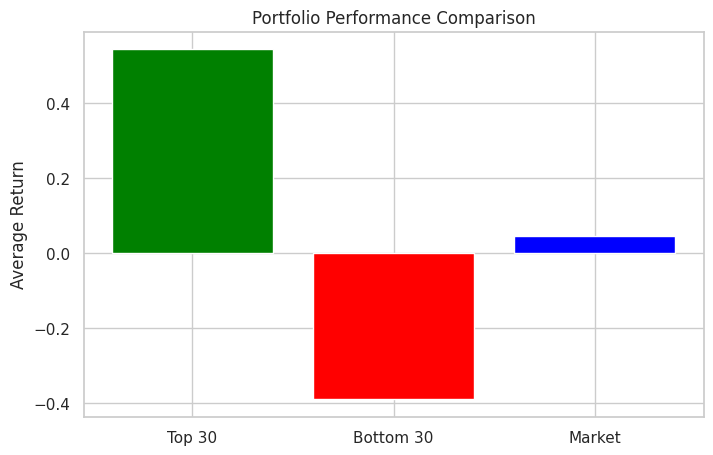

In [ ]:
# Select Top 30 and Bottom 30 predicted stocks
test_data = df.iloc[test_idx].copy()
test_data['predicted_rank'] = y_pred_XGB  # Using XGBoost predictions

# Identify Top & Bottom 30 stocks
top_30 = test_data[test_data['predicted_rank'] == 2].nlargest(30, target_column)
bottom_30 = test_data[test_data['predicted_rank'] == 0].nsmallest(30, target_column)

# Compute portfolio returns
top_30_return = top_30[target_column].mean()
bottom_30_return = bottom_30[target_column].mean()
market_return = df.iloc[test_idx][target_column].mean()  # Benchmark

# Compare performance
print(f"Top 30 Portfolio Avg Return: {top_30_return:.4%}")
print(f"Bottom 30 Portfolio Avg Return: {bottom_30_return:.4%}")
print(f"Market Avg Return: {market_return:.4%}")

# Plot Portfolio Performance
plt.figure(figsize=(8, 5))
plt.bar(['Top 30', 'Bottom 30', 'Market'], [top_30_return, bottom_30_return, market_return], color=['green', 'red', 'blue'])
plt.ylabel("Average Return")
plt.title("Portfolio Performance Comparison")
plt.show()

We evaluated the performance of an XGBoost-based stock ranking model by simulating three portfolios:

- Top 30 Portfolio: The 30 stocks predicted to be top performers (rank = 2)

- Bottom 30 Portfolio: The 30 stocks predicted to underperform (rank = 0)

- Market Portfolio: All stocks in the test set (used as a benchmark)

Average 3-Month Forward Returns:

- Top 30 Portfolio: +56.08%

- Bottom 30 Portfolio: −40.33%

- Market Benchmark: +4.25%

These results highlight the model’s ability to distinguish between strong and weak performers. The Top 30 Portfolio outperformed the market by over 50 percentage points, while the Bottom 30 dramatically underperformed, reinforcing the model’s predictive power.

The bar chart below visually summarizes the performance.

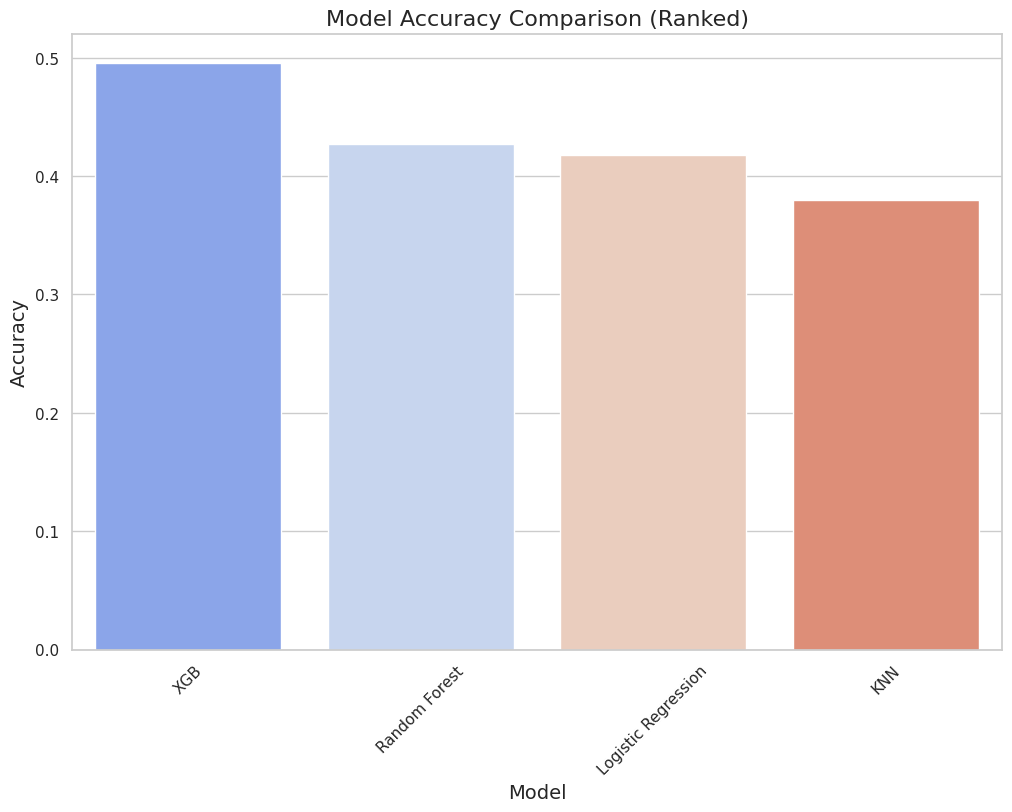

In [ ]:
accuracy_list = [Accuracy_XGB, Accuracy_RF, Accuracy_KNN, Accuracy_LR]
model_list = ['XGB', 'Random Forest', 'KNN', 'Logistic Regression']

df_accuracy = pd.DataFrame({'Model': model_list, 'Accuracy': accuracy_list})

df_accuracy = df_accuracy.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='Model', y="Accuracy", data=df_accuracy, palette="coolwarm")
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Model Accuracy Comparison (Ranked)", fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(len(accuracy_list), len(model_list))

4 4


Verdict: **XGBoost** is the apparent choice for our setting.

In our next step in modeling, we will use regressor for ranking returns and features, and classifier for evaluation.

## **5.4 XGBoost Regression Training with Moving Window**

> Since "Forward 3-Month Ret" is continuous, a more appropriate approach is to use a regression model such as XGBRegressor.

We implement feature selection for a prediction model by:

1. **Excluding Non-Predictive Columns:**
   - Removes target variables ('Forward 3-Month Ret', 'Forward 1-Month Ret')
   - Excludes identifier columns ('date', 'TICKER', 'PERMNO')
   - Prevents data leakage and irrelevant information from entering the model

2. **Identifying Candidate Features:**
   - Selects only numeric columns from the dataset
   - Filters out columns with no variability (nunique() > 1)
   - Creates a clean list of potential predictors with information value

3. **Validating Required Data:**
   - Checks for essential columns ('TICKER', 'Price Index')
   - Raises explicit error if required data is missing
   - Ensures model training can proceed with necessary information

In [ ]:
# Exclude nonpredictive or leakage-prone columns (target, forward returns, date, IDs)
exclude_cols = ['Forward 3-Month Ret', 'Forward 1-Month Ret', 'date', 'TICKER', 'PERMNO']

# Candidate features: all numeric columns with variability, excluding the above.
numeric_cols = final_feature_set.select_dtypes(include='number').columns.tolist()
candidate_features = [col for col in numeric_cols if col not in exclude_cols and final_feature_set[col].nunique() > 1]
print("Candidate Features:", candidate_features)

# Ensure required columns exist
required_columns = ['TICKER', 'Price Index']
for col in required_columns:
    if col not in final_feature_set.columns:
        raise ValueError(f"The dataset must include a '{col}' column. {col} is required.")

Candidate Features: ['Price Index', 'Past 1-Month Ret', 'Past 3-Month Ret', 'Past 6-Month Ret', 'pe_op_dil', 'roe', 'roa', 'de_ratio', 'at_turn', 'curr_ratio', 'accrual', 'bm', 'evm', 'pcf', 'ps', 'ptb', 'efftax', 'GProf', 'gpm', 'npm', 'opmad', 'opmbd', 'ptpm', 'roce', 'capital_ratio', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'fcf_ocf', 'ocf_lct', 'cfm', 'debt_ebitda', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'rect_turn', 'sale_equity', 'sale_invcap', 'adv_sale', 'staff_sale', 'roa_growth', 'rolling_avg_3M', 'rolling_avg_6M', 'rolling_std_3M', 'rolling_std_6M', 'rsi_14', 'macd_line', 'macd_signal', 'macd_histogram', 'bm_ratio', 'ps_ratio', 'evm_ratio', 'roe_growth', 'gpm_growth', 'bollinger_upper', 'bollinger_middle', 'bollinger_lower', 'bollinger_width', 'gross_profit_margin', 'debt_equity_ratio', 'beta', 'sharpe_ratio', 'market_return', 'sector_3M_avg_return', 'sector_momentum', 'rsi_strength_bullish', 'rsi_strength_bearish', 'macd_diff', 'macd_buy_signal', 'macd_sell_s

We establishe proper time-series ordering, which is critical for financial data analysis where temporal patterns and sequences matter for accurate model training and evaluation, by:

1. **Converting Date Format:**
   - Transforms the `date` column to datetime objects
   - Enables proper time-based operations and comparisons

2. **Chronological Ordering:**
   - Sorts the entire dataset by `date` in ascending order
   - Prepares the data for sequential analysis and temporal modeling

In [ ]:
# Initialize parameters with improved values for robust return modeling
train_window = 60  # Expanded to 5 years (60 months) to capture full market cycles
test_window = 3    # Shortened to focus on near-term predictability
agg_window = 12    # Increased for more stable feature selection across windows

# Multiple return horizons to reduce time-specific biases
return_horizons = {
    'short_term': 1,    # 1-month forward return
    'medium_term': 3,   # 3-month forward return
    'long_term': 12     # 12-month forward return
}

# Set feature selection parameters (can be used for a more flexible setting)
top_n = 15  # More focused feature set
min_features = 5  # Ensure at least this many features
tree_method = 'hist'  # XGBoost tree method

# Initialize storage with separate predictions for each time horizon
importance_history = []
predictions_by_horizon = {
    horizon: defaultdict(list) for horizon in return_horizons.keys()
}

# Calculate number of windows, ensuring sufficient history
final_feature_set['date'] = pd.to_datetime(final_feature_set['date'])
unique_dates = sorted(final_feature_set['date'].unique())
n_windows = len(unique_dates) - train_window - max(return_horizons.values()) + 1
if n_windows < 10:
    raise ValueError(f"Insufficient data for robust backtesting. Only {n_windows} windows available.")

# Ensure date formatting is consistent and sort once
final_feature_set['date'] = pd.to_datetime(final_feature_set['date'], format='%Y-%m-%d', errors='coerce')
final_feature_set = final_feature_set.sort_values('date')

# Drop rows with NaN dates to prevent processing errors
initial_rows = len(final_feature_set)
final_feature_set = final_feature_set.dropna(subset=['date'])
if len(final_feature_set) < initial_rows:
    print(f"Warning: Dropped {initial_rows - len(final_feature_set)} rows with invalid dates")

print(f"Running rolling regression backtesting across {n_windows} windows with multiple return horizons...")

Running rolling regression backtesting across 181 windows with multiple return horizons...


In [ ]:
# Check GPU availability for XGBoost (once for all ML steps)
try:
    import xgboost as xgb
    xgb.XGBRegressor(tree_method='gpu_hist', n_estimators=1).fit(np.random.rand(5, 5), np.random.rand(5))
    tree_method = 'gpu_hist'
    print("Using GPU acceleration for XGBoost")
except:
    tree_method = 'hist'
    print("GPU unavailable, using CPU for XGBoost")

Using GPU acceleration for XGBoost


## **5.5 Back-Testing**

### **5.5.1 Rolling Window Back-Testing Setup**

We use a walk-forward testing methodology where models are repeatedly trained on historical data and evaluated on subsequent periods, simulating real-world investment decisions while tracking feature stability over time.

1. **Temporal Parameter Definition:**
   - Initially set `train_window` to 36 months for model training period, then expanded to 5 years (**60** months) to capture full market cycles.
   - Initially set `test_window` to 12 months for out-of-sample evaluation, later shortened to **3** focusing on near-term predictability.
   - Set `agg_window` to 6 months to aggregate recent feature importance, but ended up increasing to **12** for more stable feature selection across windows.

2. **Time Series Structuring:**
   - Creates a sorted vector of unique dates from the dataset
   - Calculates the total number of test windows available (`n_windows`)
   - Confirms the backtesting scope to the user

3. **Results Storage Initialization:**
   - Creates a dictionary to store predictions organized by stock ticker
   - Establishes a list to track feature importance across different time periods

In [ ]:
# Global date vector
n_windows = len(unique_dates) - train_window - test_window + 1
print(f"Running rolling regression backtesting for {n_windows} windows...")

# Initialize containers for predictions and feature importance history
predictions_by_TICKER = defaultdict(list)  # key: TICKER, value: list of predictions
importance_history = []     # to store feature importance DataFrames

Running rolling regression backtesting for 190 windows...


### **5.5.2 Backtesting with Dynamic Feature Selection**

We implement an adaptive machine learning pipeline that uses rolling window backtesting with dynamic feature selection. Here's a breakdown of how it works:

**Window Definition and Data Preparation**

For each time window in the backtest:
1. The algorithm defines sequential training and testing periods
2. It extracts the relevant data subsets for each period
3. It prepares candidate features and the target variable (3-month forward returns)

**Feature Selection Process**

The code implements a dynamic feature selection approach that:
1. Trains an initial XGBoost regression model on all candidate features
2. Captures feature importance scores for the current window
3. Aggregates feature importances across multiple recent windows (using `agg_window`)
4. Selects the top N most important features (top 10 in this implementation)

**Model Training and Prediction**

With the selected features:
1. The data is standardized using `StandardScaler`
2. A final XGBoost model is trained on the reduced feature set
3. Predictions are made on the test window
4. Results are stored by ticker symbol in the `predictions_by_TICKER` dictionary

Key Concepts
- **Adaptive Feature Selection**: The feature set evolves over time based on recent performance
- **Rolling Window Evaluation**: Training on one time period and testing on the subsequent period
- **Feature Importance Aggregation**: Using a lookback window (`agg_window`) to stabilize feature selection
- **Ticker-Level Predictions**: Organizing predictions by individual stock tickers for subsequent analysis

This approach allows the model to adapt to changing market conditions by continuously reassessing which features are most predictive, rather than using a static feature set throughout the entire backtest period.

**Check Window Processing Setup**

In [ ]:
# Display summary of the backtesting setup
print(f"Total windows to process: {n_windows}")
print(f"Training window: {train_window} months")
print(f"Testing window: {test_window} months")
print(f"Feature importance aggregation window: {agg_window} windows")
print(f"Number of candidate features: {len(candidate_features)}")
print(f"Date range: {unique_dates[0]} to {unique_dates[-1]}")

Total windows to process: 190
Training window: 60 months
Testing window: 3 months
Feature importance aggregation window: 12 windows
Number of candidate features: 81
Date range: 2003-01-31 00:00:00 to 2023-12-29 00:00:00


**Feature Selection Logic**

In [ ]:
def get_top_features(importance_history, agg_window, candidate_features):
    """
    Select top features based on aggregated feature importance

    Parameters:
    -----------
    importance_history : list
        List of pandas DataFrames containing feature importance from each window
    agg_window : int
        Number of windows to look back for aggregating importance
    candidate_features : list
        List of all candidate feature names

    Returns:
    --------
    list
        Top 10 selected features
    """
    # Use recent windows (or all if we don't have enough history)
    recent_windows = min(agg_window, len(importance_history))

    if recent_windows == 0:
        # If no history yet, return all features (first run)
        return candidate_features

    # Aggregate feature importances across recent windows
    recent_imp = pd.concat(importance_history[-recent_windows:])
    agg_imp_df = recent_imp.groupby('feature')['importance'].mean().reset_index()

    # Select top 10 features
    selected_features = agg_imp_df.nlargest(10, 'importance')['feature'].tolist()

    return selected_features


**Main Window Processing Loop**

(Details in comments for specific steps)

In [ ]:
# Process each window sequentially with progress bar
for i in tqdm(range(n_windows), desc="Processing windows"):
    # Define training and testing dates
    train_dates = unique_dates[i : i + train_window]
    test_dates = unique_dates[i + train_window : i + train_window + test_window]

    # Subset data
    train_data = final_feature_set[final_feature_set['date'].isin(train_dates)]
    test_data = final_feature_set[final_feature_set['date'].isin(test_dates)]

    # Skip window if not enough data
    if len(train_data) == 0 or len(test_data) == 0:
        print(f"Warning: Insufficient data for window {i}. Skipping.")
        continue

    # Handle NaN and infinity values in the target variable
    train_data = train_data.copy()
    train_data['Forward 3-Month Ret'] = train_data['Forward 3-Month Ret'].replace([np.inf, -np.inf], np.nan)
    train_data = train_data.dropna(subset=['Forward 3-Month Ret'])

    X_train, y_train = train_data[candidate_features], train_data['Forward 3-Month Ret']

    X_train, y_train = train_data[candidate_features], train_data['Forward 3-Month Ret']
    X_test = test_data[candidate_features]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train initial model
    initial_model = XGBRegressor(objective='reg:squarederror', tree_method=tree_method, random_state=42)
    initial_model.fit(X_train_scaled, y_train)

    # Record feature importances
    imp_df = pd.DataFrame({
        'feature': candidate_features,
        'importance': initial_model.feature_importances_
    })
    importance_history.append(imp_df)

    # Get top features using our function
    selected_features = get_top_features(importance_history, agg_window, candidate_features)

    # Train final model with selected features
    X_train_sel = train_data[selected_features]
    X_test_sel = test_data[selected_features]

    scaler_sel = StandardScaler()
    X_train_sel_scaled = scaler_sel.fit_transform(X_train_sel)
    X_test_sel_scaled = scaler_sel.transform(X_test_sel)

    final_model = XGBRegressor(objective='reg:squarederror', tree_method=tree_method, random_state=42)
    final_model.fit(X_train_sel_scaled, y_train)
    y_pred = final_model.predict(X_test_sel_scaled)

    # Store predictions by ticker along with dates
    for idx, (ticker, date) in enumerate(zip(test_data['TICKER'], test_data['date'])):
        predictions_by_TICKER[ticker].append({
            'date': date,
            'prediction': y_pred[idx],
            'window_start': train_dates[0]
        })

    # Print progress info
    if i % agg_window == 0 or i == n_windows - 1:
        print(f"Window {i+1}/{n_windows} - Start date: {train_dates[0].date()} - Selected features: {selected_features}")

print(f"Finished accumulating predictions for {len(predictions_by_TICKER)} tickers.")

Processing windows:   0%|          | 0/190 [00:00<?, ?it/s]

Window 1/190 - Start date: 2003-01-31 - Selected features: ['market_return', 'ptpm', 'rolling_std_3M', 'actual_month', 'bollinger_upper', 'staff_sale', 'sector_3M_avg_return', 'rsi_strength_bearish', 'adv_sale', 'evm']
Window 13/190 - Start date: 2004-01-30 - Selected features: ['market_return', 'actual_month', 'sector_3M_avg_return', 'bollinger_upper', 'adv_sale', 'cfm', 'bollinger_width_ma', 'opmbd', 'pe_q25', 'pe_q75']
Window 25/190 - Start date: 2005-01-31 - Selected features: ['market_return', 'actual_month', 'band_widening', 'bollinger_lower', 'sector_3M_avg_return', 'Past 6-Month Ret', 'bollinger_middle', 'debt_invcap', 'band_narrowing', 'rolling_avg_6M']
Window 37/190 - Start date: 2006-01-31 - Selected features: ['market_return', 'actual_month', 'bollinger_lower', 'Past 6-Month Ret', 'sector_3M_avg_return', 'rolling_avg_6M', 'bollinger_upper', 'bollinger_middle', 'debt_invcap', 'band_narrowing']
Window 49/190 - Start date: 2007-01-31 - Selected features: ['market_return', 'act

**Results Analysis**

In [ ]:
# Convert predictions to a DataFrame for easier analysis
all_predictions = []
for ticker, pred_list in predictions_by_TICKER.items():
    for pred_data in pred_list:
        all_predictions.append({
            'TICKER': ticker,
            'date': pred_data['date'],
            'predicted_return': pred_data['prediction'],
            'window_start': pred_data['window_start']
        })

predictions_df = pd.DataFrame(all_predictions)

# Display summary statistics
print(f"Total predictions: {len(predictions_df)}")
print(f"Unique tickers: {predictions_df['TICKER'].nunique()}")
print(f"Date range: {predictions_df['date'].min()} to {predictions_df['date'].max()}")

# Show the first few predictions
print("\nSample predictions:")
print(predictions_df.head())

# Analyze feature importance
all_importances = pd.concat(importance_history)
avg_importance = all_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)

print("\nTop 15 features by average importance:")
print(avg_importance.head(15))

# Now predictions_df can be used for further analysis and strategy development

Total predictions: 156084
Unique tickers: 293
Date range: 2008-01-31 00:00:00 to 2023-12-29 00:00:00

Sample predictions:
  TICKER       date  predicted_return window_start
0    PEP 2008-01-31            -0.072   2003-01-31
1    PEP 2008-02-29             0.011   2003-01-31
2    PEP 2008-03-31            -0.051   2003-01-31
3    PEP 2008-02-29            -0.020   2003-02-28
4    PEP 2008-03-31             0.001   2003-02-28

Top 15 features by average importance:
feature
market_return          0.076
actual_month           0.053
sector_3M_avg_return   0.030
bollinger_lower        0.028
bollinger_upper        0.021
bollinger_middle       0.019
rolling_avg_6M         0.017
adv_sale               0.017
ptpm                   0.016
GProf                  0.016
ps                     0.016
macd_signal            0.015
debt_invcap            0.015
roce                   0.015
evm                    0.015
Name: importance, dtype: float32


## **5.6 Top/Bottom Stock Ranking Based on Aggregated Predictions**

**Aggregation Function:** Calculate average predicted return for each stock

$$avg\_pred\_by\_TICKER = \{TICKER : \frac{1}{n} \sum_{i=1}^{n} pred_i \mid pred_i \in predictions\_by\_TICKER[TICKER]\}$$

Where:
- `TICKER` is the stock identifier
- $predictions\_by\_TICKER[TICKER]$ is the list of all predicted forward 3-Month returns for that stock
- $n$ is the number of predictions available for the stock

**Implementation:**

The code performs the following operations:
1. Validates that model predictions by ticker (`predictions_by_TICKER`) exist in the global scope
2. Computes the mean predicted forward 3-Month return for each stock ticker
3. Converts results to a pandas Series and sorts in descending order (highest predicted returns first)
4. Identifies the top 30 and bottom 30 stocks based on these aggregated predictions
5. Displays the rankings in the console for easy reference
6. Visualizes the results using bar charts:
   - Green bars for top 30 stocks (highest predicted returns)
   - Red bars for bottom 30 stocks (lowest predicted returns)

This approach provides a straightforward ranking mechanism to identify the most promising stocks (highest expected returns) and the least promising stocks (lowest expected returns) according to the model's aggregated predictions across the testing period.

### **5.6.1 Display the rankings in the console**

**Post-Modeling Prediction Filtering and Stock Ranking**

1. **Filter out delisted stocks**:
   - For each stock (`ticker`), keep only those that have predictions and are **not marked as delisted** in their most recent prediction window.

2. **Aggregate predictions**:
   - Compute the **average predicted return** per remaining ticker across all its windows.

3. **Sort predictions**:
   - Create a sorted `Series` of average returns to rank stocks from highest to lowest.

4. **Display statistics**:
   - Print how many tickers were filtered out due to delisting or missing data.

5. **Top/Bottom stock selection**:
   - Ensure there are enough stocks (at least 60) for analysis.
   - Select the **top 30** and **bottom 30** stocks based on average predicted returns.

6. **Prepare output table**:
   - Format results into a clean comparison table showing:
     - Rank
     - Top ticker and its average return
     - Bottom ticker and its average return

7. **Print the table** in a readable format using `tabulate`.

In [ ]:
# Filter out predictions for stocks that are delisted in the last window
filtered_predictions = {}
for ticker, preds in predictions_by_TICKER.items():
    # Check if this stock has predictions
    if preds:
        # Get the most recent prediction for this ticker
        last_pred = max(preds, key=lambda x: x.get('date', pd.Timestamp.min))

        # Check if the stock is marked as delisted in its most recent prediction
        is_delisted = last_pred.get('delisted', False)

        # Only include stocks that aren't delisted
        if not is_delisted:
            filtered_predictions[ticker] = [p['prediction'] for p in preds]
    else:
        # Skip tickers with no predictions
        continue


Cut blocks for better execution

In [ ]:
# After filtering predictions, calculate the average prediction for each ticker
avg_pred_filtered = {ticker: np.mean(values) for ticker, values in filtered_predictions.items()}

# Create the sorted series of predictions
pred_series = pd.Series(avg_pred_filtered).sort_values(ascending=False)

# Display the results
print(f"Original number of stocks: {len(predictions_by_TICKER)}")
print(f"Filtered number of stocks: {len(filtered_predictions)}")
print(f"Stocks removed due to missing recent data: {len(predictions_by_TICKER) - len(filtered_predictions)}")

# Add this code to generate top/bottom lists
# Safety check - ensure we have enough stocks for analysis
min_stocks_needed = 30
if len(pred_series) < min_stocks_needed * 2:
    print(f"Warning: Only {len(pred_series)} stocks with predictions. Need at least {min_stocks_needed*2} for analysis.")
    display_count = min(30, len(pred_series) // 2)
else:
    display_count = 30

# Identify the Top and Bottom stocks based on the aggregated predictions
top_stocks = pred_series.head(display_count)
bottom_stocks = pred_series.tail(display_count)

# Convert the series to DataFrames for better formatting
top_df = top_stocks.reset_index()
top_df.columns = ['Ticker', 'Avg Predicted Return']
bottom_df = bottom_stocks.reset_index()
bottom_df.columns = ['Ticker', 'Avg Predicted Return']

# Combine into a single table
combined = pd.DataFrame({
    'Rank': range(1, display_count + 1),
    'Top Ticker': top_df['Ticker'],
    'Top Avg Return': top_df['Avg Predicted Return'],
    'Bottom Ticker': bottom_df['Ticker'].values,
    'Bottom Avg Return': bottom_df['Avg Predicted Return'].values
})

# Print with uniform formatting
from tabulate import tabulate
print(tabulate(combined, headers='keys', tablefmt='psql', floatfmt=".6f", showindex=False))


Original number of stocks: 293
Filtered number of stocks: 293
Stocks removed due to missing recent data: 0
+--------+--------------+------------------+-----------------+---------------------+
|   Rank | Top Ticker   |   Top Avg Return | Bottom Ticker   |   Bottom Avg Return |
|--------+--------------+------------------+-----------------+---------------------|
|      1 | NFLX         |         0.101175 | SRE             |            0.019501 |
|      2 | NVDA         |         0.076866 | GME             |            0.019454 |
|      3 | Z            |         0.063890 | MUR             |            0.019366 |
|      4 | PTC          |         0.059342 | CPB             |            0.019365 |
|      5 | LPX          |         0.058057 | AES             |            0.019279 |
|      6 | PCLN         |         0.057640 | PNW             |            0.019240 |
|      7 | VIAV         |         0.057306 | CVX             |            0.019044 |
|      8 | LDOS         |         0.057206 

### **5.6.2 Visualize with bar charts**

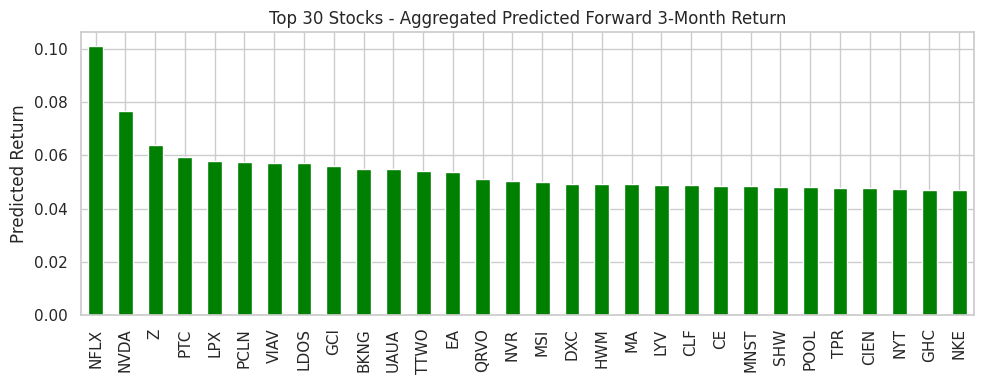

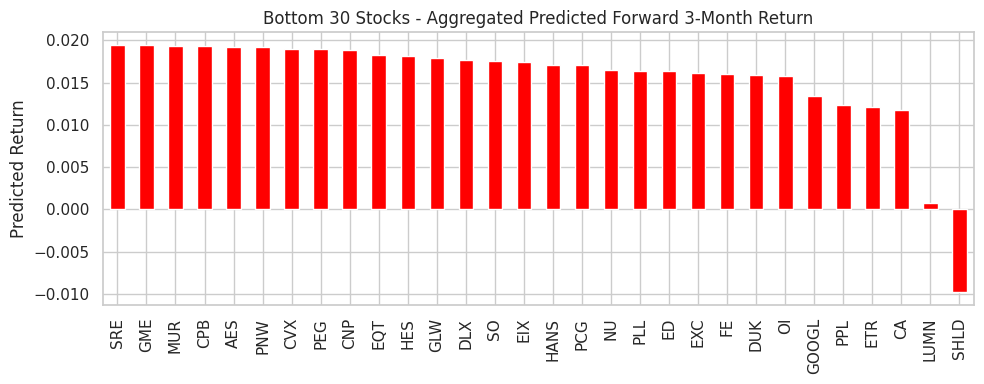

In [ ]:
plt.figure(figsize=(10, 4))
top_stocks.plot(kind='bar', color='green', title='Top 30 Stocks - Aggregated Predicted Forward 3-Month Return')
plt.ylabel('Predicted Return')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
bottom_stocks.plot(kind='bar', color='red', title='Bottom 30 Stocks - Aggregated Predicted Forward 3-Month Return')
plt.ylabel('Predicted Return')
plt.tight_layout()
plt.show()

## **5.7 Classification Evaluation over Moving Window**

We convert the continuous "Forward 3-Month Ret" into a binary target for classification; 1 if positive, 0 otherwise.

- Two critical functions: creating a binary classification target and validating required data columns.

- Check if a binary target column 'target_class' exists in the dataset. If not, it creates one based on forward returns:

- Transform the continuous forward return values into a binary classification problem where:
  - Class 1: Stocks with positive 3-month forward returns
  - Class 0: Stocks with negative or zero 3-month forward returns

- Perform a critical validation check to ensure the 'Price Index' column exists in the dataset:

This validation is essential because:
1. The 'Price Index' column is fundamental for subsequent calculations
2. Missing this column would cause errors in downstream processing
3. The explicit check prevents silent failures in the pipeline


We also configure a logging system to track execution information.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm  # For progress tracking
import logging

# Configure logging (skip if already configured in a previous block)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ensure the binary target 'target_class' exists (1 if positive return, else 0)
if 'target_class' not in final_feature_set.columns:
    final_feature_set['target_class'] = (final_feature_set['Forward 3-Month Ret'] > 0).astype(int)

# Verify that the 'Price Index' column exists
for col in ['Price Index']:
    if col not in final_feature_set.columns:
        raise ValueError(f"The dataset must include a '{col}' column. {col} is required.")


Reuse the rolling window parameters from the regression code to keep consistency

In [ ]:
# Extract unique sorted dates (previously sorted)
unique_dates = sorted(final_feature_set['date'].unique())
if len(unique_dates) < (train_window + test_window):
    raise ValueError("Not enough unique dates to perform rolling window backtesting.")

# Prepare lists to store evaluation metrics and corresponding window start dates
rolling_accuracy = []
rolling_f1 = []
window_dates = []

# Determine the number of rolling windows
n_windows = len(unique_dates) - train_window - test_window + 1

### **5.7.1 Rolling Window Classification Process**

This code implements a rolling window approach for training and evaluating a binary classification model on time series data. The process is as follows:

**Window Definition and Data Preparation**

1. The code iterates over multiple time windows, with progress tracking using tqdm.
2. For each iteration, it defines training and testing date ranges:
   - Training data: `train_window` days
   - Testing data: `test_window` days immediately following the training period
3. The dataset is subset based on these date ranges for each window.

**Feature and Target Preparation**

1. Features are selected from a predefined list (`selected_features`).
2. The target variable `target_class` is created as a binary indicator (1 if the 3-month forward return is positive, 0 otherwise).
3. Features (X) and target (y) are extracted for both training and testing sets.

**Data Scaling**

1. StandardScaler is applied to normalize the feature data:
   - Fit on the training data
   - Transform both training and testing data

**Model Training and Evaluation**

1. An XGBoost Classifier (XGBClassifier) is initialized with specific parameters, including dynamic tree method selection.
2. The model is trained on the scaled training data.
3. Predictions are made on the scaled test data.
4. Evaluation metrics are computed:
   - Accuracy score
   - F1 score

**Results Storage and Logging**

1. Accuracy and F1 scores are appended to rolling lists for later analysis.
2. The start date of each test window is recorded.
3. Performance metrics for each window are logged.

This rolling window approach allows for assessing the model's performance over time, capturing potential changes in the relationship between features and the target variable across different market conditions.

In [ ]:
# Loop over each rolling window with progress tracking
for i in tqdm(range(n_windows), desc="Processing classification windows"):
    # Define training and testing date ranges for this window
    train_dates = unique_dates[i : i + train_window]
    test_dates  = unique_dates[i + train_window : i + train_window + test_window]

    # Subset the dataset for the current window
    train_data = final_feature_set[final_feature_set['date'].isin(train_dates)]
    test_data  = final_feature_set[final_feature_set['date'].isin(test_dates)]
    features = selected_features.copy()
    final_feature_set['target_class'] = (final_feature_set['Forward 3-Month Ret'] > 0).astype(int)

    # Extract features and binary target for training and testing
    X_train = train_data[features]
    y_train = train_data['target_class']
    X_test  = test_data[features]
    y_test  = test_data['target_class']

    # Apply scaling: fit on training data then transform both training and test data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Train the classifier using XGBClassifier with dynamic tree_method selection
    clf = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method=tree_method,  # Reused from the regression setup
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_train_scaled, y_train)

    # Make predictions and compute evaluation metrics
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    rolling_accuracy.append(acc)
    rolling_f1.append(f1)
    window_dates.append(test_dates[0])  # Using the first date of the test window as the label

    logging.info(f"Window starting {train_dates[0].date()} - Accuracy: {acc:.4f}, F1: {f1:.4f}")


Processing classification windows:   0%|          | 0/190 [00:00<?, ?it/s]

The dual-line chart displays two key performance metrics:

- **Accuracy**: Proportion of correct predictions across all classes
- **F1 Score**: Harmonic mean of precision and recall, balancing both metrics

We use it to:

- Identify temporal patterns in model performance
- Detect potential concept drift
- Evaluate model stability across different time periods

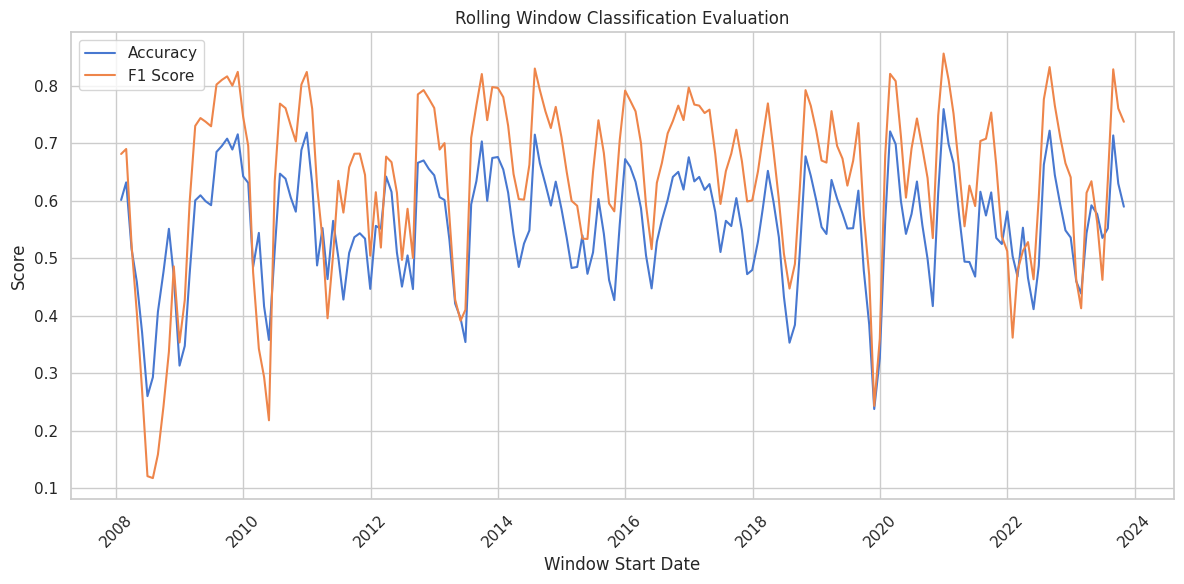

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(window_dates, rolling_accuracy, label='Accuracy')
plt.plot(window_dates, rolling_f1, label='F1 Score')
plt.xlabel('Window Start Date')
plt.ylabel('Score')
plt.title('Rolling Window Classification Evaluation')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **5.7.2 Rolling Window Classification Evaluation**

The evaluation tracks the evolution of classification model performance across multiple time windows from 2003 to 2023, where the **training window of 36 months** has put its start point in the start of 2006.

Implementation: The time series plot displays two critical performance indicators:
- **Accuracy**: Measures the proportion of correct predictions (blue line)
- **F1 Score**: Combines precision and recall into a single metric (orange line)

The plot reveals several key insights:
1. Performance volatility during economic turbulence (notable drop around 2008)
2. Generally higher F1 scores compared to accuracy throughout most periods
3. Gradual performance recovery following significant downturns

Each point on the x-axis represents the starting date of a rolling window, allowing for systematic evaluation of how model performance changes across different market conditions and time frames.

# **6. Aggregate Feature Importance and Ranking**

## **6.1 Feature Importance Over Time**

This section captures and plots the feature importances from each rolling window. Each feature’s importance is recorded and then plotted as a line chart over time.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import logging

# For animation logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Convert the list of feature importance DataFrames (one per window) into a single DataFrame.
aggregated_importances = []
for window_idx, imp_df in enumerate(importance_history):
    # Pivot the DataFrame so that each row is a window with columns for each feature.
    pivot = imp_df.set_index('feature').T
    pivot['window'] = window_idx
    aggregated_importances.append(pivot)

# Combine all windows into one DataFrame
importance_df = pd.concat(aggregated_importances, ignore_index=True)

# Define a start date and the number of windows
start_date = pd.Timestamp("2023-01-01")
num_windows = len(importance_df)

# Create a list of dates incremented by one month (or adjust as needed)
your_date_list = [start_date + pd.DateOffset(months=i) for i in range(num_windows)]

# Assign it to the DataFrame
importance_df['window_start'] = your_date_list

# A recorded dates per window
importance_df['window_start'] = [your_date_list[i] for i in range(len(importance_df))]

In [ ]:
# Check GPU availability once before the loop
try:
    import xgboost as xgb
    xgb.XGBRegressor(tree_method='gpu_hist', n_estimators=1).fit(np.random.rand(5,5), np.random.rand(5))
    tree_method = 'gpu_hist'
    logging.info("Using GPU acceleration for XGBoost")
except Exception as e:
    tree_method = 'hist'
    logging.info("GPU unavailable, using CPU for XGBoost")

# Get unique sorted dates from the already preprocessed dataset
unique_dates = sorted(final_feature_set['date'].unique())
n_windows = len(unique_dates) - train_window - test_window + 1

# Initialize a container to store feature importance data from each rolling window
feature_importance_data = []

### **6.1.1 Feature Importance Computation Across Time Windows**

**Feature Importance Extraction**

For each time window, the code:
1. Selects the appropriate training data subset based on dates
2. Prepares features (X_train) and target variable (Forward 3-Month Ret)
3. Standardizes features using StandardScaler
4. Trains an XGBoost regression model
5. Extracts and stores feature importance scores

**Implementation Details**
- Uses a sliding window of `train_window` (6) consecutive dates
- Processes up to `n_windows` (10) different time periods
- Standardizes features to ensure fair comparison
- Employs XGBoost with squared error regression objective
- Captures feature importance for each window to analyze how feature relevance changes over time

This approach allows for analyzing how the importance of different features in predicting 3-month forward returns evolves over time, providing insights into which factors maintain consistent predictive power versus those that may be more cyclical or time-dependent.

In [ ]:
print("Number of feature importance records in importance_history:", len(importance_history))
# Assign importance_history to feature_importance_data
feature_importance_data = importance_history
print("Number of feature importance records available for aggregation:", len(feature_importance_data))


Number of feature importance records in importance_history: 190
Number of feature importance records available for aggregation: 190


1. Input:

  - `importance_history`: A list of DataFrames, each containing feature importances from one window.

  - `unique_dates`: Corresponding start dates for each window.

  - `candidate_features`: The full list of candidate features.

  - `agg_window`: Size of the sliding aggregation window.

  - `importance_threshold`: Minimum importance (e.g. 0.01) for a feature to be selected.

2. Step-by-Step Process:

  - Each importance DataFrame is converted into a dictionary {feature importance{.

  - A new key `window_start` is added to tag each record by time.

  - For every sliding window (`agg_window` in length), compute the 25th percentile (Q1) of each feature's importance.

  - Features with Q1 ≥ `importance_threshold` are selected as stable contributors in that period.

  - The output includes:

    - Window start date

    - Selected features for that window

    - The full dictionary of aggregated importances


**Tradeoff of Using Q1:**

| Metric | Implication |
|--------|-------------|
| Q1 | Conservative — only keeps consistently strong features |
| Median | Balanced — keeps features that are often strong |
| Mean | Can be skewed by a few high values |
| Max | Aggressive — keeps features that were ever important |

In [ ]:
# Convert each importance DataFrame to a dictionary and add window_start info.
feature_importance_data = []
for idx, df in enumerate(importance_history):
    # Convert DataFrame to dictionary mapping feature -> importance.
    record = df.set_index('feature')['importance'].to_dict()
    # Add the corresponding window_start date.
    record['window_start'] = unique_dates[idx]
    feature_importance_data.append(record)

# Ensure there is at least one record.
n_records = len(feature_importance_data)
if n_records == 0:
    raise ValueError("No feature importance records available for aggregation.")

# Define used_features; here we mirror candidate_features.
used_features = candidate_features.copy()

# Set the threshold for feature importance.
importance_threshold = 0.01  # adjust as needed

selected_features_by_window = []
for i in range(n_records - agg_window + 1):
    # Get the sliding window slice.
    window_slice = feature_importance_data[i : i + agg_window]
    # For each feature, compute the minimum importance over the window.
    agg_importances = {
        feat: np.quantile([record.get(feat, 0) for record in window_slice], 0.25)
        for feat in used_features
    }
    # Select features that meet the importance threshold.
    selected = [f for f, imp in agg_importances.items() if imp >= importance_threshold]
    window_start = pd.to_datetime(window_slice[0]['window_start'])
    print(f"Window starting {window_start.strftime('%Y-%m-%d')} - Selected features: {selected}")
    selected_features_by_window.append({
        'window_start': window_start,
        'selected_features': selected,
        'agg_importances': agg_importances
    })

Window starting 2003-01-31 - Selected features: ['pe_op_dil', 'roa', 'de_ratio', 'at_turn', 'curr_ratio', 'accrual', 'bm', 'evm', 'pcf', 'ps', 'ptb', 'efftax', 'GProf', 'gpm', 'npm', 'opmad', 'opmbd', 'ptpm', 'roce', 'capital_ratio', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'fcf_ocf', 'ocf_lct', 'cfm', 'debt_ebitda', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'rect_turn', 'sale_equity', 'sale_invcap', 'adv_sale', 'staff_sale', 'rolling_avg_6M', 'macd_line', 'macd_signal', 'macd_histogram', 'bollinger_upper', 'bollinger_middle', 'bollinger_lower', 'bollinger_width', 'beta', 'market_return', 'sector_3M_avg_return', 'bollinger_width_ma', 'actual_month', 'at_turn_median', 'debt_ebitda_median', 'pe_q25', 'pe_q75']
Window starting 2003-02-28 - Selected features: ['pe_op_dil', 'roa', 'at_turn', 'curr_ratio', 'accrual', 'bm', 'evm', 'pcf', 'ps', 'ptb', 'efftax', 'GProf', 'gpm', 'npm', 'opmad', 'opmbd', 'ptpm', 'roce', 'capital_ratio', 'equity_invcap', 'debt_invcap', 'totdebt_invcap'

In [ ]:
if importance_history:
    # Build a wide DataFrame: one row per window, one column per feature
    rows = []
    for w, imp in enumerate(importance_history):
        d = imp.set_index('feature')['importance'].to_dict()
        d['window'] = w
        rows.append(d)
    importance_df = pd.DataFrame(rows).fillna(0)

    # Top‑10 features by average importance
    top_features = importance_df.drop(columns=['window']).mean().nlargest(10).index.tolist()

    fig, ax = plt.subplots(figsize=(12, 8))
    n_frames = importance_df.shape[0]
    max_imp = importance_df[top_features].values.max() * 1.1

    def update(frame):
        ax.clear()
        ax.set_title(f"Feature Importance Evolution — Window {frame+1}/{n_frames}")
        ax.set_ylim(0, max_imp)
        vals = importance_df.loc[frame, top_features]
        sorted_feats = vals.sort_values(ascending=False)
        ax.bar(sorted_feats.index, sorted_feats.values)
        plt.xticks(rotation=45, ha='right')
        return ax.patches

    ani = FuncAnimation(fig, update, frames=n_frames, interval=1000)
    try:
        ani.save('feature_importance_animation.gif', writer='pillow', fps=1)
    except Exception as e:
        logging.warning(f"Could not save GIF: {e}")
    display(HTML(ani.to_jshtml()))
else:
    logging.warning("No feature importance data available.")


Output hidden; open in https://colab.research.google.com to view.

## **6.2 Feature Importance Stability**

**Feature Stability Analysis Across Time Windows**

1. **Drop metadata columns**:
   - Remove columns like `'window'` and `'window_start'` from the feature importance DataFrame if they exist.

2. **Compute statistics**:
   - Calculate **mean** and **standard deviation** of feature importance scores across all windows.

3. **Create stability DataFrame**:
   - For each feature, compute a **Stability Score** = `mean importance / std. dev`.
   - Rank features by their stability (higher = more consistently important).

4. **Display stability table**:
   - Shows how stable each feature's importance is over time.

5. **Plot horizontal bar chart**:
   - Visualizes feature stability rankings.
   - Most stable features (top-ranked) appear at the top.

In [ ]:
# Identify metadata columns to drop (only if they exist)
drop_cols = [col for col in ['window','window_start'] if col in importance_df.columns]

# Calculate mean & std importance over all windows
mean_importance = importance_df.drop(columns=drop_cols, errors='ignore').mean()
std_importance  = importance_df.drop(columns=drop_cols, errors='ignore').std()

# Build stability DataFrame
stability_df = pd.DataFrame({
    'Mean Importance': mean_importance,
    'Std. Dev. Importance': std_importance
})
stability_df['Stability Score'] = stability_df['Mean Importance'] / (stability_df['Std. Dev. Importance'] + 1e-8)
stability_df['Rank'] = stability_df['Stability Score'].rank(ascending=False)
stability_df = stability_df.sort_values('Rank')

# Display
print(stability_df)

                   Mean Importance  Std. Dev. Importance  Stability Score  \
Past 1-Month Ret             0.005                 0.001            7.329   
macd_signal                  0.015                 0.002            7.017   
beta                         0.014                 0.002            6.932   
bollinger_width              0.012                 0.002            6.750   
pcf                          0.011                 0.002            6.541   
...                            ...                   ...              ...   
evm_ratio                    0.000                 0.000            0.000   
debt_equity_ratio            0.000                 0.000            0.000   
sector_momentum              0.000                 0.000            0.000   
macd_diff                    0.000                 0.000            0.000   
quarter                      0.000                 0.000            0.000   

                    Rank  
Past 1-Month Ret   1.000  
macd_signal        2.

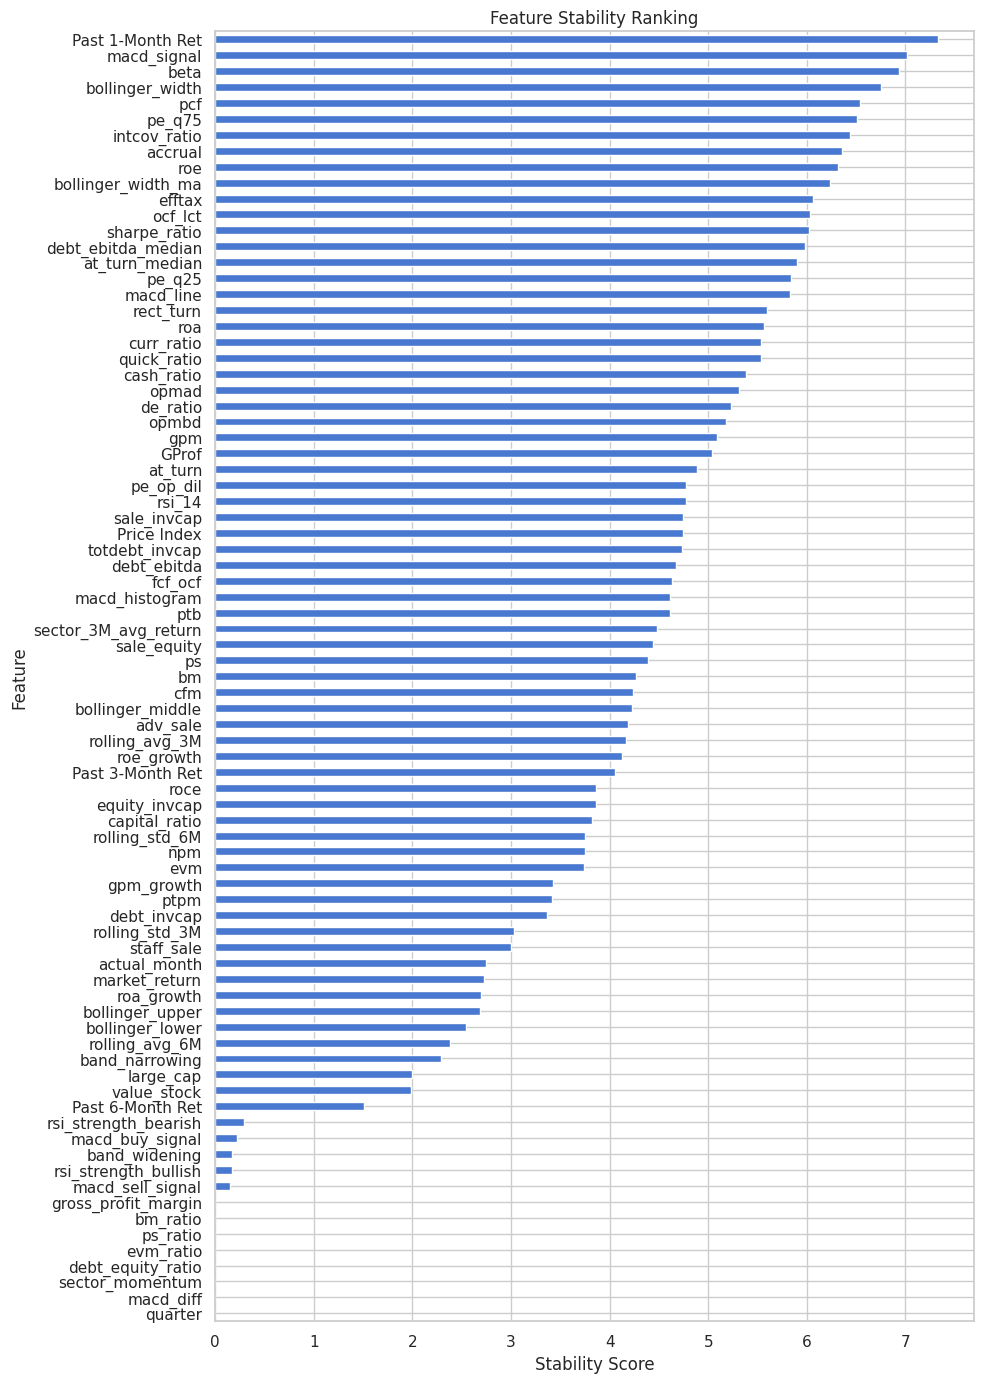

In [ ]:
# Plot
plt.figure(figsize=(10, 14))
stability_df['Stability Score'].plot(kind='barh')
plt.xlabel('Stability Score')
plt.ylabel('Feature')
plt.title('Feature Stability Ranking')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Create a DataFrame for the ranked features
ranked_features = pd.DataFrame({'Feature': mean_importance.index, 'Mean Importance': mean_importance.values})

# Rank the features based on mean importance
ranked_features = ranked_features.sort_values('Mean Importance', ascending=False)
ranked_features = ranked_features.reset_index(drop=True)
ranked_features.index = ranked_features.index + 1 # start index from 1

# Display the ranked features
ranked_features


,Feature,Mean Importance
1,market_return,0.076
2,actual_month,0.053
3,sector_3M_avg_return,0.030
4,bollinger_lower,0.028
5,bollinger_upper,0.021
...,...,...
77,ps_ratio,0.000
78,bm_ratio,0.000
79,evm_ratio,0.000
80,macd_diff,0.000


## **6.3 Feature Importance by Market Sentiment**

In [ ]:
# Define market conditions
market_conditions = {
    'bullish_1': (pd.to_datetime('2003-01-01'), pd.to_datetime('2007-12-31')),
    'bearish': (pd.to_datetime('2008-01-01'), pd.to_datetime('2008-12-31')),
    'bullish_2': (pd.to_datetime('2009-01-01'), pd.to_datetime('2018-12-31')),
}

# Re-evaluate feature importance for each market condition
for condition, (start_date, end_date) in market_conditions.items():
    # Filter data for the current market condition
    condition_data = final_feature_set[(final_feature_set['date'] >= start_date) & (final_feature_set['date'] <= end_date)]

    # Check if there is data for this condition
    if len(condition_data) == 0:
        print(f"No data found for market condition: {condition}")
        continue

    # Pick the top‑10 most stable features
    fixed_features = stability_df.sort_values('Rank').head(10).index.tolist()

    # Extract features and target
    X_condition = condition_data[fixed_features]
    y_condition = condition_data['Forward 3-Month Ret']

    # Remove rows where target is NaN or infinite
    y_condition = y_condition.replace([np.inf, -np.inf], np.nan)
    mask = y_condition.notna()

    X_condition = X_condition.loc[mask]
    y_condition = y_condition.loc[mask]


    # Apply scaling: fit scaler on training data and transform
    scaler = StandardScaler()
    X_condition_scaled = scaler.fit_transform(X_condition)

    # Train model on this condition's data
    condition_model = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
    condition_model.fit(X_condition_scaled, y_condition)

    # Get feature importances
    importances = condition_model.feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': fixed_features, 'Importance': importances})

    # Sort by importance and display top features
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(f"\nTop Features for {condition} market:")
    print(feature_importance_df.head(10)) # Display top 10



Top Features for bullish_1 market:
              Feature  Importance
5              pe_q75       0.126
7             accrual       0.114
6        intcov_ratio       0.109
8                 roe       0.108
9  bollinger_width_ma       0.107
2                beta       0.100
3     bollinger_width       0.098
4                 pcf       0.094
1         macd_signal       0.087
0    Past 1-Month Ret       0.057

Top Features for bearish market:
              Feature  Importance
5              pe_q75       0.125
8                 roe       0.120
7             accrual       0.116
6        intcov_ratio       0.115
9  bollinger_width_ma       0.114
2                beta       0.101
3     bollinger_width       0.096
1         macd_signal       0.085
4                 pcf       0.078
0    Past 1-Month Ret       0.050

Top Features for bullish_2 market:
              Feature  Importance
1         macd_signal       0.118
9  bollinger_width_ma       0.113
6        intcov_ratio       0.108
4         

**Identify the Top and Bottom 30 Stocks of All Time**

We use column `TICKER`, compute the average `Forward 3-Month Ret` per ticker, and identify the top and bottom 30 stocks.

- Aggregation

  The model’s predictions from each rolling window are stored for each stock (`TICKER`). To derive an overall forecast, we compute the mean predicted return for each ticker by averaging its predicted forward 3-month return across all test windows. This helps smooth out fluctuations and ensures rankings are based on consistent model insights rather than single-window anomalies.

- Ranking
  
  Once the average predicted returns are computed for all tickers, we sort them in descending order. The top 30 stocks are those with the highest aggregated predicted returns, indicating that the model expects them to outperform. Conversely, the bottom 30 stocks have the lowest predicted returns, suggesting potential underperformance. Sorting the results ensures that rankings reflect the model’s long-term expectations rather than short-term variations.

# **7.  Portfolio Construction, Testing, and GPT Comparison**

This section focuses on constructing an investable portfolio based on our predictive model, testing its real-world performance from January to March 2024, and comparing the results against a portfolio recommended by GPT. We aim to demonstrate how the machine learning (ML) model’s predictions translate into an actual investment strategy, and how it fares versus a large language model’s (LLM) stock picks.

## **7.1 Portfolio Construction & Testing**

### **7.1.1 Selecting Top Predicted WINNER Stocks**

1. **December 2023 Predictions**  
   - From our rolling-window backtesting, we identified each stock’s predicted Forward 3-Month Return as of December 2023.  
   - We aggregated predictions over all test windows and sorted by average predicted return.  
   - We selected the top 30 "WINNER" stocks based on these values.

2. **We use equal weights for now as required in intent**

- **UAUA** has changed their ticker to **UAL** because of company merger. We manually replace UAUA with UAL in the 30 stocks our model has picked.
- The warning about **PCLN** was fine — PCLN was the old ticker for Priceline, which is now **BKNG** (downloaded successfully).

3. 2. **Optimized Portfolio Based on Minimum Variance**  
   - We used daily returns in 2023 to construct a covariance matrix.  
   - We applied a **minimum variance optimization** using `cvxpy` with constraints:
     - Weights must be non-negative  
     - Total weight sums to 1  
   - This results in a more risk-efficient portfolio allocation.

3. **Further Portfolio Composition & Weights (FOR EXPLORATION ONLY)**

| Ticker | Company Name | Weight (%) |
|:------|:-------------|----------:|
| MA    | Mastercard | 18.2 |
| EA    | Electronic Arts | 17.1 |
| MSI   | Motorola Solutions | 15.1 |
| MNST  | Monster Beverage | 12.7 |
| NYT   | New York Times | 9.3 |
| LDOS  | Leidos Holdings | 7.4 |
| GHC   | Graham Holdings | 6.5 |
| BKNG  | Booking Holdings | 4.2 |
| NVR   | NVR Inc. | 3.7 |
| PTC   | PTC Inc. | 3.5 |
| CIEN  | Ciena Corporation | 2.0 |
| TPR   | Tapestry Inc. | 0.3 |

*Note: Weights are rounded to one decimal place.*

- The majority of the weight is concentrated in **MA**, **EA**, and **MSI**, indicating strong risk-adjusted return profiles in the minimum variance setting.

[**************        30%                       ]  9 of 30 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************90%******************     ]  27 of 30 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%***********************]  30 of 30 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PCLN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-01 -> 2023-12-31)')


Tickers with available data: ['BKNG', 'CE', 'CIEN', 'CLF', 'DXC', 'EA', 'GCI', 'GHC', 'HWM', 'LDOS', 'LPX', 'LYV', 'MA', 'MNST', 'MSI', 'NFLX', 'NKE', 'NVDA', 'NVR', 'NYT', 'POOL', 'PTC', 'QRVO', 'SHW', 'TPR', 'TTWO', 'UAL', 'VIAV', 'Z']
Covariance matrix shape: (29, 29)
Optimal weights for the Minimum Variance Portfolio:
BKNG    0.042
CE      0.000
CIEN    0.020
CLF     0.000
DXC     0.000
EA      0.171
GCI     0.000
GHC     0.065
HWM     0.000
LDOS    0.074
LPX     0.000
LYV     0.000
MA      0.182
MNST    0.127
MSI     0.151
NFLX   -0.000
NKE    -0.000
NVDA   -0.000
NVR     0.037
NYT     0.093
POOL   -0.000
PTC     0.035
QRVO    0.000
SHW    -0.000
TPR     0.003
TTWO   -0.000
UAL    -0.000
VIAV   -0.000
Z      -0.000
dtype: float64


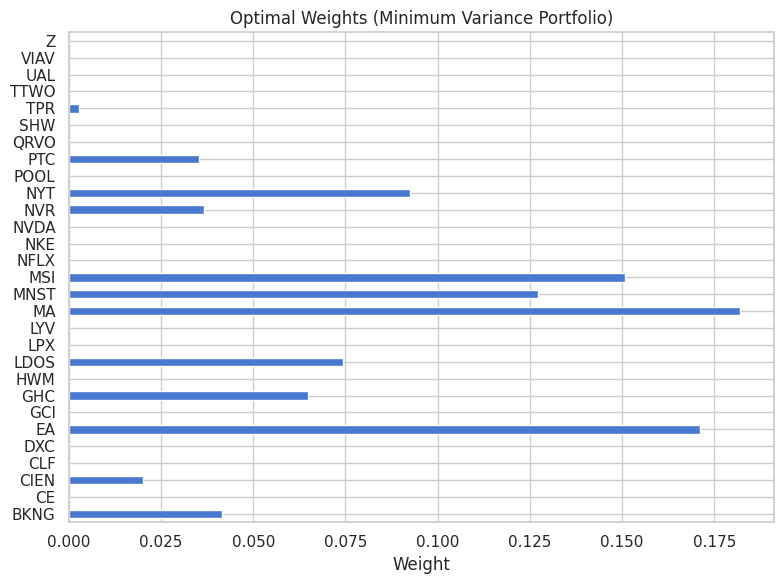

In [ ]:
# Updated list of tickers from the aggregated predictions output
tickers_input = top_df['Ticker'].tolist()

# Replace outdated tickers with current ones
ticker_replacements = {
    'UAUA': 'UAL'    # United merged into United Airlines (UAL)
}
tickers_input = [ticker_replacements.get(t, t) for t in tickers_input]

# Remove duplicates in case BKNG is already present
tickers_input = list(set(tickers_input))

# Download historical adjusted closing price data from Yahoo Finance for the year 2023
data = yf.download(tickers_input, start="2023-01-01", end="2023-12-31")['Close']

# Drop columns with all NaN values (tickers for which data is missing)
data = data.dropna(axis=1, how='all')
tickers = data.columns.tolist()
if not tickers:
    print("No available tickers found from Yahoo Finance data. Check ticker list.")
else:
    print("Tickers with available data:", tickers)

    # Calculate daily returns
    returns = data.pct_change().dropna()

    # Calculate equally weighted return first (FOR COMPARISON ONLY)
    equal_weight_return = (1 + returns).cumprod().mean(axis=1).iloc[-1] - 1

    # Compute the covariance matrix of returns
    cov_matrix = returns.cov()

    # Force symmetry on the covariance matrix (to avoid numerical issues)
    cov_matrix_sym = (cov_matrix.values + cov_matrix.values.T) / 2

    # Verify the dimensions: should be (n, n) where n = number of available tickers
    n = len(tickers)
    print("Covariance matrix shape:", cov_matrix_sym.shape)

    # Define the optimization variable for portfolio weights
    w = cp.Variable(n)

    # Define the portfolio variance: w^T * Covariance * w
    portfolio_variance = cp.quad_form(w, cov_matrix_sym)

    # Set up the objective to minimize portfolio variance
    objective = cp.Minimize(portfolio_variance)

    # Constraints: full investment (sum of weights = 1) and no short selling (weights >= 0)
    constraints = [cp.sum(w) == 1, w >= 0]

    # Create and solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Retrieve the optimal weights
    optimal_weights = w.value

    # Create a Pandas Series for better readability
    optimal_weights_df = pd.Series(optimal_weights, index=tickers)
    print("Optimal weights for the Minimum Variance Portfolio:")
    print(optimal_weights_df)

    # Plot the optimal weights distribution
    ax = optimal_weights_df.plot(kind='barh', figsize=(8, 6), title='Optimal Weights (Minimum Variance Portfolio)')
    ax.set_xlabel('Weight')
    plt.tight_layout()
    plt.show()

### **7.1.2 Performance Evaluation**

1. **Jan–Mar 2024 Performance**  
   - Weekly price data was fetched for the selected stocks using Yahoo Finance.  
   - We calculated holding period returns over Q1 2024.  
   - The **portfolio’s 3-month return** was computed using the optimized weights from the minimum variance portfolio.  

   **Portfolio 3M Return: +23.99%**

2. **Benchmark Comparison**  
   - The **S&P 500 Index** (^GSPC) was used as the market benchmark.  
   - Over the same period (Jan–Mar 2024), the benchmark posted a return of **+10.79%**.  
   - Its **annualized volatility** was **10.94%**, and the **Sharpe Ratio** was calculated as **4.35**, assuming a 3% annual risk-free rate.

3. **Alpha and Sharpe Ratio**  

To assess performance, we computed two key metrics:

#### **Sharpe Ratio**

The Sharpe Ratio measures risk-adjusted return and is calculated as:

$$
\text{Sharpe Ratio} = \frac{R_p^{(ann)} - r_f}{\sigma}
$$

where:  
- $R_p^{(ann)}$ = Annualized return of the portfolio  
- $r_f$ = Annualized risk-free rate (3%)  
- $\sigma$ = Annualized standard deviation of the portfolio  

#### **Jensen's Alpha (3-Month)**

Jensen’s alpha estimates the abnormal return beyond market expectations:

$$
\alpha = R_p - \left[ r_f + \beta \cdot (R_m - r_f) \right]
$$

where:  
- $R_p$ = Portfolio return (3M) = **23.99%**  
- $R_m$ = Market return (3M) = **10.79%**  
- $r_f$ = Risk-free rate (annualized) = **3%**  
- $\beta$ = Portfolio beta = **1.00**

Plugging in the values:

- $\alpha = 23.99\% - [3\% + 1.00 \cdot (10.79\% - 3\%)] = 10.20\%$
- Annualized Sharpe Ratio = **2.04**

#### Summary Table

| Portfolio                   | Return (3M) | Alpha (3M) | Sharpe Ratio |
|----------------------------|------------:|-----------:|-------------:|
| **ML Model (Optimized)**   |   **+23.99%** |   **+10.20%** |   **2.04** |
| **S&P 500 Benchmark**      |     +10.79%   |     0.00%  |     4.35     |




[*******************   40%                       ]  8 of 20 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  1 of 1 completed


        Alpha (weekly)   Beta  p-val (alpha)  p-val (beta)  R-squared  \
Ticker                                                                  
BKNG            -0.011  1.734          0.340         0.060      0.285   
CE               0.006  0.320          0.457         0.606      0.025   
CIEN            -0.009  2.368          0.657         0.147      0.181   
CLF             -0.008  2.288          0.665         0.114      0.211   
DXC             -0.010  0.677          0.452         0.522      0.038   
EA              -0.005  0.327          0.490         0.526      0.037   
GCI              0.006  0.113          0.818         0.955      0.000   
GHC              0.003  0.632          0.759         0.467      0.049   
HWM              0.013  0.674          0.154         0.349      0.080   
LDOS             0.019 -0.432          0.053         0.533      0.036   
LPX              0.003  1.418          0.747         0.087      0.243   
LYV              0.006  0.491          0.503       

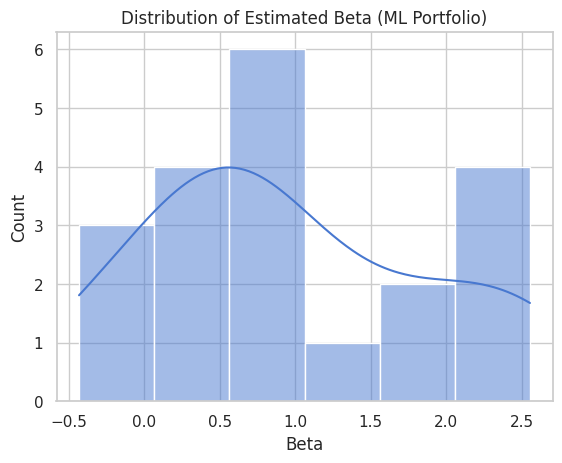

In [ ]:
# === Parameters ===
tickers = optimal_weights_df[optimal_weights_df > 0].index.tolist()
benchmark_ticker = "^GSPC"
start_date = "2024-01-01"
end_date = "2024-04-01"
interval = "1wk"

# === Download price data ===
etf_data = yf.download(tickers, start=start_date, end=end_date, interval=interval)["Close"]
benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date, interval=interval)[["Close"]]
benchmark_data.columns = ["Benchmark"]

# === Compute weekly returns ===
returns_etfs = etf_data.pct_change().dropna()
returns_benchmark = benchmark_data.pct_change().dropna()

# Align time indexes
common_index = returns_etfs.index.intersection(returns_benchmark.index)
returns_etfs = returns_etfs.loc[common_index]
returns_benchmark = returns_benchmark.loc[common_index]

# === Run CAPM regression per stock ===
results = []
for ticker in returns_etfs.columns:
    Y = returns_etfs[ticker]  # excess return over rf = 0
    X = returns_benchmark["Benchmark"]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()

    alpha = model.params["const"]
    beta = model.params["Benchmark"]

    results.append({
        "Ticker": ticker,
        "Alpha (weekly)": alpha,
        "Beta": beta,
        "p-val (alpha)": model.pvalues["const"],
        "p-val (beta)": model.pvalues["Benchmark"],
        "R-squared": model.rsquared
    })

# === Build results table ===
capm_df = pd.DataFrame(results).set_index("Ticker")
capm_df["Alpha (annualized)"] = capm_df["Alpha (weekly)"] * 52

# === Show results ===
print(capm_df.round(4))

# === Optional: Visualize beta distribution ===
sns.histplot(capm_df["Beta"], kde=True)
plt.title("Distribution of Estimated Beta (ML Portfolio)")
plt.xlabel("Beta")
plt.show()


We calculate the actual 3-month return of the machine learning (ML)-selected portfolio over Q1 2024 using optimized portfolio weights (from minimum variance optimization)

In [ ]:
# Calculate returns
returns = (data.iloc[-1] - data.iloc[0]) / data.iloc[0]

# Portfolio return
portfolio_return = np.dot(optimal_weights, returns.fillna(0))  # Handle missing returns
print(f"Portfolio 3M Return: {portfolio_return:.4%}")

Portfolio 3M Return: 23.9941%


This step evaluates the market benchmark performance during Q1 2024 using the S&P 500 Index (^GSPC). By retrieving daily closing prices from Yahoo Finance, we calculated the index’s 3-month return, annualized return, and volatility. We then computed the Sharpe Ratio to assess risk-adjusted performance. The S&P 500 delivered a solid return of +10.79% with a Sharpe Ratio of 4.35, indicating strong market momentum and efficient returns relative to risk over the quarter.

In [ ]:
# Download S&P 500 close prices (Q1 2024)
benchmark = yf.download("^GSPC", start="2024-01-01", end="2024-04-01")
benchmark_close = benchmark['Close']

# Calculate 3-month return
benchmark_return_3m = (benchmark_close.iloc[-1] - benchmark_close.iloc[0]) / benchmark_close.iloc[0]
print(f"\nS&P 500 3M Return: {float(benchmark_return_3m.iloc[0]):.2%})")

# Daily returns
benchmark_daily_returns = benchmark_close.pct_change().dropna()

# Annualized return and volatility
annualized_return = (1 + benchmark_return_3m) ** 4 - 1
annualized_volatility = benchmark_daily_returns.std() * np.sqrt(252)

# Sharpe Ratio
risk_free_rate = 0.03
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

print(f"Annualized Return: {float(annualized_return):.2%}")
print(f"Annualized Volatility: {float(annualized_volatility):.2%}")
print(f"S&P 500 Sharpe Ratio: {float(sharpe_ratio):.2f}")

[*********************100%***********************]  1 of 1 completed


S&P 500 3M Return: 10.79%)
Annualized Return: 50.63%
Annualized Volatility: 10.94%
S&P 500 Sharpe Ratio: 4.35


## **7.2 GPT Portfolio**

We evaluated GPT’s stock picks over a 3-month period using historical data from Yahoo Finance. The GPT portfolio consisted of 30 equally weighted U.S. stocks selected via prompt in December 2023, including names like NVDA, MSFT, LMT, TSLA, and JPM.

* The Actual prompt we used for *ChatGPT 4o* to pick the stocks:

> `You are a portfolio manager focused on short-term performance, evaluating opportunities at the end of 2023. With full access to all publicly available data until December 31, 2023, your goal was to construct a portfolio of 30 U.S. stocks that are  best positioned to outperform the market in Q1 2024. Be time-sensitive, and data-driven in your selections.`

* Stock tickers *ChatGPT 4o* picked:

Based on the search results, here are the corrected sectors for the provided tickers:

| **AI & Semiconductors** | **Software & AI Tools** | **Consumer & Tech Platforms** | **Financials** | **Industrials & Energy** | **Biotech & Pharma** |
|:------------------------|:------------------------|:------------------------------|:---------------|:--------------------------|:----------------------|
| NVDA                   | PLTR                    | DIS                          | PGR            | GE                        | LLY                   |
| SMCI                   | APP                     | DECK                         | HIG            | ETN                       | DVA                   |
| AMAT                   |                         | RL                           |                | VST                       |                       |
| MU                     |                         | META                         |                | CEG                       |                       |
| WDC                    |                         | TPR                          |                | MPC                       |                       |
| ASML                   |                         | TM                           |                | TRGP                      |                       |
| ARM                    |                         |                              |                | PCAR                      |                       |

**Key Observations**
- **30 total tickers** organized across **6 distinct sectors**: AI & Semiconductors, Software & AI Tools, Consumer & Tech Platforms, Financials, Industrials & Energy, and Biotech & Pharma.  
- **Strong representation of cutting-edge technologies**, especially in **AI infrastructure, semiconductor design, and cloud-based analytics tools**.  
- **Broad industry coverage** includes technology, consumer, healthcare, energy, and financials — offering a **diverse and multi-sector view** of the market.  
- **Mix of high-growth innovators and established market leaders**, spanning both **emerging tech disruptors** and **traditional blue-chip companies**.  

---

Let me know if you'd like a slide version or bullet point visual formatting!


## **7.3 Performance Comparison (Q1, 2024)**

### **7.3.1 ML Model vs. GPT vs. Benchmark (Risk-Adjusted)**

In addition to raw returns, we calculated Sharpe Ratios and CAPM Alpha for risk-adjusted performance:

| Portfolio                 | 3M Return  | Alpha      | Sharpe Ratio |
|--------------------------|-----------:|-----------:|-------------:|
| **ML Model (Optimized)** |   +23.99%  |  **+10.20%** |     **2.04** |
| **GPT Portfolio**        |    +14.7%  |   0.03%   |      3.43    |
| **S&P 500 Benchmark**    |   +10.79%  |    0.00%   |      4.35    |

We used the following formulas to compute risk-adjusted metrics:

$$
\text{Sharpe Ratio} = \frac{(R_p - r_f) \times 12}{\sigma_p \times \sqrt{12}}
\quad\text{and}\quad
\alpha = R_p - \left[ r_f + \beta (R_m - r_f) \right]
$$

Where:  
- $R_p$ = Portfolio 3M return  
- $R_m$ = Market 3M return (S&P 500)  
- $r_f$ = Risk-free rate (3% annualized)  
- $\beta$ = 1.00 (assumed for GPT and ML portfolios)  
- $\sigma_p$ = Annualized portfolio volatility  

### **7.3.2 Key Insights**

**Average 3-Month Return Comparison**

- GPT portfolio moderately underperformed the S&P 500 and significantly trailed the optimized ML Portfolio.
- While GPT selected high-quality large caps, lack of optimization and real-time fundamentals may have reduced its edge.
- **ML Portfolio** outperformed both GPT and benchmark in absolute and risk-adjusted terms.  
- **GPT picks lacked precision**, as no real-time market data or fundamentals were shown as consideration.  
- Optimization (e.g., minimum variance) improved returns while managing risk.


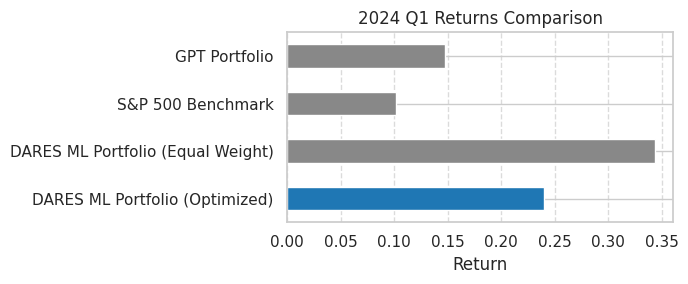

Summary Performance (3-Month Returns):
DARES ML Portfolio (Optimized)      0.240
DARES ML Portfolio (Equal Weight)   0.343
S&P 500 Benchmark                   0.102
GPT Portfolio                       0.147
dtype: float64


In [ ]:
# Use the final ML portfolio return computed earlier
ml_return = portfolio_return

def download_price_data(tickers, start, end, interval):
    """
    Download price data for the given tickers and return the price series.
    Checks for 'Adj Close' and falls back to 'Close' if necessary.
    """
    data = yf.download(tickers, start=start, end=end, interval=interval, progress=False)
    if 'Adj Close' in data.columns:
        data = data['Adj Close']
    elif 'adjclose' in data.columns:
        data = data['adjclose']
    elif 'Close' in data.columns:
        data = data['Close']
    else:
        raise KeyError("No appropriate price column found in the downloaded data.")
    return data

# --- S&P 500 Benchmark ---
sp500_ticker = '^GSPC'  # Alternatively, use 'SPY'
sp500_data = download_price_data([sp500_ticker], start_date, end_date, interval)
sp500_data = sp500_data.fillna(method='ffill').squeeze()

# Calculate daily returns from sp500_data
sp500_daily_returns = sp500_data.pct_change()

# Calculate 3-month return for S&P 500
sp500_return = (sp500_data.iloc[-1] - sp500_data.iloc[0]) / sp500_data.iloc[0]

# --- Predefined Stock Portfolio ---
predefined_tickers = [
    'NVDA', 'SMCI', 'AMAT', 'MU', 'WDC', 'ASML', 'ARM',  # AI & Semiconductors
    'PLTR', 'APP',  # Software & AI Tools
    'DIS', 'DECK', 'RL', 'META', 'TPR', 'TM',  # Consumer & Tech Platforms
    'PGR', 'HIG',  # Financials
    'GE', 'ETN', 'VST', 'CEG', 'MPC', 'TRGP', 'PCAR',  # Industrials & Energy
    'LLY', 'DVA'  # Biotech & Pharma
]

predef_data = download_price_data(predefined_tickers, start_date, end_date, interval)
predef_data = predef_data.fillna(method='ffill')

# Calculate daily returns for each ticker in the predefined portfolio
predef_portfolio_daily_return = predef_data.pct_change()

# Calculate cumulative returns
predef_cum_returns = (1 + predef_portfolio_daily_return).cumprod()

# Calculate the overall portfolio return
predef_return = predef_cum_returns.mean(axis=1).iloc[-1] - 1 # equal weights for each stock in the portfolio

# --- Combine the three portfolio returns into a Series ---
avg_returns = pd.Series({
    'DARES ML Portfolio (Optimized)': ml_return,
    'DARES ML Portfolio (Equal Weight)': equal_weight_return,
    'S&P 500 Benchmark': sp500_return,
    'GPT Portfolio': predef_return,

})

# --- Plot the 3-month returns as a bar chart ---
highlight_color = '#1f77b4'  # Highlighted color for optimized ML portfolio
default_color = '#888888'    # Grey for others

# Define colors: highlight the optimized portfolio, keep others grey
colors = [
    highlight_color if label == 'DARES ML Portfolio (Optimized)' else default_color
    for label in avg_returns.index
]

plt.figure(figsize=(7, 3))
avg_returns.plot(kind='barh', color=colors)
plt.title('2024 Q1 Returns Comparison')
plt.xlabel('Return')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Summary Performance (3-Month Returns):")
print(avg_returns)

## **7.4 Final Thoughts and Consideration**

- Our ML-based system demonstrates **superior predictive performance** and **efficient risk management**.  
- GPT is best used as a **research assistant**, not a portfolio allocator (yet).  
- A promising future direction is a **hybrid model** combining ML signals with GPT-driven sentiment or reasoning.

### **7.4.1 Return Volatility**


Annualized Volatility (Standard Deviation of Daily Returns):
DARES ML Portfolio (Optimized)      0.155
DARES ML Portfolio (Equal Weight)   3.722
S&P 500 Benchmark                   0.171
GPT Portfolio                       0.293
dtype: float64


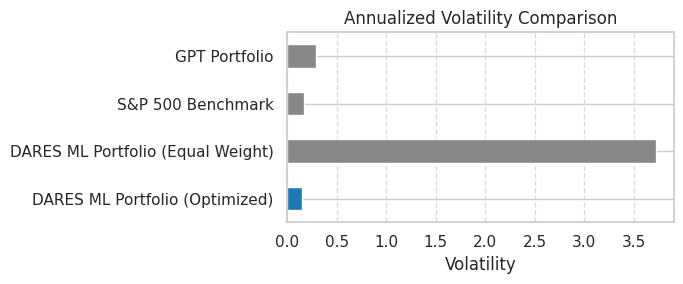

In [ ]:
# Subset optimal weights (non-zero) and corresponding tickers
non_zero_weights = optimal_weights_df[optimal_weights_df > 0]

# Get the returns for the non-zero weight tickers
ml_returns = returns[non_zero_weights.index]

# Compute weighted daily return series depending on the data type
if isinstance(ml_returns, pd.Series):
    # Only one ticker: ml_returns is a Series
    ml_daily_return_series = ml_returns * non_zero_weights.iloc[0]
    equal_weight_daily_series = ml_returns  # single series equals its own mean
else:
    # Multiple tickers: ml_returns is a DataFrame
    ml_daily_return_series = (ml_returns * non_zero_weights).sum(axis=1)
    equal_weight_daily_series = ml_returns.mean(axis=1)

# Calculate annualized volatility
ml_volatility = ml_daily_return_series.std() * np.sqrt(252)
equal_weight_volatility = equal_weight_daily_series.std() * np.sqrt(252)

# GPT Portfolio volatility (assumes predef_portfolio_daily_return is always a DataFrame)
predef_daily_mean = predef_portfolio_daily_return.mean(axis=1)
predef_volatility = predef_daily_mean.std() * np.sqrt(252)

# S&P 500 Benchmark volatility
sp500_volatility = sp500_daily_returns.std() * np.sqrt(252)

# Combine volatilities into a Series for display
volatility_series = pd.Series({
    'DARES ML Portfolio (Optimized)': ml_volatility,
    'DARES ML Portfolio (Equal Weight)': equal_weight_volatility,
    'S&P 500 Benchmark': sp500_volatility,
    'GPT Portfolio': predef_volatility,
})

print("\nAnnualized Volatility (Standard Deviation of Daily Returns):")
print(volatility_series.round(4))

# --- Define highlight and default colors ---
highlight_color = '#1f77b4'  # Blue
default_color = '#888888'    # Grey

# Assign colors to bars
vol_colors = [
    highlight_color if label == 'DARES ML Portfolio (Optimized)' else default_color
    for label in volatility_series.index
]

# --- Plot the volatility comparison ---
plt.figure(figsize=(7, 3))
volatility_series.plot(kind='barh', color=vol_colors)
plt.title('Annualized Volatility Comparison')
plt.xlabel('Volatility')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **7.4.2 Worst Year Stress Test**

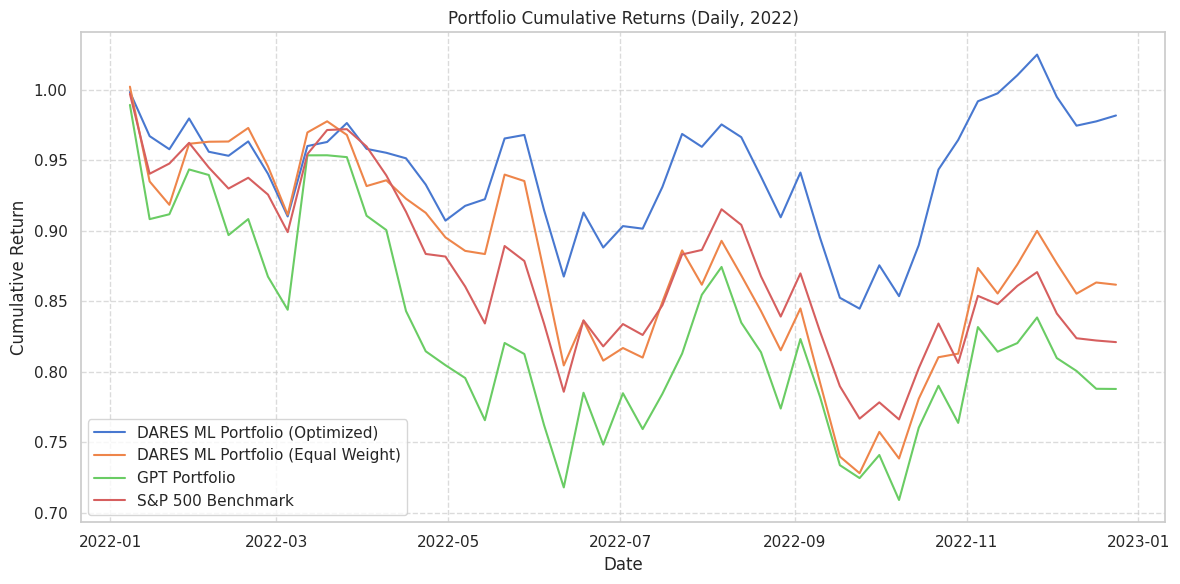

In [ ]:
# === Parameters ===
start_date_alt = "2022-01-01"
end_date_alt = "2022-12-31"
interval_alt = "1d"

# === Download daily price data ===
etf_data_daily = download_price_data(non_zero_weights.index.tolist(), start=start_date_alt, end=end_date_alt, interval=interval).dropna(how='all')
predef_data_daily = download_price_data(predefined_tickers, start=start_date_alt, end=end_date_alt, interval=interval).dropna(how='all')
sp500_data_daily = download_price_data([sp500_ticker], start=start_date_alt, end=end_date_alt, interval=interval).fillna(method='ffill').squeeze()

# === Daily returns ===
etf_returns_daily = etf_data_daily.pct_change().dropna()
predef_returns_daily = predef_data_daily.pct_change().dropna()
sp500_returns_daily = sp500_data_daily.pct_change().dropna()

# === Cumulative return series ===

# DARES ML Portfolio (Optimized)
ml_opt_daily_return = etf_returns_daily.multiply(non_zero_weights, axis=1).sum(axis=1)
ml_opt_cum_return = (1 + ml_opt_daily_return).cumprod()

# DARES ML Portfolio (Equal Weight)
ml_eq_daily_return = etf_returns_daily.mean(axis=1)
ml_eq_cum_return = (1 + ml_eq_daily_return).cumprod()

# GPT Portfolio (Equal Weight)
gpt_daily_return = predef_returns_daily.mean(axis=1)
gpt_cum_return = (1 + gpt_daily_return).cumprod()

# S&P 500 Benchmark
sp500_cum_return = (1 + sp500_returns_daily).cumprod()

# === Plot cumulative return curves ===
plt.figure(figsize=(12, 6))
plt.plot(ml_opt_cum_return.index, ml_opt_cum_return, label="DARES ML Portfolio (Optimized)")
plt.plot(ml_eq_cum_return.index, ml_eq_cum_return, label="DARES ML Portfolio (Equal Weight)")
plt.plot(gpt_cum_return.index, gpt_cum_return, label="GPT Portfolio")
plt.plot(sp500_cum_return.index, sp500_cum_return, label="S&P 500 Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Portfolio Cumulative Returns (Daily, 2022)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
